In [1]:
# !pip install statsmodels
# !pip install lets-plot

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import Ridge

from statsmodels.tsa.stattools import adfuller, kpss, acf as sm_acf, pacf as sm_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.arima.model import ARIMA

from scipy.stats import norm


c:\Users\lawor\anaconda3v0\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

#from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import seaborn as sns

import datetime as dt
import time
import re

from lets_plot import *
LetsPlot.setup_html()

In [4]:
# from google.colab import files
# import pandas as pd

# # Upload file from local computer
# uploaded = files.upload()

# Read into DataFrame
IV_y_values = pd.read_csv('MOVE_index.csv')
Fed_funds = pd.read_csv('FedFunds.csv')
UST_10Y = pd.read_csv('UST10Y.csv')
HYOAS = pd.read_csv('HYOAS.csv')
NFCI = pd.read_csv('NFCI.csv')
Termspread = pd.read_csv('TermSpread_10Y_2Y.csv')
vix = pd.read_csv('VIX.csv')
Breakeven_10Y = pd.read_csv('Breakeven10Y.csv')


## RV FORECASTING CODE STRUCTURE

- Outer Loop: Rolling Window Sizes: Iterate over different rolling window sizes to test how each window size affects model performance.

- Second Loop: Feature Construction for All Estimators. For each window size, compute features using your HAR_Model.features() method. Each estimator (e.g., RV, BV, MedRV, RR) will have its own feature set derived from its volatility series.

- Third Loop: Fit & Predict for Each Estimator. For each estimator: Run fit_predict() using the features and target series. Collect yhat (forecasted volatility) and residuals. Store predictions and residuals for metric evaluation.

- End of Loop.

Metric Computation. For each estimator: Compute QLIKE, MPSE, and optionally other metrics. Plot: QLIKE and MPSE over time. QLIKE mean and variance over time (to assess stability). These plots help visualize performance across time and windows. Residual to be evaluted. Do the same for the ensemble model with weightage to be computed based on metric performance.

In [5]:
class volatility_estimator:
    def __init__(self, add_log):
        self.add_log = add_log

    def _check(self, df):
        required = ['High', 'Low', 'Open', 'Close']
        if not set(required).issubset (df.columns):
            raise ValueError(f"Dataframe needs columns {required}.")
        if (df[required]<=0).any().any():
            raise ValueError(f"Dataframe contains nonpositive values")
        return df

    def compute_square_return(self,df):
        df = self._check(df)
        log_return =  np.log(df['Close'] / df['Close'].shift(1))
        return 252*(log_return ** 2)

    def compute_parkinson_estimator(self,df):
        df = self._check(df)
        log_par_var = (np.log(df['High'] / df['Low']))**2
        return 252*((1/(4*np.log(2))) * log_par_var)

    def compute_gk_estimator(self,df):
        df = self._check(df)
        gk_var_1 = (1/2)*(np.log(df['High']/df['Low']))**2
        gk_var_2 = (2*np.log(2)-1)*(np.log(df['Close']/df['Open']))**2
        return 252*(gk_var_1 - gk_var_2)

    def compute_rs_estimator(self, df):
        df = self._check(df)
        rs_var_1 = (np.log(df['High']/df['Open']))*(np.log(df['High']/df['Close']))
        rs_var_2 = (np.log(df['Low']/df['Open']))*(np.log(df['Low']/df['Close']))
        return 252*(rs_var_1 + rs_var_2)

    def compute_all(self,df, lag_for_predictors:bool=False):
          df = self._check(df).copy()
          eps = 1e-12

          out = pd.DataFrame(index = df.index)
          out['square_est'] = self.compute_square_return(df)
          out['parkinson_est']=self.compute_parkinson_estimator(df)
          out['gk_est'] = self.compute_gk_estimator(df)
          out['rs_est'] = self.compute_rs_estimator(df)

          if self.add_log:
              for col in ['square_est', 'parkinson_est', 'gk_est', 'rs_est']:
                  x = out[col].astype(float).replace([np.inf, -np.inf], np.nan)
                  out[col + '_log'] = np.log(x.clip(lower=eps))
          if lag_for_predictors:
            out = out.shift(1)

          return out

In [6]:
# premodel diagnotics on the data assumptions.
import warnings

class Vol_Est_Check:

    def __init__(self,
                 alpha,
                 lb_lags,
                 kpss_reg,
                 kpss_nlags,
                 acf_pacf_nlags):
        # alpha: significant level
        # lb_lags: lags to report to Ljung box
        # kpss: reg[c - level, ct - trend], nlags: auto or int
        #ADF passed stationary when p<0.05 (reject H_0 of unit root)
        self.alpha = alpha
        self.lb_lags = tuple(lb_lags)
        self.kpss_reg = kpss_reg
        self.kpss_nlags = kpss_nlags
        self.acf_pacf_nlags = acf_pacf_nlags

    def ADF(self, df, name):
        df = df.dropna()
        series_name = name or getattr (df, 'name', 'series')

        stat, p, lags, nobs, crit, icbest = adfuller(df, autolag = 'AIC')
        stationary_flag = p <= self.alpha
        return {"adf_stat": stat,
                "adf_p": p,
                "adf_lags": lags,
                "adf_nobs": nobs,
                "adf_crit": crit,
                'adf_icbest': icbest,
                'adf_stationary_flag': stationary_flag,
                'adf_decision': (f'{series_name}: Reject H0 -> stationary'
                    if stationary_flag
                    else 'Fail to reject H0 -> non-stationary'
                )}


    def KPSS(self,df, name, nlags):
        df = df.dropna()
        series_name = name or getattr (df, 'name', 'series')

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            stat, p, lags, crit = kpss(df,
                                       regression=self.kpss_reg,
                                       nlags=nlags)

        stationary_flag = (p > self.alpha)
        return {
            "kpss_stat": stat, # stat < crit -> series is stationary
            "kpss_p": p, # p >0.05  -> series is stationary
            "kpss_lags": lags,
            "kpss_crit": crit,
            'kpss_reg': self.kpss_reg,
            'kpss_stationary_flag': stationary_flag,
            'kpss_decision': (f'{series_name}: Fail to reject H0 ->stationary'
            if stationary_flag
            else f"{series_name}: Reject H0 -> Non-stationary")
            }


    def ljung_box(self, df): # reject H0 -> serial correlation
        df = df.dropna()
        lb = acorr_ljungbox(df, lags=list(self.lb_lags), return_df=True)
        out={}
        for L in self.lb_lags:
            out[f'lb_stat_{L}'] = float(lb.loc[L, "lb_stat"]) # stat for each lag h
            out[f"lb_p_{L}"]   = float(lb.loc[L, "lb_pvalue"])  # p-value

        out['white_noise_flag'] = all(out[f'lb_p_{L}'] > self.alpha for L in self.lb_lags)
        out["lb_lags_used"] = self.lb_lags
        out['n_obs'] = len(df)
        out['name'] = getattr(df, 'name', 'series')
        return out

    def compute_acf(self, df, nlags, alpha):
        df=df.dropna()
        nlags = nlags or self.acf_pacf_nlags
        vals, conf = sm_acf(df,
                            nlags = nlags,
                            alpha = alpha,
                            fft = True,
                            adjusted = False)
        return {'acf_vals': vals,
                'acf_confint': conf} #shape(nlags+1,2)


    def compute_pacf(self, df, nlags, alpha, method: str = 'ywmle'):
        df=df.dropna()
        nlags = nlags or self.acf_pacf_nlags
        vals, conf = sm_pacf(df,
                             nlags=nlags,
                             alpha=alpha,
                             method=method)
        return {
            'pacf_vals': vals,
            'pacf_confint': conf,
            'pacf_method': method
            }

    def plot_acf(self, df, nlags, title:str = None):
        df = df.dropna()
        nlags = nlags or self.acf_pacf_nlags
        plot_acf(df, lags=nlags)
        plt.title(title or f"ACF ({getattr(df,'name','series')})")
        plt.show()

    def plot_pacf(self, df, nlags, title: str = None, method: str = 'ywmle'):
        df = df.dropna()
        nlags = nlags or self.acf_pacf_nlags
        plot_pacf(df, lags=nlags)
        plt.title(title or f"PACF ({getattr(df,'name','series')})")
        plt.show()

    def summarize_series(self, df, name = None): #for 1 estimator
        series_name = name or getattr (df, 'name', 'series')
        results = {}
        results.update(self.ADF(df, name = name))
        results.update(self.KPSS(df, name = name, nlags=self.kpss_nlags))

        lb = self.ljung_box(df)
        results.update({f"lb_{k}": v for k, v in lb.items()})

        return results


In [7]:
#HAR model function
from typing import Iterable, Optional, Dict, Tuple

class HAR_Model:
  def __init__(self, y_log_col, exo_col, lags =[1,5,22]):
    self.y_log_col = y_log_col
    self.exo_col = exo_col
    self.lags = lags #daily, weekly, monthly

  def features(self, df):
    y_pred = df[self.y_log_col]
    out = pd.DataFrame(index=df.index)
    out['rv_d'] = y_pred
    out['rv_w'] = y_pred.rolling(self.lags[1], min_periods = self.lags[1]).mean()
    out['rv_m'] = y_pred.rolling(self.lags[2], min_periods = self.lags[2]).mean()

    if self.exo_col:
      for col in self.exo_col:
        out[f'x_{col}'] =df[col]

    return out.dropna()

  def fit_predict(self,
                  x_train,
                  y_train,
                  window):

    resid_full = pd.Series(index=y_train.index, data=np.nan)
    yhat_full = pd.Series(index=y_train.index, data=np.nan)
    residual_raw = pd.Series(index=y_train.index, data=np.nan)
    for t in range(window, len(y_train)):
      y_slice = y_train.iloc[t-window:t]
      x_slice = x_train.iloc[t-window:t]

      common_idx = x_slice.index.intersection(y_slice.index)
      y_slice = y_train.loc[common_idx]
      x_slice = x_train.loc[common_idx]

      model = sm.OLS(y_slice, sm.add_constant(x_slice)).fit()

      x_next = pd.DataFrame([x_train.iloc[t]])
      x_next = sm.add_constant(x_next, has_constant='add')

      yhat_full.iloc[t] = model.predict(x_next).iloc[0]
      resid_full.iloc[t] = model.resid.var(ddof=x_slice.shape[1]) #ddof degree of freedom correction for unbiased variance
      residual_raw.iloc[t] = yhat_full.iloc[t] - y_train.iloc[t]

    return yhat_full, resid_full, residual_raw



In [8]:
# to compute for the ensemble model

class EnsembleModel:
  def __init__(self, estimators):
    self.estimators = estimators

  def compute_weightage(self, qlike, eps=1e-12): # weightage computed by using inverse qlike
    inverse = {k: 1.0/max(v,eps) for k,v in qlike.items()}
    total = sum(inverse.values()) if inverse else 0.0
    weight = {k: v/total for k,v in inverse.items()}
    return weight


In [9]:
# metric computation function

class Metric_Evaluation:
  def __init__(self, ytrue, y_pred, alpha):
    self.y_pred = y_pred
    self.ytrue = ytrue
    self.alpha = alpha

  def mspe(ytrue, ypred):
    return ((ytrue - ypred) / ytrue) ** 2

  def qlike(ytrue, ypred):
    return np.log(ypred) + ytrue / ypred

  def rmse(ytrue, ypred, window = 22):
    errors = (y_true - ypred)**2
    rolling_mean = pd.Series(errors).rolling(window = window).mean()
    return np.sqrt(rolling_mean)

  def diebold_mariano_test(y_true, pred1, pred2, h=1, loss_type='MSE'):
    # """
    # Diebold-Mariano test for equal predictive accuracY
    # Parameters:
    # y_true: actual values
    # pred1: predictions from model 1
    # pred2: predictions from model 2
    # h: forecast horizon
    # loss_type: 'MSE' or 'QLIKE'
    # """
    if loss_type == 'MSE':
        loss1 = (y_true - pred1) ** 2
        loss2 = (y_true - pred2) ** 2
    elif loss_type == 'QLIKE':
        loss1 = np.log(pred1) + y_true / pred1
        loss2 = np.log(pred2) + y_true / pred2
    else:
        raise ValueError("loss_type must be 'MSE' or 'QLIKE'")

    d = loss1 - loss2
    d = np.asarray(d).flatten()
    d_mean = np.mean(d)
    n = len(d)
    d_centered = d - d_mean

    # HAC variance estimator
    L = np.floor(1.5*n**(1/3))
    gamma_0 = np.mean(d_centered**2)
    for lag in range(1, L+1):
      gamma_lag = np.mean(d_centered[:-lag] * d_centered[lag:])
      w = 1 - lag / (L + 1)
      gamma_0 += 2 * w * gamma_lag

    dm_stat = d_mean / np.sqrt(gamma_0 / n)
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))

    return dm_stat, p_value


  def DM_test(loss1, loss2, alpha = 0.05, model1_name = 'Model 1', model2_name = 'Model_2'): #confirm using qlike
    d = loss1 - loss2
    d = np.asarray(d).flatten()
    d_mean = np.mean(d)
    n = len(d)
    d_centered = d - d_mean

    # HAC variance estimator
    L = int(np.floor(1.5*n**(1/3)))
    gamma_0 = np.mean(d_centered**2)
    for lag in range(1, L+1):
      gamma_lag = np.mean(d_centered[:-lag] * d_centered[lag:])
      w = 1 - lag / (L + 1)
      gamma_0 += 2 * w * gamma_lag

    dm_stat = d_mean / np.sqrt(gamma_0 / n)
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))

    #decision logic
    if p_value < alpha:
       winner = model1_name if dm_stat < 0 else model2_name
       significant = True
    else:
       winner = 'None (No significant difference)'
       significant = False
    decision ={
       'Better model': winner,
       'Significant': significant,
       'Alpha': alpha,
       'Observations': n
    }
    return dm_stat, p_value, decision



In [10]:
starting = "2003-01-01"
ending = "2025-09-30"

tlt =\
( # one ticker
    yf
    .download("TLT", # ticker
              start = starting, # starting date
              end = ending,
             auto_adjust = False)
    .droplevel("Ticker",
                axis = 1)
    # [["Close", "Volume"]]
)

tlt_data = tlt.loc[:'2024-12-30']
tlt_data

[*********************100%***********************]  1 of 1 completed


Price       Adj Close      Close       High        Low       Open    Volume
Date                                                                       
2003-01-02  40.098080  86.279999  87.900002  86.209999  87.699997    192100
2003-01-03  40.191059  86.480003  86.540001  85.830002  86.150002    311200
2003-01-06  40.084152  86.250000  86.290001  85.809998  86.169998     35600
2003-01-07  40.228233  86.559998  86.750000  86.169998  86.190002     69800
2003-01-08  40.428043  86.989998  87.139999  86.779999  86.879997    160100
...               ...        ...        ...        ...        ...       ...
2024-12-23  84.702927  87.500000  88.230003  87.440002  88.160004  32764600
2024-12-24  85.061096  87.870003  87.889999  86.980003  87.040001  22377600
2024-12-26  85.012703  87.820000  87.959999  87.199997  87.209999  19981800
2024-12-27  84.315712  87.099998  87.779999  87.059998  87.480003  27262300
2024-12-30  84.993332  87.800003  88.040001  87.669998  87.830002  48519600

[5536 rows x 6 columns]

In [11]:
# tlt.to_csv("C:/Users/lawor/OneDrive/Desktop/2025sem3/QF603/project/tlt_data.csv", index=True)

In [12]:
# y_true is the next day realized variance that is not known at time t
eps = 1e-12

y_true =\
(
    252
    *
    (np.log(tlt_data["Close"]
           .shift(-1)
            /
           tlt_data["Close"]))**2

)
y_true_log = np.log(y_true.clip(lower=eps))
y_true_log =\
(
    y_true_log
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .iloc[1:]
)
y_true_log

Date
2003-01-03   -6.327058
2003-01-06   -5.731042
2003-01-07   -5.085143
2003-01-08   -2.357159
2003-01-09   -6.394209
                ...   
2024-12-20   -3.844518
2024-12-23   -5.406559
2024-12-24   -9.413061
2024-12-26   -4.069927
2024-12-27   -4.126031
Name: Close, Length: 5534, dtype: float64

In [13]:
y_true_log.describe()

count    5534.000000
mean       -5.391528
std         2.650455
min       -27.631021
25%        -6.437727
50%        -4.924128
75%        -3.790430
max         0.281162
Name: Close, dtype: float64

In [14]:
# to compute the estimators
vol_calc = volatility_estimator(add_log=True)
vol_results = vol_calc.compute_all(tlt_data, lag_for_predictors=True)
vol_results

square_est  parkinson_est    gk_est    rs_est  square_est_log  \
Date                                                                        
2003-01-02         NaN            NaN       NaN       NaN             NaN   
2003-01-03         NaN       0.034255  0.021548  0.014183             NaN   
2003-01-06    0.001351       0.006168  0.007128  0.007865       -6.606912   
2003-01-07    0.001787       0.002828  0.003837  0.005558       -6.327058   
2003-01-08    0.003244       0.004090  0.003884  0.003843       -5.731042   
...                ...            ...       ...       ...             ...   
2024-12-23    0.008124       0.004451  0.005567  0.007464       -4.812897   
2024-12-24    0.021397       0.007353  0.004696  0.003079       -3.844518   
2024-12-26    0.004487       0.009845  0.004880  0.002326       -5.406559   
2024-12-27    0.000082       0.006844  0.004759  0.003642       -9.413061   
2024-12-30    0.017079       0.006165  0.006702  0.007266       -4.069927   

            parkinson_est_log  gk_est_log  rs_est_log  
Date                                                   
2003-01-02                NaN         NaN         NaN  
2003-01-03          -3.373910   -3.837481   -4.255696  
2003-01-06          -5.088317   -4.943684   -4.845384  
2003-01-07          -5.868129   -5.563108   -5.192428  
2003-01-08          -5.499157   -5.550884   -5.561621  
...                       ...         ...         ...  
2024-12-23          -5.414671   -5.190815   -4.897708  
2024-12-24          -4.912701   -5.361084   -5.783078  
2024-12-26          -4.620756   -5.322553   -6.063504  
2024-12-27          -4.984313   -5.347732   -5.615191  
2024-12-30          -5.088794   -5.005313   -4.924521  

[5536 rows x 8 columns]

In [15]:
vol_results.isna().sum()

square_est           2
parkinson_est        1
gk_est               1
rs_est               1
square_est_log       2
parkinson_est_log    1
gk_est_log           1
rs_est_log           1
dtype: int64

In [16]:
vol_results_adj = vol_results.dropna()
vol_results_adj

square_est  parkinson_est    gk_est    rs_est  square_est_log  \
Date                                                                        
2003-01-06    0.001351       0.006168  0.007128  0.007865       -6.606912   
2003-01-07    0.001787       0.002828  0.003837  0.005558       -6.327058   
2003-01-08    0.003244       0.004090  0.003884  0.003843       -5.731042   
2003-01-09    0.006188       0.001558  0.002004  0.001999       -5.085143   
2003-01-10    0.094689       0.016407  0.013179  0.011926       -2.357159   
...                ...            ...       ...       ...             ...   
2024-12-23    0.008124       0.004451  0.005567  0.007464       -4.812897   
2024-12-24    0.021397       0.007353  0.004696  0.003079       -3.844518   
2024-12-26    0.004487       0.009845  0.004880  0.002326       -5.406559   
2024-12-27    0.000082       0.006844  0.004759  0.003642       -9.413061   
2024-12-30    0.017079       0.006165  0.006702  0.007266       -4.069927   

            parkinson_est_log  gk_est_log  rs_est_log  
Date                                                   
2003-01-06          -5.088317   -4.943684   -4.845384  
2003-01-07          -5.868129   -5.563108   -5.192428  
2003-01-08          -5.499157   -5.550884   -5.561621  
2003-01-09          -6.464545   -6.212822   -6.215203  
2003-01-10          -4.110049   -4.329164   -4.429030  
...                       ...         ...         ...  
2024-12-23          -5.414671   -5.190815   -4.897708  
2024-12-24          -4.912701   -5.361084   -5.783078  
2024-12-26          -4.620756   -5.322553   -6.063504  
2024-12-27          -4.984313   -5.347732   -5.615191  
2024-12-30          -5.088794   -5.005313   -4.924521  

[5534 rows x 8 columns]

In [17]:
vol_estimator_check = vol_results[['square_est_log',
                                  'parkinson_est_log',
                                    'gk_est_log',
                                    'rs_est_log']]

y_predictors = vol_estimator_check.dropna()
y_predictors

square_est_log  parkinson_est_log  gk_est_log  rs_est_log
Date                                                                 
2003-01-06       -6.606912          -5.088317   -4.943684   -4.845384
2003-01-07       -6.327058          -5.868129   -5.563108   -5.192428
2003-01-08       -5.731042          -5.499157   -5.550884   -5.561621
2003-01-09       -5.085143          -6.464545   -6.212822   -6.215203
2003-01-10       -2.357159          -4.110049   -4.329164   -4.429030
...                    ...                ...         ...         ...
2024-12-23       -4.812897          -5.414671   -5.190815   -4.897708
2024-12-24       -3.844518          -4.912701   -5.361084   -5.783078
2024-12-26       -5.406559          -4.620756   -5.322553   -6.063504
2024-12-27       -9.413061          -4.984313   -5.347732   -5.615191
2024-12-30       -4.069927          -5.088794   -5.005313   -4.924521

[5534 rows x 4 columns]

In [18]:
y_predictors.describe()

square_est_log  parkinson_est_log   gk_est_log   rs_est_log
count     5534.000000        5534.000000  5534.000000  5534.000000
mean        -5.391976          -5.181086    -5.167499    -5.274768
std          2.650451           1.011249     0.978047     1.502446
min        -27.631021          -9.031962    -8.939745   -27.631021
25%         -6.438299          -5.855324    -5.824342    -5.900662
50%         -4.925723          -5.210511    -5.197590    -5.229801
75%         -3.790430          -4.549906    -4.537857    -4.554893
max          0.281162          -0.030289     0.026625     0.040195

In [19]:
vol_check = Vol_Est_Check(
    alpha=0.05,
    lb_lags=(10, 20),
    kpss_reg='c',
    kpss_nlags='auto',
    acf_pacf_nlags=40
)

for col in vol_estimator_check.columns:
    print(f"=== Diagnostics for {col} ===")
    result = vol_check.summarize_series(vol_estimator_check[col], name=col)
    print(result, "\n")

=== Diagnostics for square_est_log ===
{'adf_stat': -9.175314607107227, 'adf_p': 2.3287016536210674e-15, 'adf_lags': 23, 'adf_nobs': 5510, 'adf_crit': {'1%': -3.4315373591791904, '5%': -2.8620646950526116, '10%': -2.5670492939746574}, 'adf_icbest': 26091.872662220616, 'adf_stationary_flag': True, 'adf_decision': 'square_est_log: Reject H0 -> stationary', 'kpss_stat': 1.852190687621217, 'kpss_p': 0.01, 'kpss_lags': 26, 'kpss_crit': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, 'kpss_reg': 'c', 'kpss_stationary_flag': False, 'kpss_decision': 'square_est_log: Reject H0 -> Non-stationary', 'lb_lb_stat_10': 244.00358166083637, 'lb_lb_p_10': 9.883346856431228e-47, 'lb_lb_stat_20': 448.3912193613066, 'lb_lb_p_20': 1.7647161350606232e-82, 'lb_white_noise_flag': False, 'lb_lb_lags_used': (10, 20), 'lb_n_obs': 5534, 'lb_name': 'square_est_log'} 

=== Diagnostics for parkinson_est_log ===
{'adf_stat': -5.0676179202802105, 'adf_p': 1.628044149293026e-05, 'adf_lags': 33, 'adf_nobs': 5501

In [20]:
# diagnotics check before HAR modelling
summary_rows = []
for col in vol_estimator_check.columns:
    res = vol_check.summarize_series(vol_estimator_check[col], name=col)
    summary_rows.append({
        "Estimator": col,
        "ADF stat": res.get("adf_stat"),
        "ADF p": res.get("adf_p"),
        "ADF pass (p≤α)": res.get("adf_p") is not None and res["adf_p"] <= vol_check.alpha,
        "KPSS stat": res.get("kpss_stat"),
        "KPSS p": res.get("kpss_p"),
        "KPSS pass (p>α)": res.get("kpss_p") is not None and res["kpss_p"] > vol_check.alpha,
        "LB p @10": res.get("lb_lb_p_10"),
        "LB p @20": res.get("lb_lb_p_20"),
        "White noise (LB)": res.get("lb_white_noise_flag"),
    })

diag_tbl = pd.DataFrame(summary_rows).set_index("Estimator")

# Convenience column: both stationarity tests agree
diag_tbl["Stationary (ADF∩KPSS)"] = diag_tbl["ADF pass (p≤α)"] & diag_tbl["KPSS pass (p>α)"]

with pd.option_context('display.float_format', lambda v: f"{v:.4g}"):
    display(diag_tbl)

ADF stat     ADF p  ADF pass (p≤α)  KPSS stat  KPSS p  \
Estimator                                                                  
square_est_log       -9.175 2.329e-15            True      1.852    0.01   
parkinson_est_log    -5.068 1.628e-05            True     0.8763    0.01   
gk_est_log           -4.993  2.29e-05            True     0.9272    0.01   
rs_est_log           -5.862 3.397e-07            True      1.251    0.01   

                   KPSS pass (p>α)  LB p @10  LB p @20  White noise (LB)  \
Estimator                                                                  
square_est_log               False 9.883e-47 1.765e-82             False   
parkinson_est_log            False         0         0             False   
gk_est_log                   False         0         0             False   
rs_est_log                   False         0         0             False   

                   Stationary (ADF∩KPSS)  
Estimator                                 
square_est_log                     False  
parkinson_est_log                  False  
gk_est_log                         False  
rs_est_log                         False

=== square_est_log ===


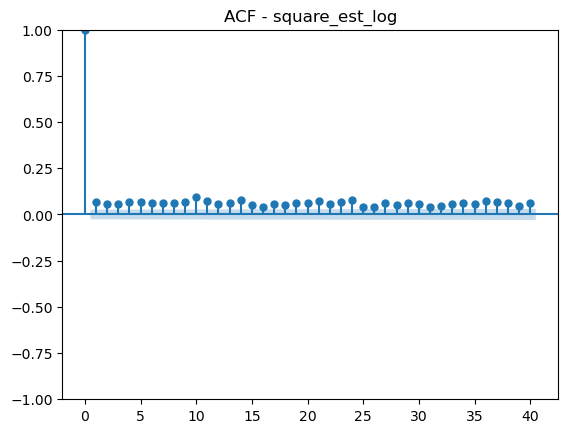

c:\Users\lawor\anaconda3v0\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


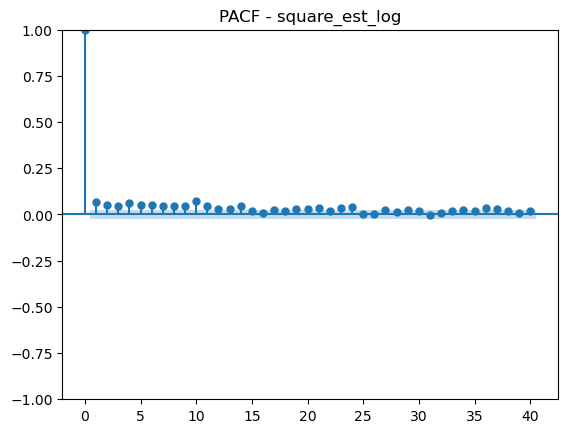

=== parkinson_est_log ===


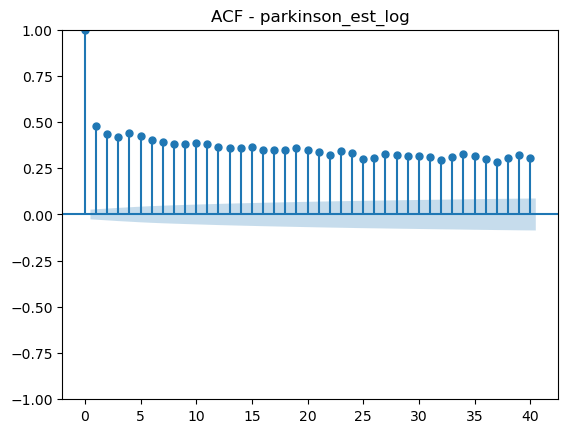

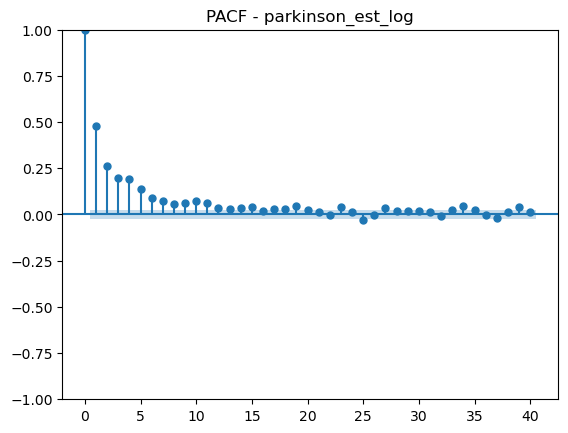

=== gk_est_log ===


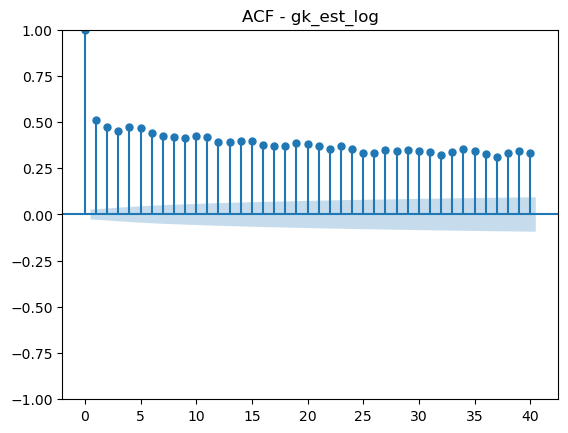

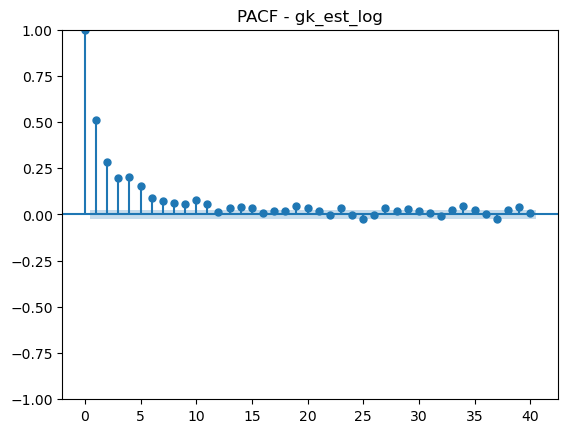

=== rs_est_log ===


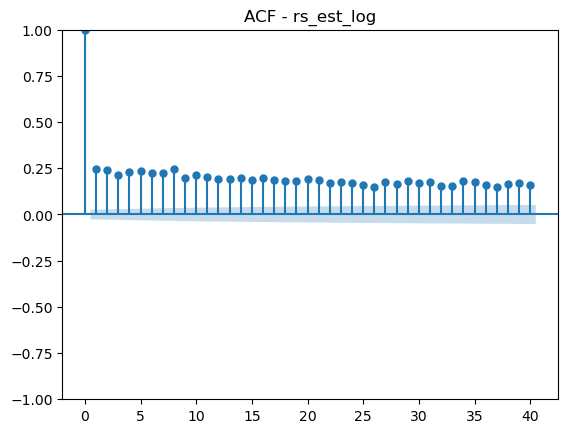

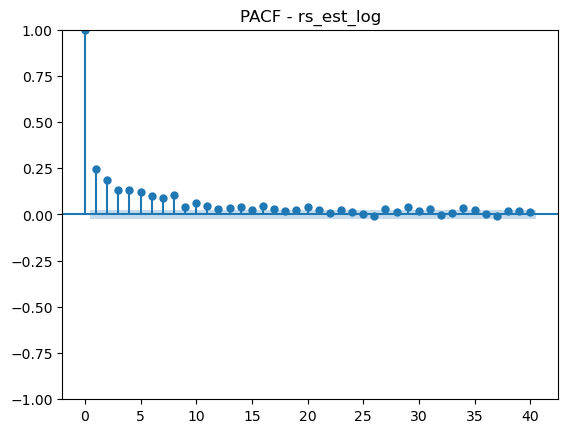

In [21]:
# Plot ACF and PACF for each log-vol estimator
for col in vol_estimator_check.columns:
    print(f"=== {col} ===")
    vol_check.plot_acf(vol_estimator_check[col], nlags=40, title=f"ACF - {col}")
    vol_check.plot_pacf(vol_estimator_check[col], nlags=40, title=f"PACF - {col}")

### Premodel check on the data
- All estimators pass the ADF test, indicating it is mean stationary. Can proceed with HAR model fitting.
- HAR model requires the data to be covariance-stationary, which your ADF result already supports.
- All fail the KPSS test, suggesting that there is trend-stationary / near-unit-root behaviour, which is expected in volatility data case.
- All ACF shows slow decay, indicating long memory.
- PACF has significant spikes up to ~5–15 lags → short-term AR effects + persistent long-term influence.

### What it means in HAR (1,5,22) models?
- HAR(1) → daily dependence (lag 1)
- HAR(5) → weekly average dependence (captures medium decay)
- HAR(22) → monthly average dependence (captures long tail)

In [22]:
y_true_log

Date
2003-01-03   -6.327058
2003-01-06   -5.731042
2003-01-07   -5.085143
2003-01-08   -2.357159
2003-01-09   -6.394209
                ...   
2024-12-20   -3.844518
2024-12-23   -5.406559
2024-12-24   -9.413061
2024-12-26   -4.069927
2024-12-27   -4.126031
Name: Close, Length: 5534, dtype: float64

In [23]:
y_predictors

square_est_log  parkinson_est_log  gk_est_log  rs_est_log
Date                                                                 
2003-01-06       -6.606912          -5.088317   -4.943684   -4.845384
2003-01-07       -6.327058          -5.868129   -5.563108   -5.192428
2003-01-08       -5.731042          -5.499157   -5.550884   -5.561621
2003-01-09       -5.085143          -6.464545   -6.212822   -6.215203
2003-01-10       -2.357159          -4.110049   -4.329164   -4.429030
...                    ...                ...         ...         ...
2024-12-23       -4.812897          -5.414671   -5.190815   -4.897708
2024-12-24       -3.844518          -4.912701   -5.361084   -5.783078
2024-12-26       -5.406559          -4.620756   -5.322553   -6.063504
2024-12-27       -9.413061          -4.984313   -5.347732   -5.615191
2024-12-30       -4.069927          -5.088794   -5.005313   -4.924521

[5534 rows x 4 columns]

In [24]:
comon_idx = y_true_log.index.intersection(y_predictors.index)
y_true_log = y_true_log.loc[comon_idx]
y_predictors = y_predictors.loc[comon_idx]
print(y_true_log)
print(y_predictors)

Date
2003-01-06   -5.731042
2003-01-07   -5.085143
2003-01-08   -2.357159
2003-01-09   -6.394209
2003-01-10   -7.302409
                ...   
2024-12-20   -3.844518
2024-12-23   -5.406559
2024-12-24   -9.413061
2024-12-26   -4.069927
2024-12-27   -4.126031
Name: Close, Length: 5533, dtype: float64
            square_est_log  parkinson_est_log  gk_est_log  rs_est_log
Date                                                                 
2003-01-06       -6.606912          -5.088317   -4.943684   -4.845384
2003-01-07       -6.327058          -5.868129   -5.563108   -5.192428
2003-01-08       -5.731042          -5.499157   -5.550884   -5.561621
2003-01-09       -5.085143          -6.464545   -6.212822   -6.215203
2003-01-10       -2.357159          -4.110049   -4.329164   -4.429030
...                    ...                ...         ...         ...
2024-12-20       -2.835980          -4.699546   -4.442752   -4.463816
2024-12-23       -4.812897          -5.414671   -5.190815   -4.897708


In [25]:
n_total = len(y_predictors)
split_point = int(0.7 * n_total)
#x_variables
train_x = y_predictors.iloc[:split_point]
test_x = y_predictors.iloc[split_point:]

#y_variables
train_y = y_true_log.iloc[:split_point]
test_y = y_true_log.iloc[split_point:]

print("Train X shape:", train_x.shape)
print("Test  X shape:", test_x.shape)
print("Train y shape:", train_y.shape)
print("Test  y shape:", test_y.shape)


Train X shape: (3873, 4)
Test  X shape: (1660, 4)
Train y shape: (3873,)
Test  y shape: (1660,)


In [26]:
window = [252, 504, 756, 1008, 1260]
estimators = ['square_est_log', 'parkinson_est_log', 'gk_est_log', 'rs_est_log']
per_est = {w: {} for w in window}
per_pred = {w: {} for w in window}
per_residual = {w: {} for w in window}
pred_raw_residual = {w: {} for w in window}

df_pred = {}
df_pred_adj = {}
df_residual = {}
df_residual_adj = {}
qlike_loss_df = {}
mspe_loss_df = {}
yhat_var = {}
summary_df = {}
ljung_box_df = {}


for w in window:

  for est in estimators:
    har = HAR_Model(y_log_col=est, exo_col=None)
    x_est = har.features(train_x)
    y_adj = train_y.loc[x_est.index] # log variance
    per_est[w][est] = x_est

    y_pred, resid_pred, residual_raw = har.fit_predict(x_est ,y_adj, window=w)

    per_pred[w][est] = y_pred
    per_residual[w][est] = resid_pred
    pred_raw_residual[w][est] = residual_raw

  df_pred[w] = pd.DataFrame(per_pred[w])
  df_pred_adj[w] = df_pred[w].dropna()
  df_residual[w] = pd.DataFrame(pred_raw_residual[w])
  df_residual_adj[w] = df_residual[w].dropna()
  residual_input = df_residual_adj[w]

  #variance scale
  yhat_var[w] = np.exp(df_pred_adj[w])
  ytrue_var = np.exp(train_y) #variance scale
  common_idx = yhat_var[w].index.intersection(ytrue_var.index)
  yhat = yhat_var[w].loc[common_idx]
  ytrue = ytrue_var.loc[common_idx]

  qlike_loss_df[w] = pd.DataFrame({col: Metric_Evaluation.qlike(ytrue, yhat[col])
                                for col in yhat.columns})
  mspe_loss_df[w]  = pd.DataFrame({col: Metric_Evaluation.mspe(ytrue, yhat[col])
                                for col in yhat.columns})
  summary_df[w] = pd.DataFrame({
    'QLIKE_mean': qlike_loss_df[w].mean(),
    'QLIKE_std':  qlike_loss_df[w].std(),
    'MSPE_mean':  mspe_loss_df[w].mean(),
    'MSPE_std':   mspe_loss_df[w].std()
  }).round(4)

  vol_check = Vol_Est_Check(
      alpha=0.05,
      lb_lags=(10, 20),
      kpss_reg='c',
      kpss_nlags='auto',
      acf_pacf_nlags=40
  )
  ljung_box_df[w] = pd.DataFrame({col: vol_check.ljung_box(residual_input[col])
                              for col in residual_input.columns})

In [27]:
final_summary = pd.concat(summary_df, axis=0)
final_summary.index.name = 'Window'

ljung_box_summary = pd.concat(ljung_box_df, axis=0)
ljung_box_summary.index.name = 'Window'

print(final_summary)
print(ljung_box_summary)


                        QLIKE_mean  QLIKE_std     MSPE_mean      MSPE_std
252  square_est_log        -1.2327     7.9340  2.058109e+17  5.090502e+18
     parkinson_est_log     -1.3857     7.2608  2.256034e+17  5.577652e+18
     gk_est_log            -1.3697     7.3166  2.000294e+17  4.498348e+18
     rs_est_log             1.4364   169.2255  1.767571e+17  3.609573e+18
504  square_est_log        -1.3170     7.5266  1.645765e+17  3.703027e+18
     parkinson_est_log     -1.3930     7.1529  1.406216e+17  2.713727e+18
     gk_est_log            -1.3775     7.1877  1.303830e+17  2.449479e+18
     rs_est_log            -0.2232    62.9934  1.157448e+17  2.078624e+18
756  square_est_log        -1.1623     7.9182  1.431914e+17  2.754593e+18
     parkinson_est_log     -1.3564     7.1079  1.275711e+17  2.305211e+18
     gk_est_log            -1.3383     7.0716  1.227844e+17  2.219798e+18
     rs_est_log             3.7334   276.2895  1.102024e+17  1.909685e+18
1008 square_est_log        -1.0086    

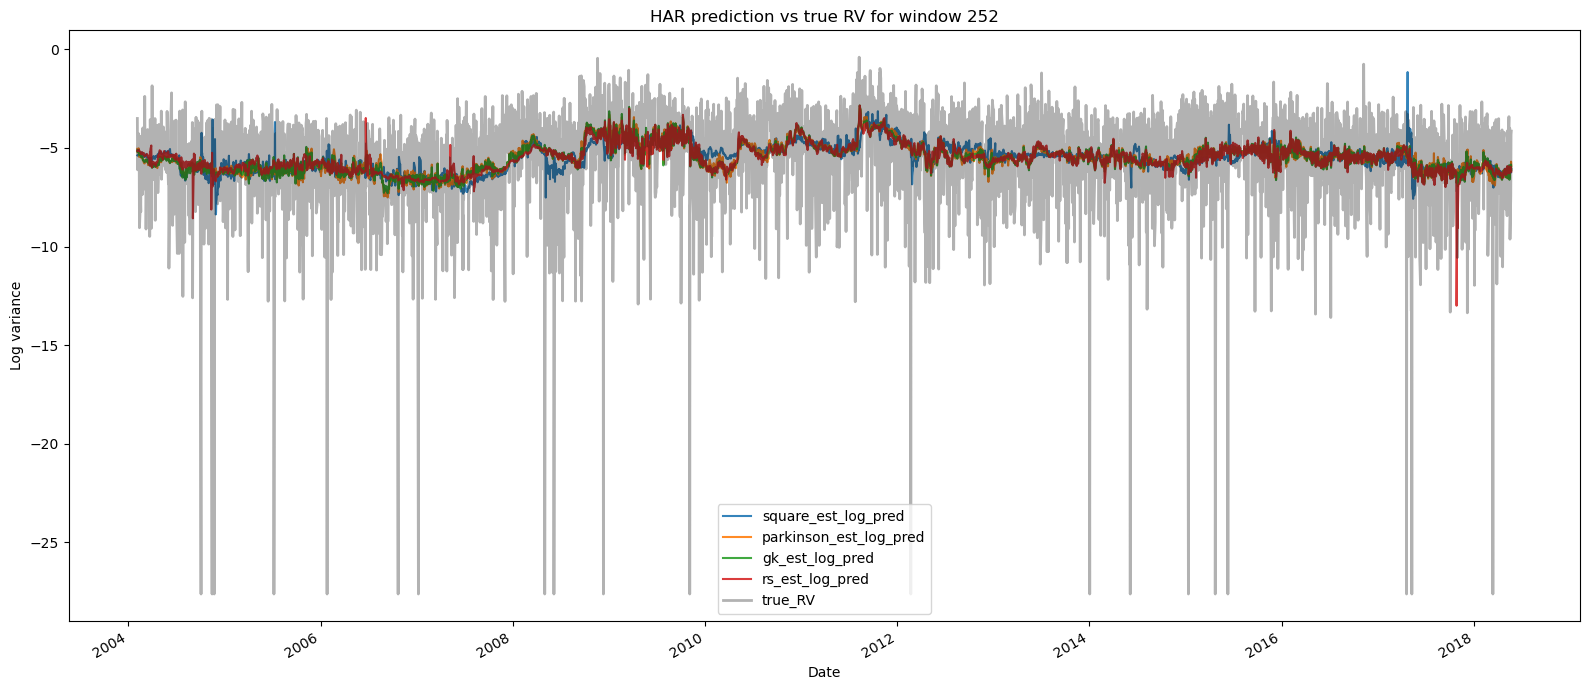

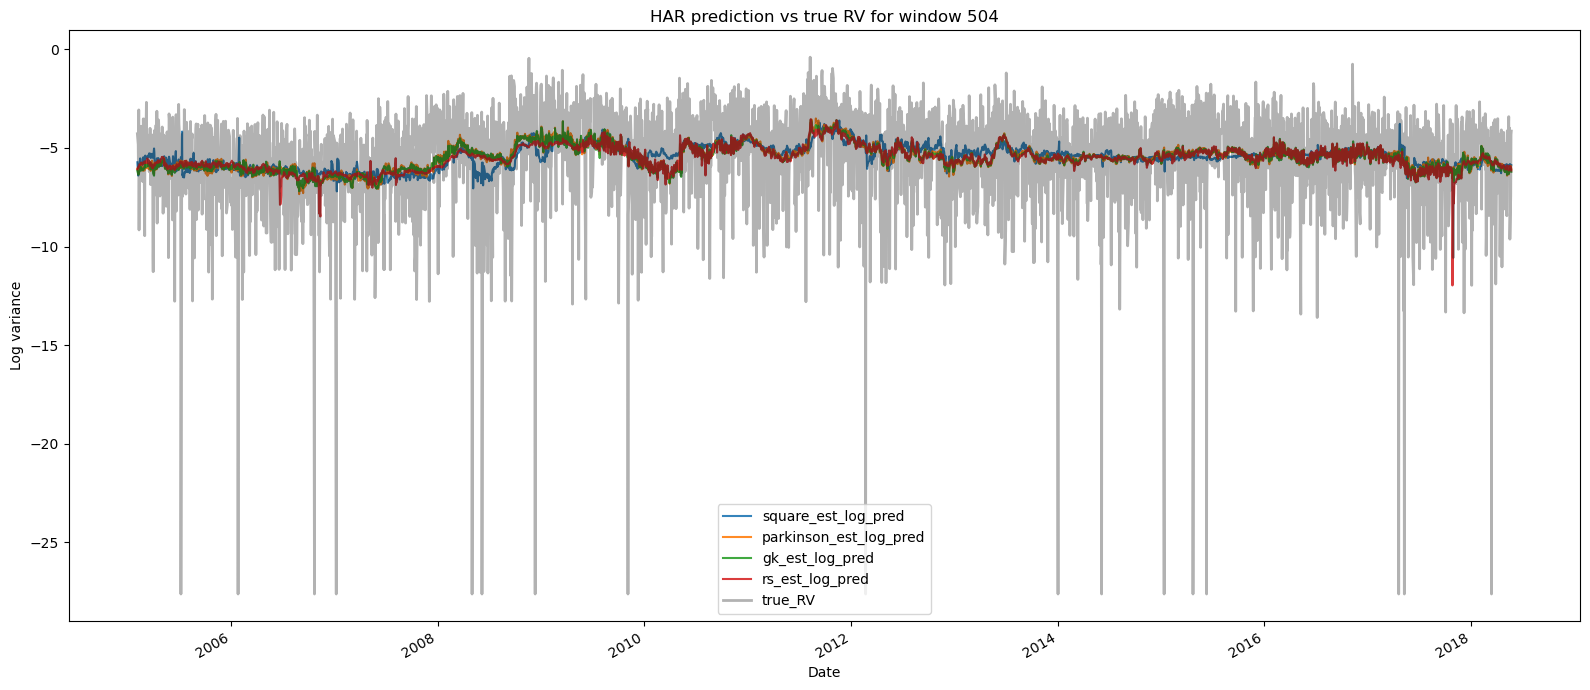

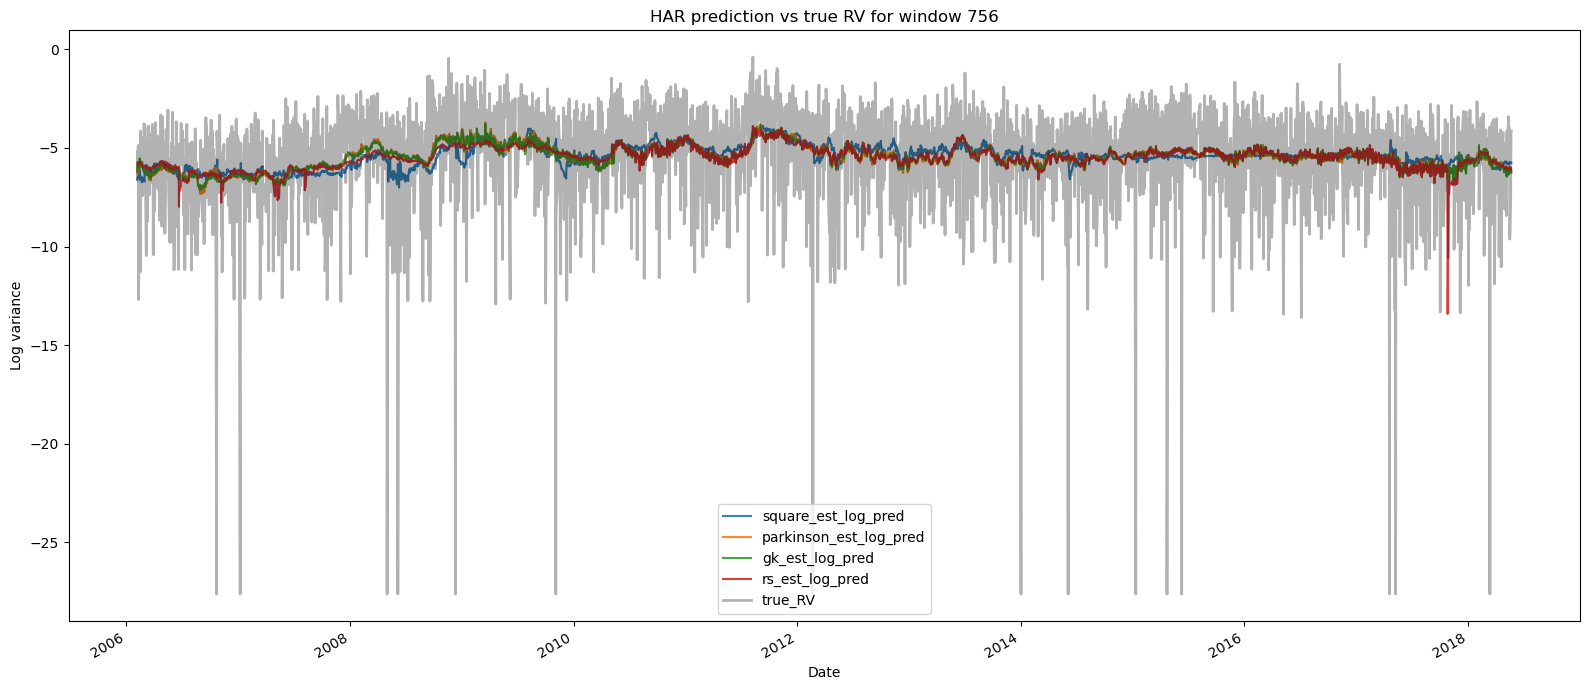

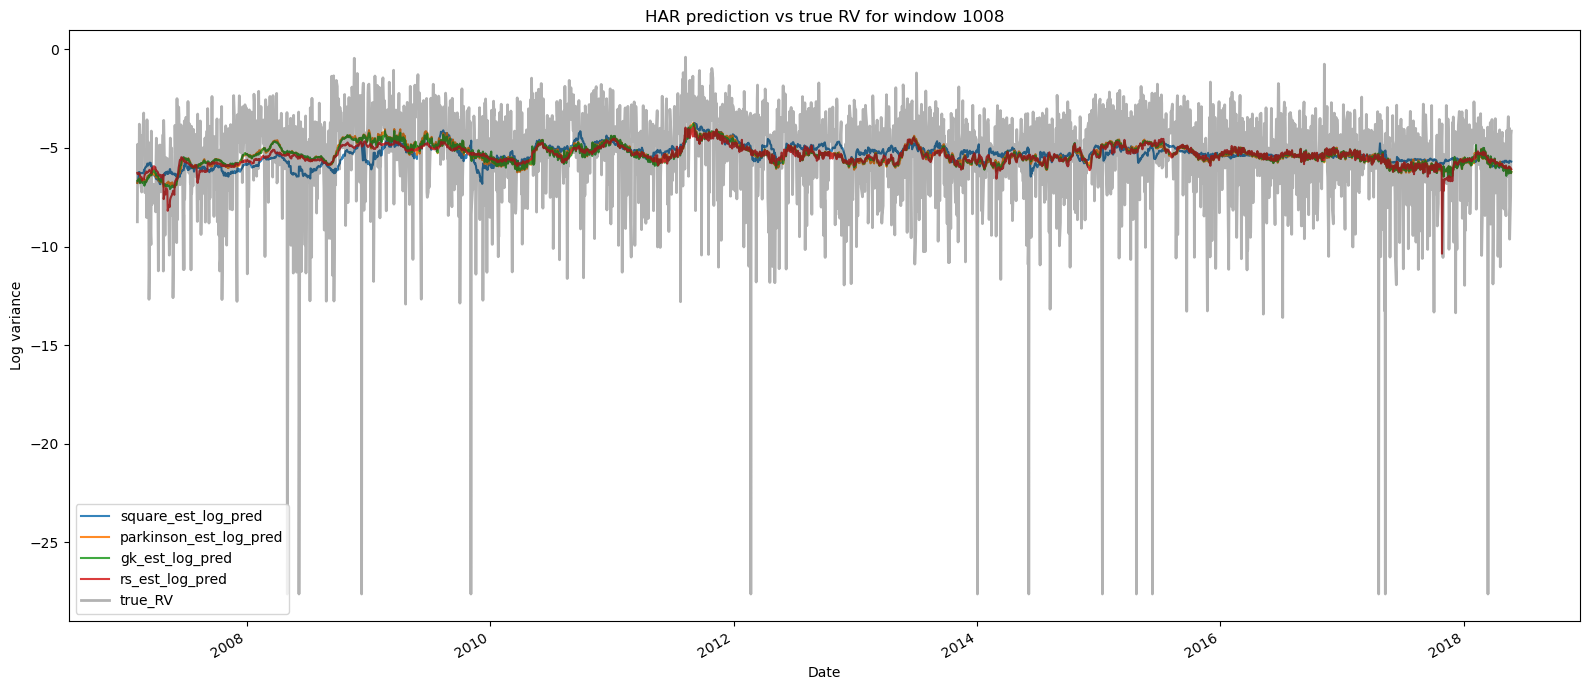

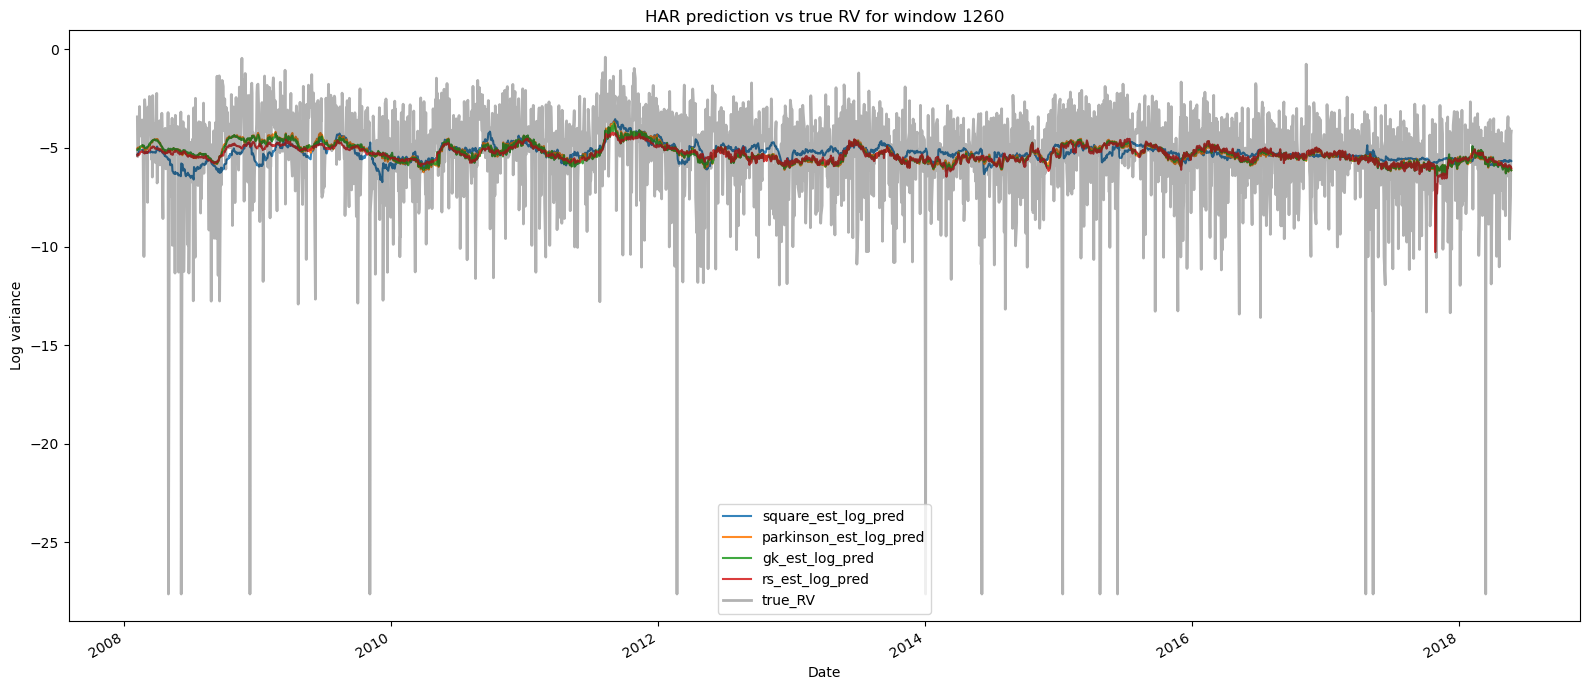

In [28]:
# plot log variance scale
window = [252, 504, 756, 1008, 1260]

for w in window:
  common_idx = df_pred_adj[w].index.intersection( y_adj.index)
  yhat_plot = df_pred_adj[w].loc[common_idx]
  yhat_plot.columns = [f"{col}_pred" for col in yhat_plot.columns]

  ytrue_plot = train_y.loc[common_idx].to_frame(name = 'true_RV')

  plt.figure(figsize=[16,7])
  yhat_plot.plot(ax=plt.gca(), alpha=0.9)
  ytrue_plot.plot(ax=plt.gca(), color='black', linewidth=2, alpha=0.3, label='True RV')

  plt.xlabel("Date")
  plt.ylabel("Log variance")
  plt.legend()
  plt.title(f"HAR prediction vs true RV for window {w}")
  plt.tight_layout()
  plt.show()


<Figure size 1600x700 with 0 Axes>

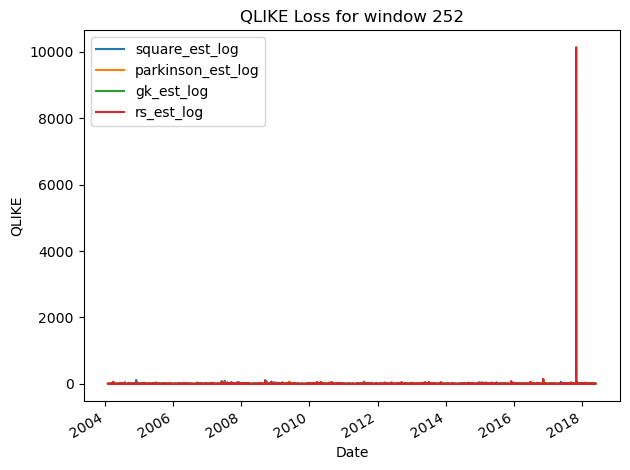

<Figure size 1600x700 with 0 Axes>

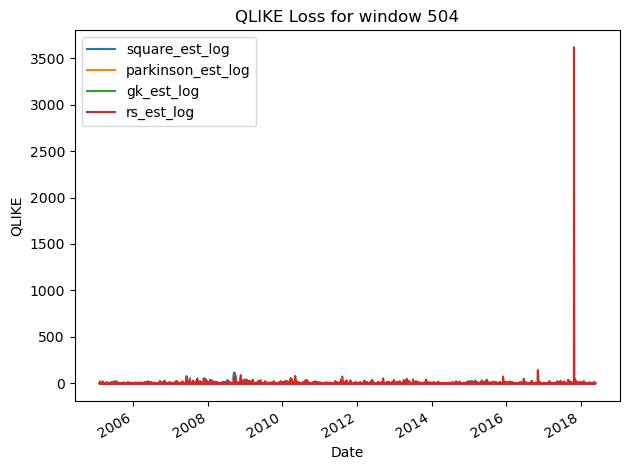

<Figure size 1600x700 with 0 Axes>

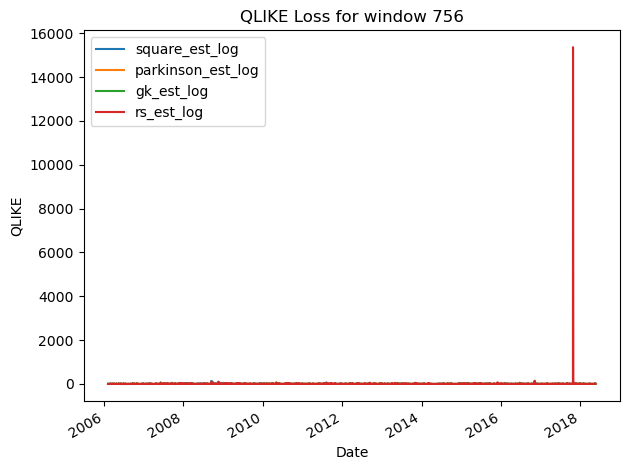

<Figure size 1600x700 with 0 Axes>

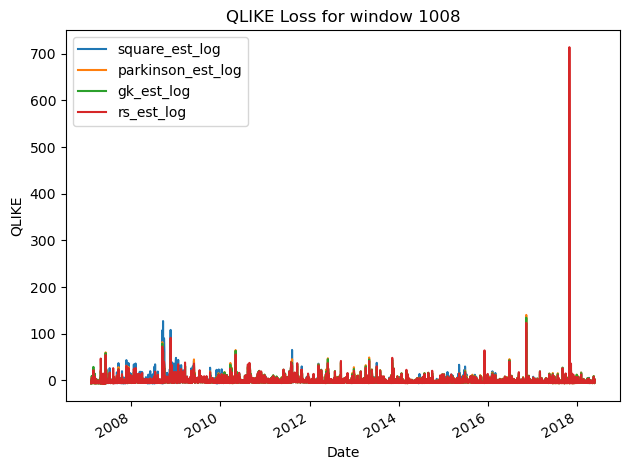

<Figure size 1600x700 with 0 Axes>

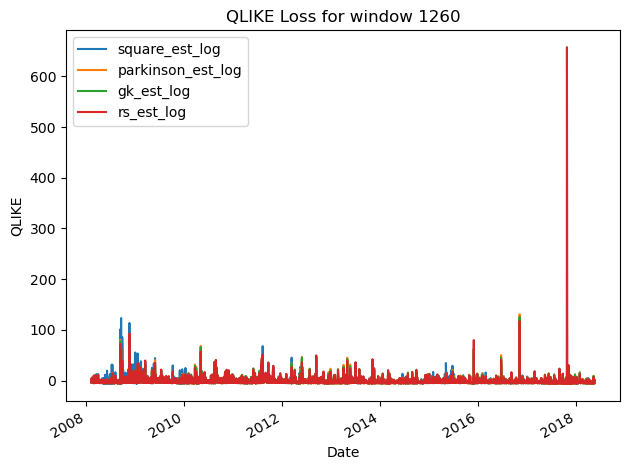

In [29]:
# IN variance scale
for w in window:
  plt.figure(figsize=[16,7])
  qlike_loss_df[w][['square_est_log', 'parkinson_est_log', 'gk_est_log', 'rs_est_log']].plot()
  plt.xlabel("Date")
  plt.ylabel("QLIKE")
  plt.legend()
  plt.title(f"QLIKE Loss for window {w}")
  plt.tight_layout()
  plt.show()


<Figure size 1600x700 with 0 Axes>

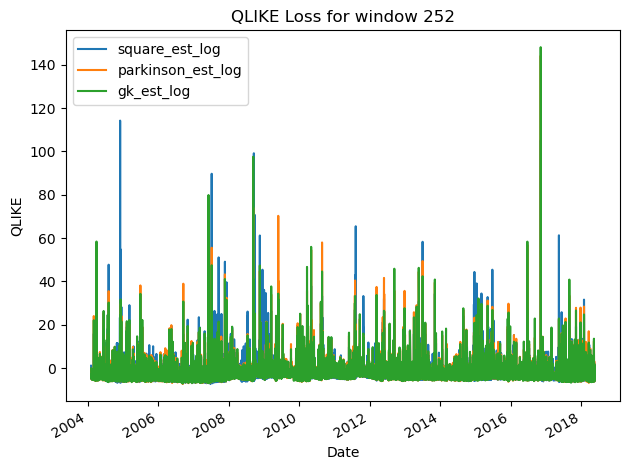

<Figure size 1600x700 with 0 Axes>

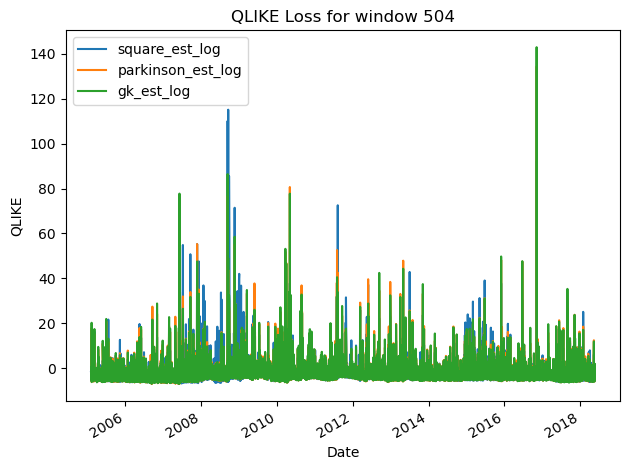

<Figure size 1600x700 with 0 Axes>

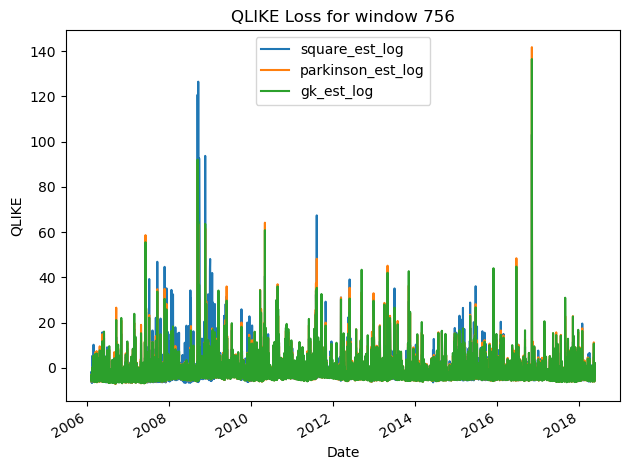

<Figure size 1600x700 with 0 Axes>

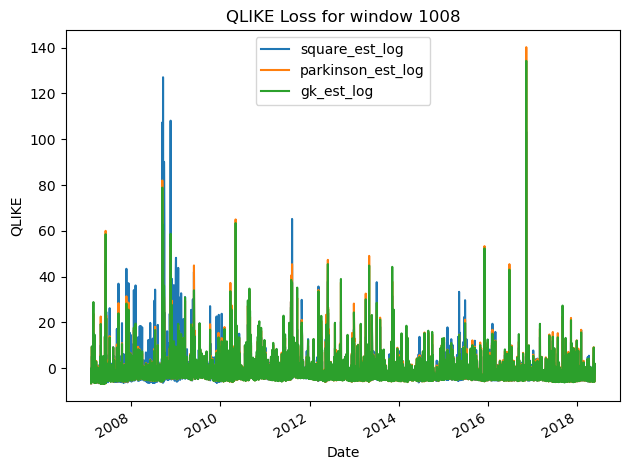

<Figure size 1600x700 with 0 Axes>

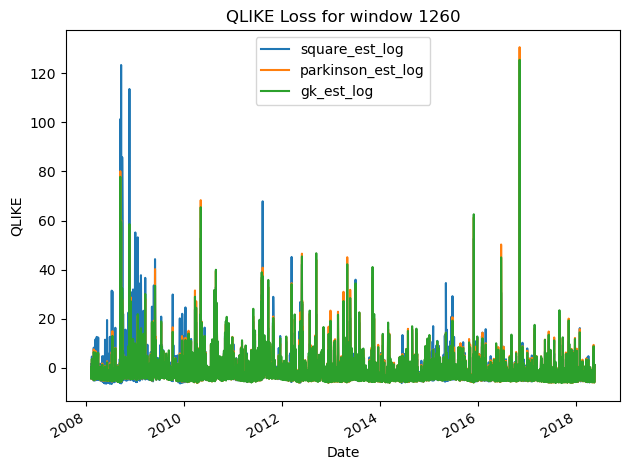

In [30]:
# IN variance scale
for w in window:
  plt.figure(figsize=[16,7])
  qlike_loss_df[w][['square_est_log', 'parkinson_est_log', 'gk_est_log']].plot()
  plt.xlabel("Date")
  plt.ylabel("QLIKE")
  plt.legend()
  plt.title(f"QLIKE Loss for window {w}")
  plt.tight_layout()
  plt.show()

<Figure size 1600x700 with 0 Axes>

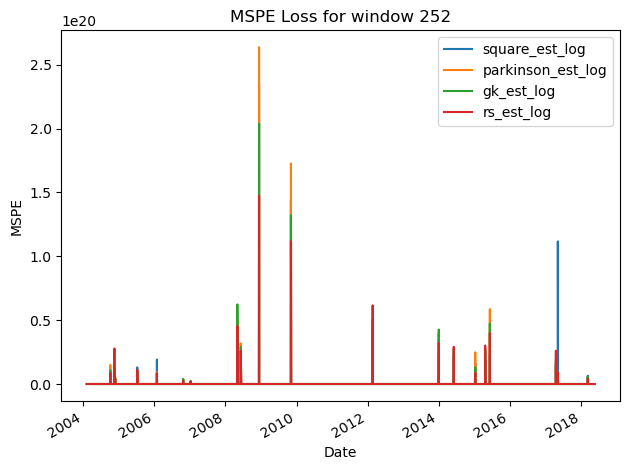

<Figure size 1600x700 with 0 Axes>

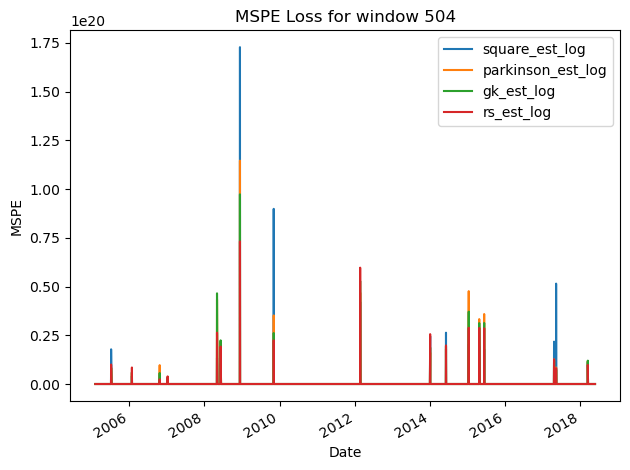

<Figure size 1600x700 with 0 Axes>

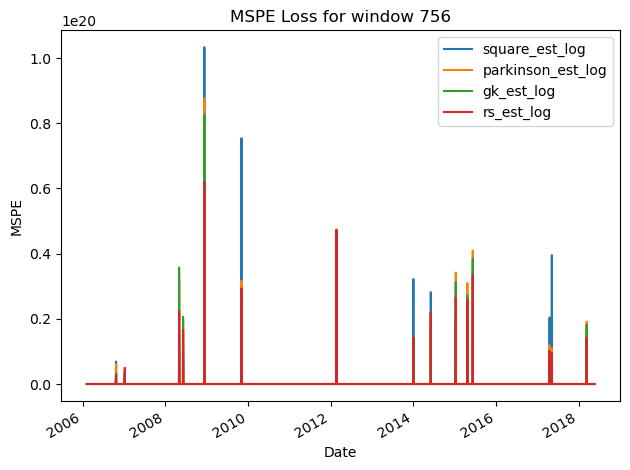

<Figure size 1600x700 with 0 Axes>

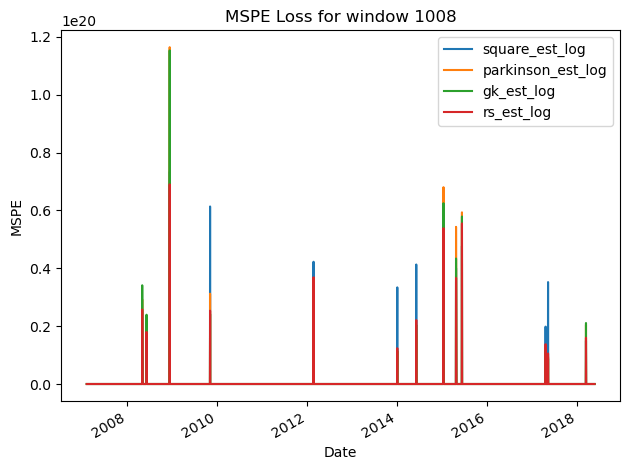

<Figure size 1600x700 with 0 Axes>

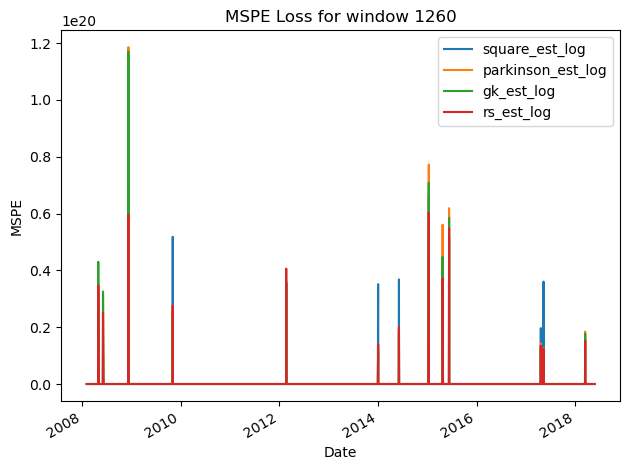

In [31]:
#in variance scale
for w in window:
  plt.figure(figsize=[16,7])
  mspe_loss_df[w][['square_est_log', 'parkinson_est_log', 'gk_est_log', 'rs_est_log']].plot()
  plt.xlabel("Date")
  plt.ylabel("MSPE")
  plt.legend()
  plt.title(f"MSPE Loss for window {w}")
  plt.tight_layout()
  plt.show()

### Findings:
- RS estimator perform the worst for all windows. Henec RS estimator is removed from the ensemble model.

### Ensemble Model - Train/Val Set

In [32]:
# creating ensemble model for all 5 windows
window = [252, 504, 756, 1008, 1260]

qlike_ensemble = {}
wts = {}
weight_ensemble = {}
yhat_ensemble = {}
yhat_enfinal = {}
log_yhat_enfinal = {}
log_yhat_ensemble = {}
residual_ensemble = {}
qlike_loss_ensemble = {}
mspe_loss_ensemble = {}
summary_ensemble = {}
ljung_box_ensemble = {}

for w in window:

  #compute weightage
  ensemble_model = EnsembleModel(estimators=None)
  qlike_ensemble[w] = summary_df[w]['QLIKE_mean']
  weight_ensemble[w] = ensemble_model.compute_weightage(qlike_ensemble[w])
  yhat_ensemble[w] = (np.exp(df_pred_adj[w]))

  wts[w] = pd.Series(weight_ensemble[w], index=yhat_ensemble[w].columns, dtype=float)

  yhat_enfinal[w] = yhat_ensemble[w].dot(wts[w])
  log_yhat_enfinal[w] = np.log(  yhat_enfinal[w])

  common_idx = log_yhat_enfinal[w].index.intersection(y_adj.index)
  log_yhat_ensemble[w] = log_yhat_enfinal[w].loc[common_idx] #log-variance
  log_ytrue_ensemble = y_adj.loc[common_idx] #log-variance
  ytrue_ensemble = ytrue_var.loc[common_idx] # variance

  residual_ensemble[w] = log_yhat_ensemble[w] - log_ytrue_ensemble

  qlike_loss_ensemble[w] = pd.DataFrame(Metric_Evaluation.qlike(ytrue_ensemble, yhat_enfinal[w]))
  mspe_loss_ensemble[w]  = pd.DataFrame(Metric_Evaluation.mspe(ytrue_ensemble, yhat_enfinal[w]))

  summary_ensemble[w] = pd.DataFrame({
    'QLIKE_mean': qlike_loss_ensemble[w].mean(),
    'QLIKE_std':  qlike_loss_ensemble[w].std(),
    'MSPE_mean':  mspe_loss_ensemble[w].mean(),
    'MSPE_std':   mspe_loss_ensemble[w].std()
  }).round(4)

  vol_check = Vol_Est_Check(
      alpha=0.05,
      lb_lags=(10, 20),
      kpss_reg='c',
      kpss_nlags='auto',
      acf_pacf_nlags=40
  )
  ljung_box_ensemble[w] = pd.DataFrame(vol_check.ljung_box(residual_ensemble[w]))

In [33]:
for w in window:
    print(w, wts[w].round(4))

252 square_est_log       0.3333
parkinson_est_log    0.3333
gk_est_log           0.3333
rs_est_log           0.0000
dtype: float64
504 square_est_log       0.25
parkinson_est_log    0.25
gk_est_log           0.25
rs_est_log           0.25
dtype: float64
756 square_est_log       0.3333
parkinson_est_log    0.3333
gk_est_log           0.3333
rs_est_log           0.0000
dtype: float64
1008 square_est_log       0.25
parkinson_est_log    0.25
gk_est_log           0.25
rs_est_log           0.25
dtype: float64
1260 square_est_log       0.25
parkinson_est_log    0.25
gk_est_log           0.25
rs_est_log           0.25
dtype: float64


In [34]:
final_summary_ensemble = pd.concat(summary_ensemble, axis=0)
final_summary_ensemble.index.name = 'Window'

lb_ensemble_final = pd.concat(ljung_box_ensemble, axis=0)
lb_ensemble_final.index.name = 'Window'

print(final_summary_ensemble)
print(lb_ensemble_final)

        QLIKE_mean  QLIKE_std     MSPE_mean      MSPE_std
252  0     -1.5051     6.8914  2.046682e+17  4.913127e+18
504  0     -1.4868     6.7830  1.333734e+17  2.565517e+18
756  0     -1.4128     6.9398  1.278307e+17  2.314621e+18
1008 0     -1.2936     7.0183  1.582685e+17  2.782611e+18
1260 0     -1.2731     6.9952  1.813586e+17  2.999385e+18
        lb_stat_10   lb_p_10  lb_stat_20   lb_p_20  white_noise_flag  \
252  0    8.950768  0.536782   17.001837  0.652854              True   
     1    8.950768  0.536782   17.001837  0.652854              True   
504  0    7.498695  0.677674   15.556942  0.743702              True   
     1    7.498695  0.677674   15.556942  0.743702              True   
756  0    8.050222  0.623931   14.407836  0.809231              True   
     1    8.050222  0.623931   14.407836  0.809231              True   
1008 0    9.242909  0.509216   14.228871  0.818705              True   
     1    9.242909  0.509216   14.228871  0.818705              True   
1260

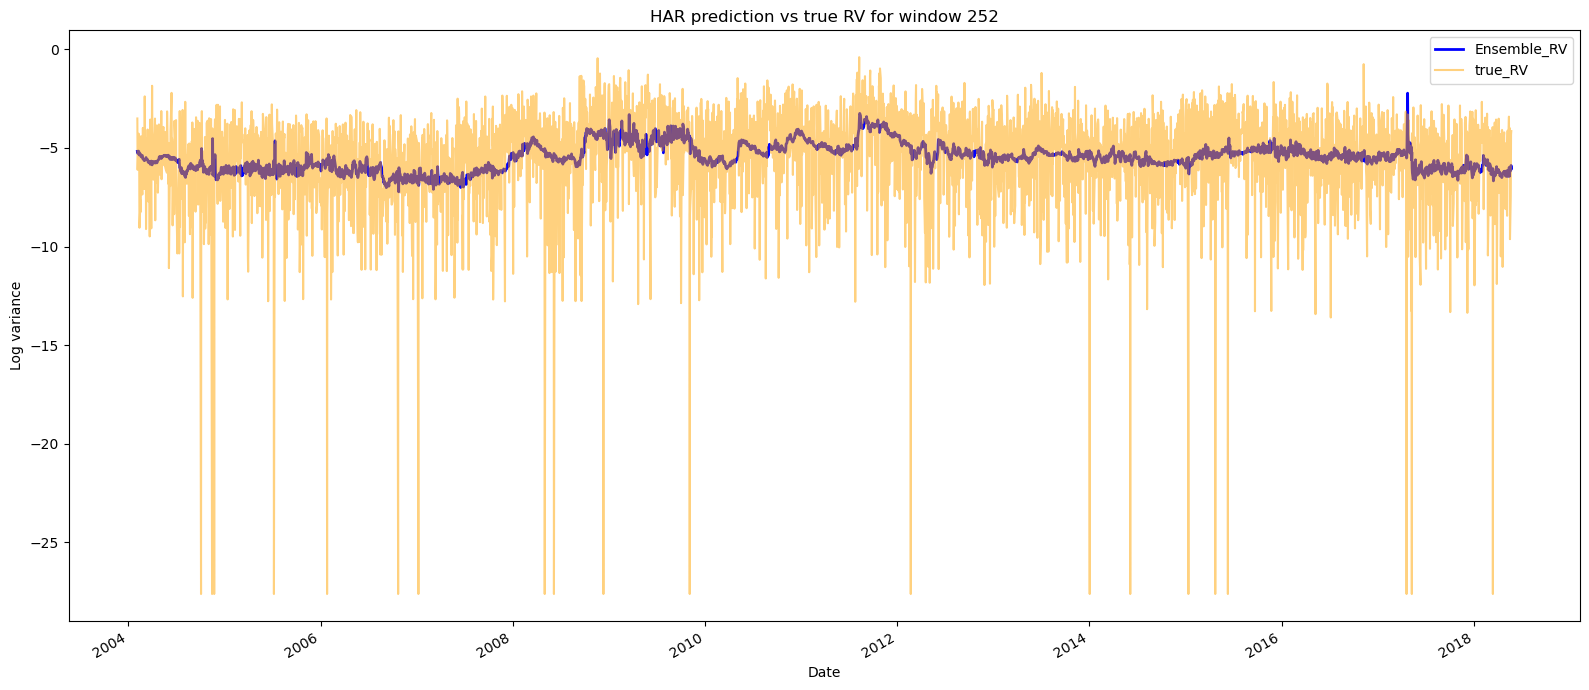

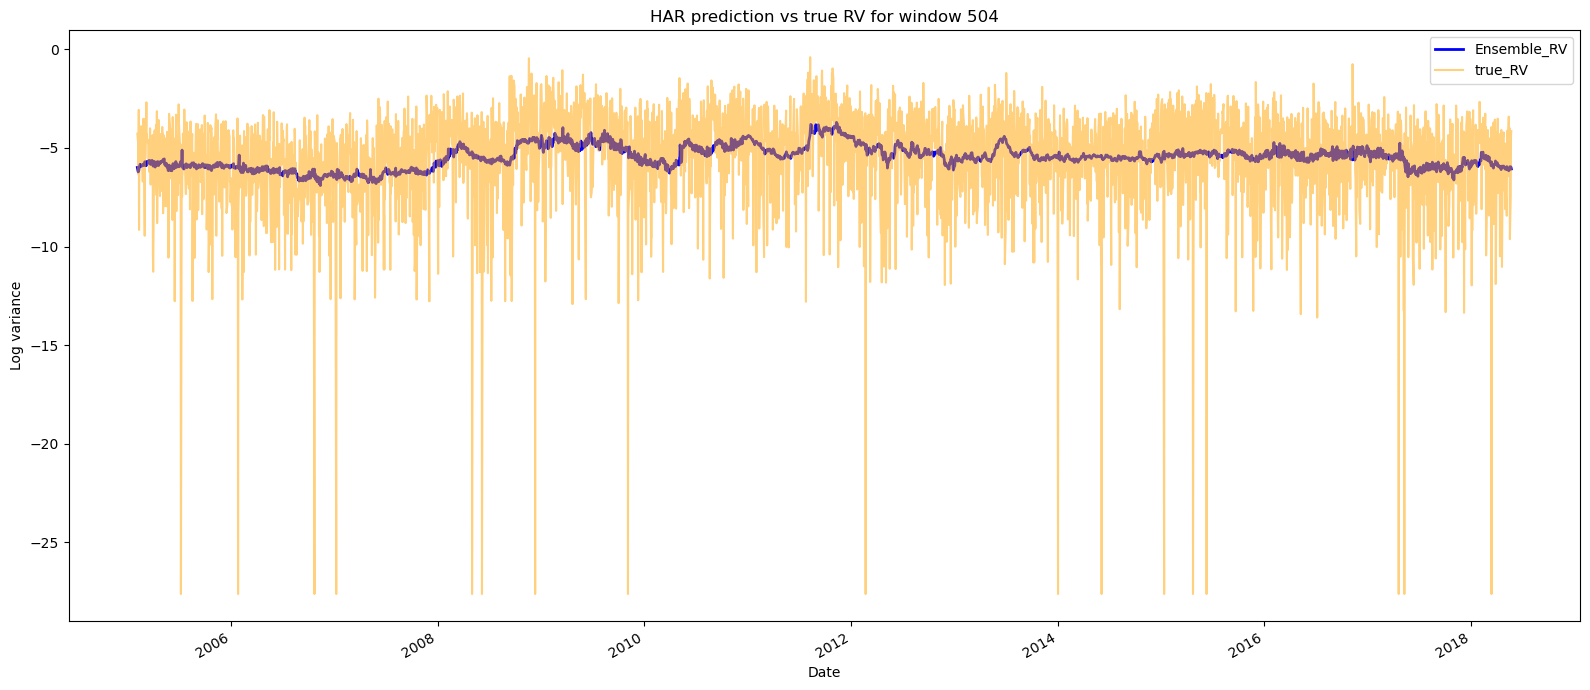

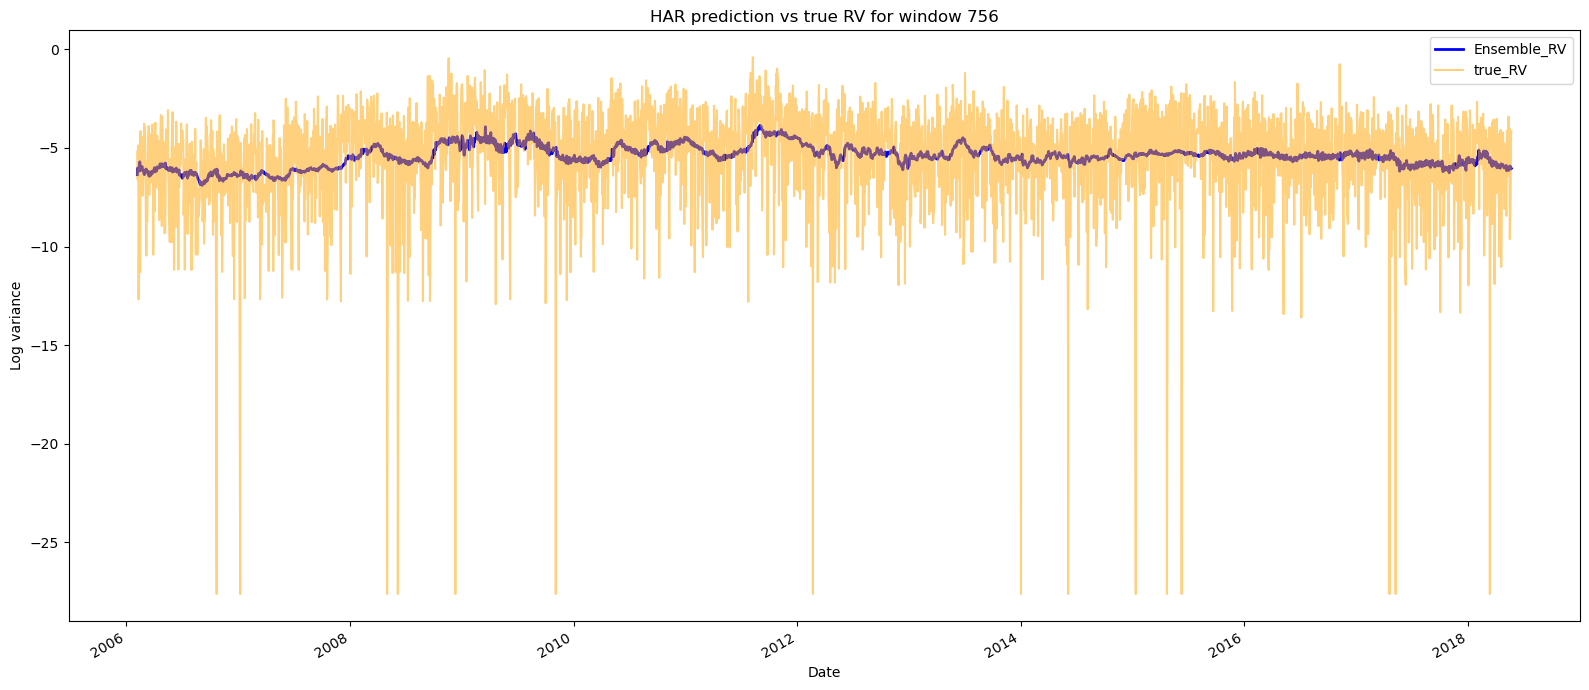

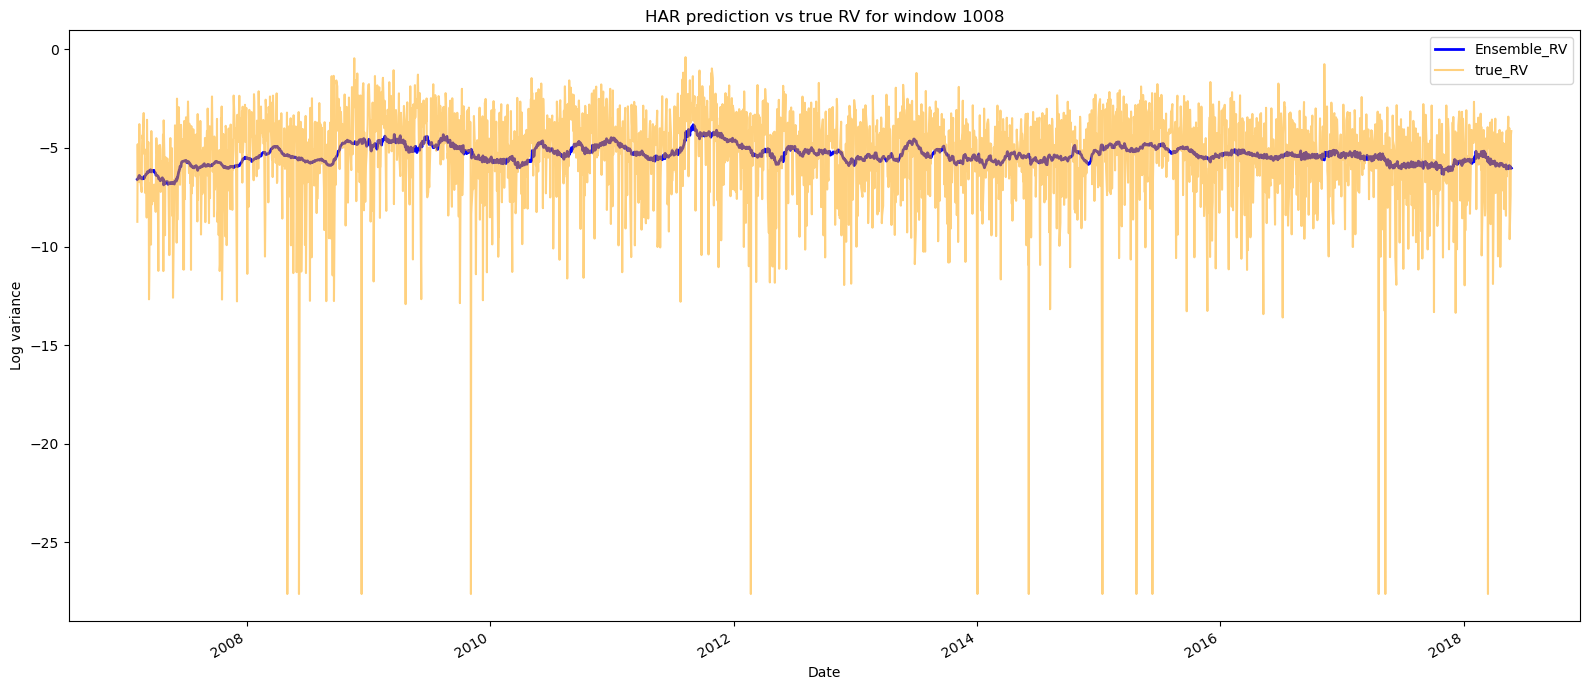

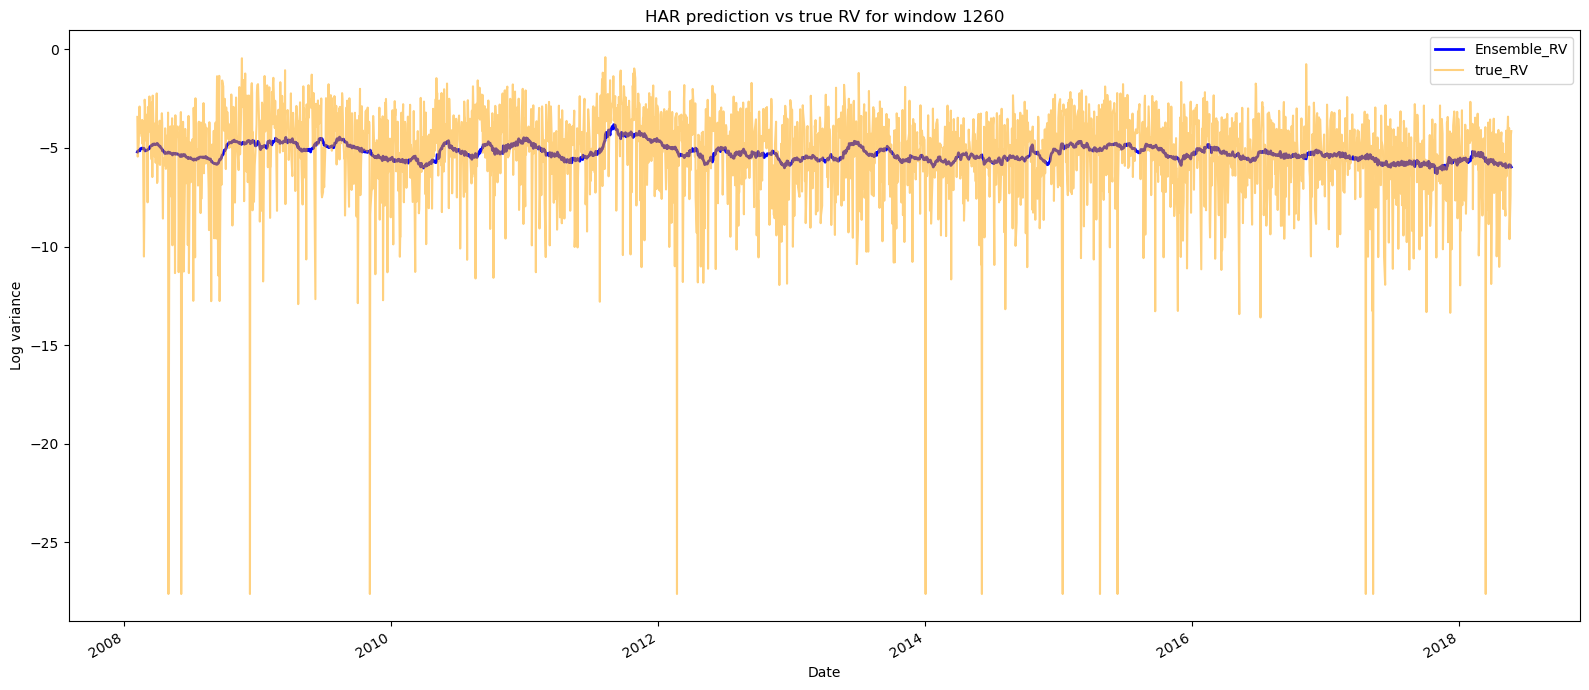

In [35]:
# plot log variance scale
window = [252, 504, 756, 1008, 1260]
for w in window:
  common_idx = log_yhat_enfinal[w].index.intersection(y_adj.index)
  yhat_plot = log_yhat_enfinal[w].loc[common_idx].to_frame(name = 'Ensemble_RV') #log-variance
  ytrue_plot = y_adj.loc[common_idx].to_frame(name = 'true_RV') #log-variance

  y_plot = pd.concat([yhat_plot, ytrue_plot], axis = 1)

  fig, ax = plt.subplots(figsize=(16, 7))
  yhat_plot.plot(ax=ax, color='blue', linewidth=2, label='Ensemble_RV')
  ytrue_plot.plot(ax=ax, color='orange', linewidth=1.5, alpha=0.5, label='true_RV')
  plt.xlabel("Date")
  plt.ylabel("Log variance")
  plt.legend()
  plt.title(f"HAR prediction vs true RV for window {w}")
  plt.tight_layout()
  plt.show()

<Figure size 1600x700 with 0 Axes>

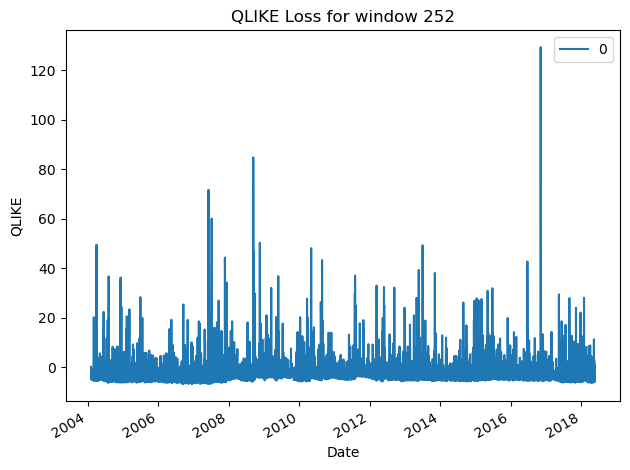

<Figure size 1600x700 with 0 Axes>

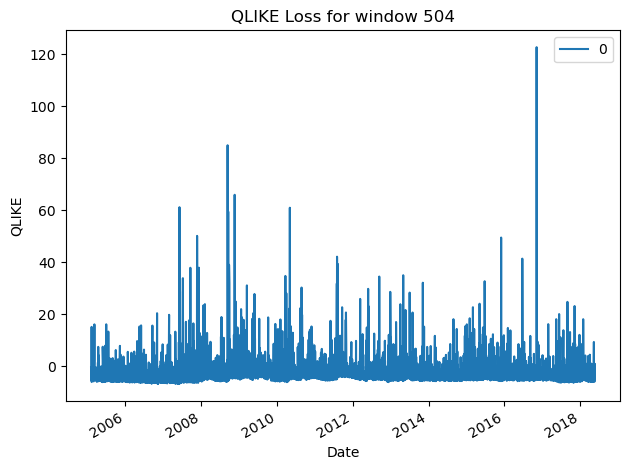

<Figure size 1600x700 with 0 Axes>

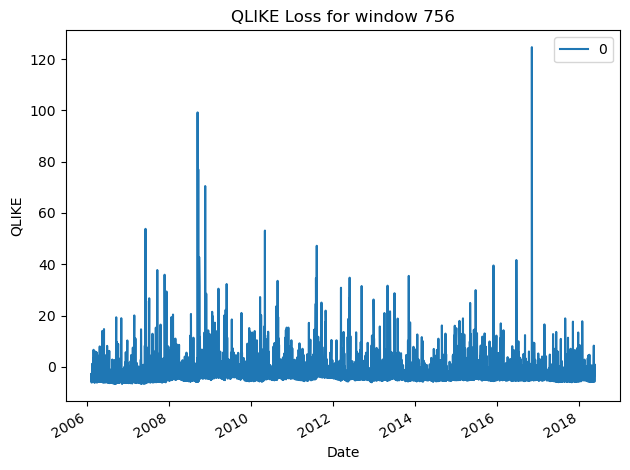

<Figure size 1600x700 with 0 Axes>

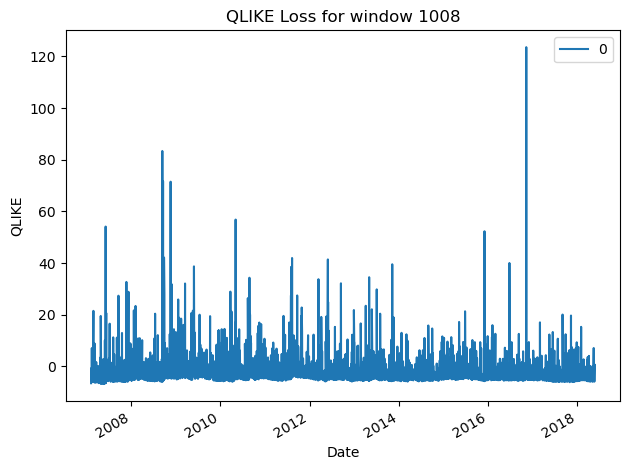

<Figure size 1600x700 with 0 Axes>

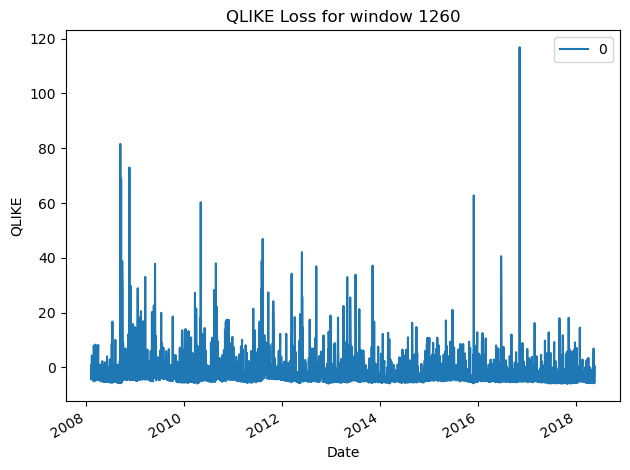

In [36]:
# IN variance scale
for w in window:
  plt.figure(figsize=[16,7])
  qlike_loss_ensemble[w].plot()
  plt.xlabel("Date")
  plt.ylabel("QLIKE")
  plt.title(f"QLIKE Loss for window {w}")
  plt.tight_layout()
  plt.show()


<Figure size 1600x700 with 0 Axes>

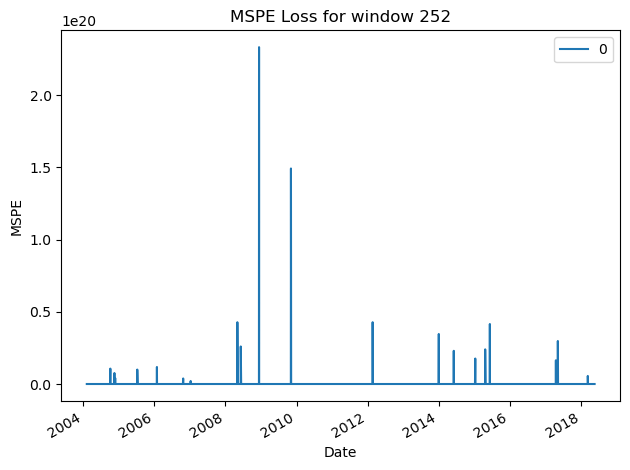

<Figure size 1600x700 with 0 Axes>

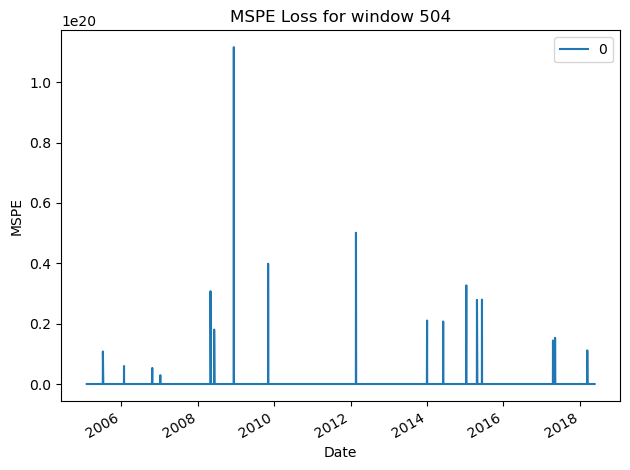

<Figure size 1600x700 with 0 Axes>

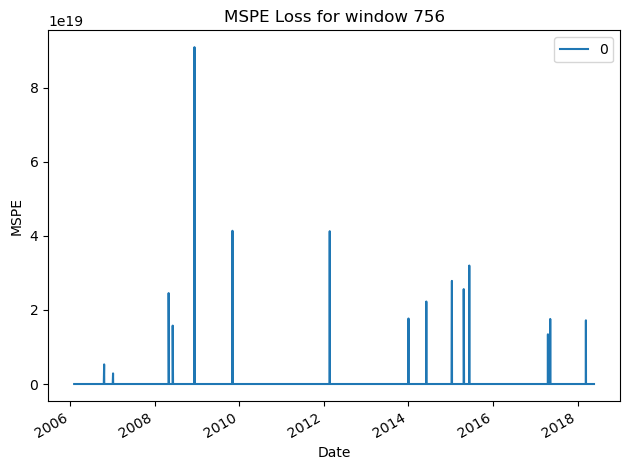

<Figure size 1600x700 with 0 Axes>

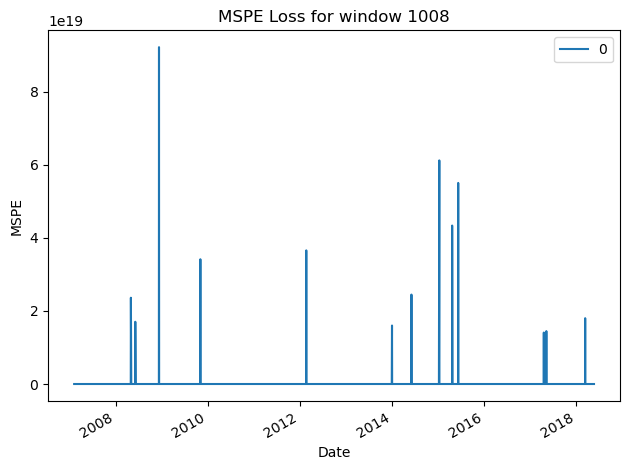

<Figure size 1600x700 with 0 Axes>

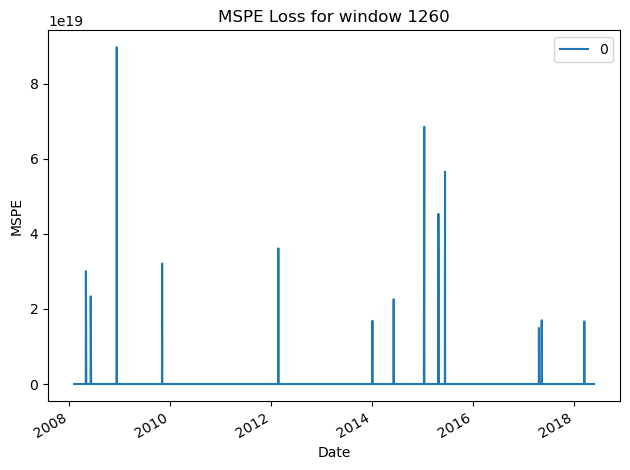

In [37]:
#in variance scale
for w in window:
  plt.figure(figsize=[16,7])
  mspe_loss_ensemble[w].plot()
  plt.xlabel("Date")
  plt.ylabel("MSPE")
  plt.legend()
  plt.title(f"MSPE Loss for window {w}")
  plt.tight_layout()
  plt.show()

=== 252 ===


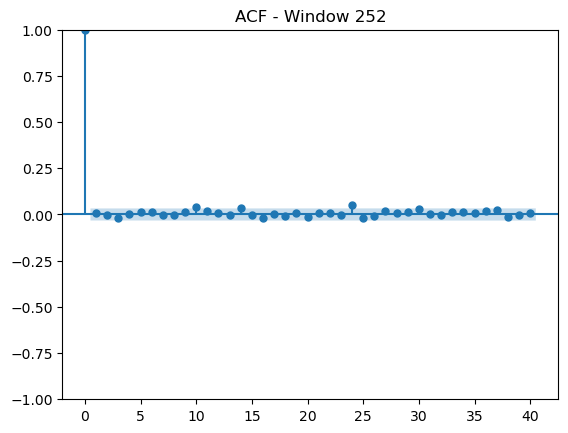

c:\Users\lawor\anaconda3v0\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


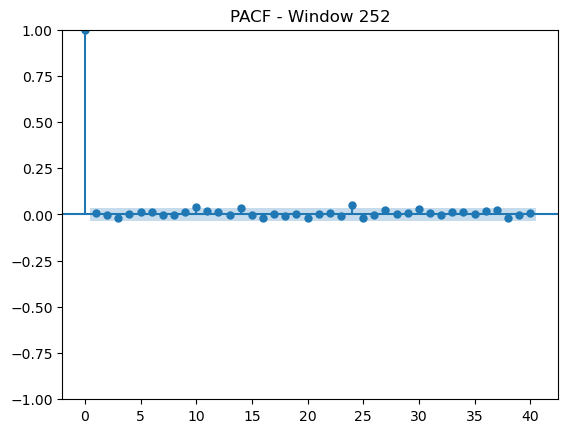

=== 504 ===


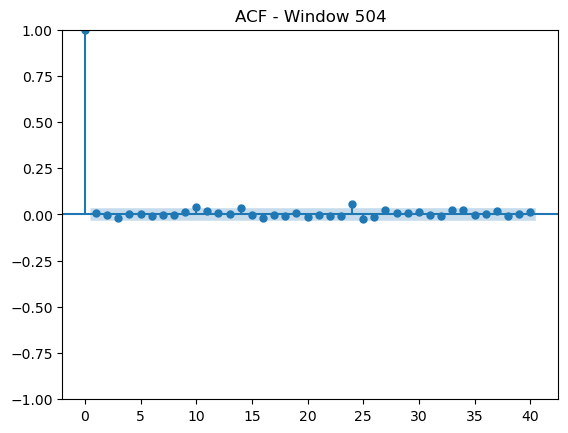

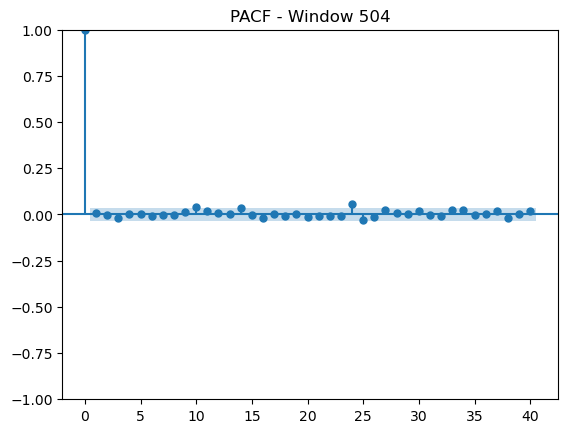

=== 756 ===


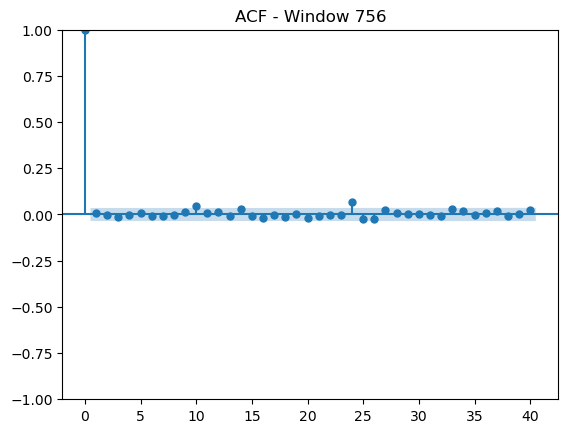

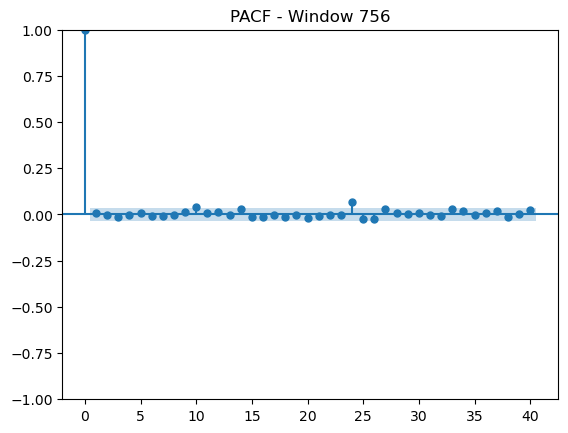

=== 1008 ===


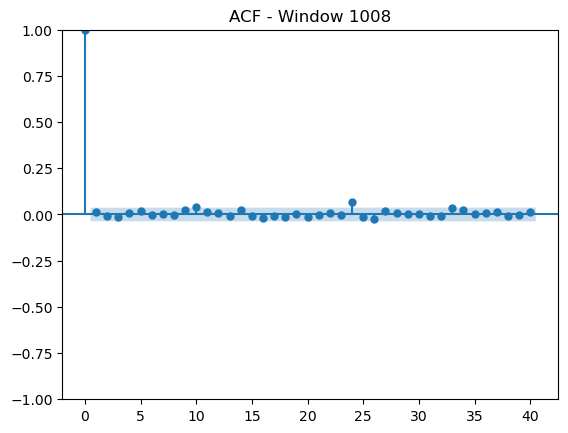

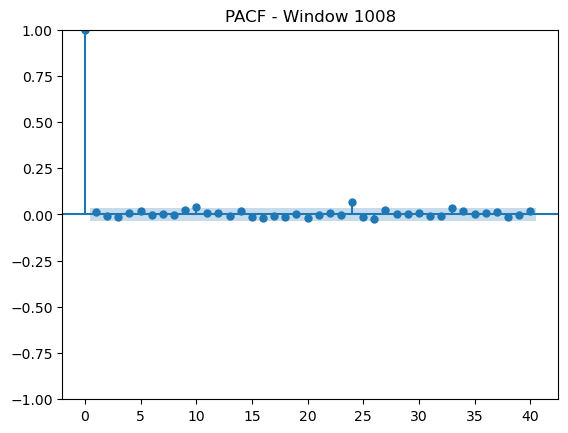

=== 1260 ===


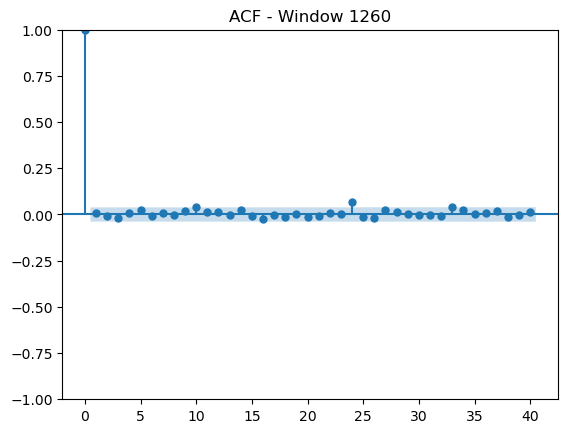

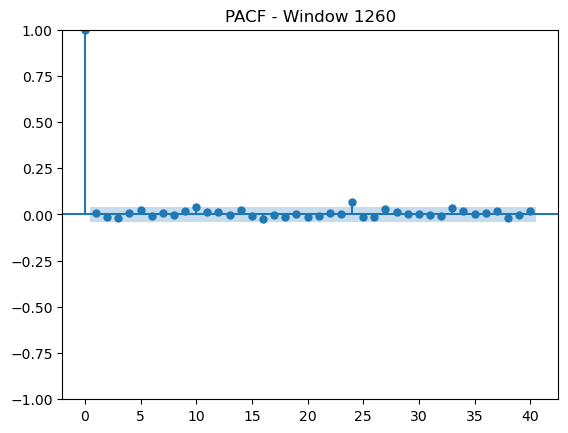

In [38]:
# plot acf and pacf
for w in window:
    print(f"=== {w} ===")
    vol_check.plot_acf(residual_ensemble[w], nlags=40, title=f"ACF - Window {w}")
    vol_check.plot_pacf(residual_ensemble[w], nlags=40, title=f"PACF - Window {w}")



## Evaluation from the ensemble model
- Windows = [252, 504, 756, 1008, 1260]
- Overall forecast calibration (QLIKE) : 252 perform best
- Raw forecast error magnitude (MSPE): 504 perform best
- Ljung box test: All windows passed with 756/1008 windows showing the highest p-values, indicating lesser degree of autocorrelation
- PACF and ACF plots for all windows: No significant autocorrelataion beyond lag 0. Residuals behave like white noise. Indication of the ability to capture the volatility dynamics.
- Hence windows 504 and 756 will run through the DM test to check for pairwise statistical validation (Test whether the difference in predictive loss is statistically significant)

- Ensemble generally outperforms individual estimators in QLIKE, MSPE, volatility/stability.

In [39]:
#window = [504, 756]
loss1 = qlike_loss_ensemble[504]
loss2 = qlike_loss_ensemble[756]
common_idx = loss2.index.intersection( loss1.index)
loss2_adj = loss2.loc[common_idx]
loss1_adj = loss1.loc[common_idx]

DM_test_results = Metric_Evaluation.DM_test(loss1_adj,
                                            loss2_adj,
                                            model1_name='Window_504',
                                            model2_name='Window_756'
                                            )
print(DM_test_results)

# p value = 0.8222 >0.05, fail to reject Ho of equal predictive accuracy.
#indicates no statistically significant difference in predictive accuracy between window 504 and 756.
# Therefore, either window may be used, and selection can be based on secondary metrics or practical considerations.

(0.7837057592079465, 0.4332127824086056, {'Better model': 'None (No significant difference)', 'Significant': False, 'Alpha': 0.05, 'Observations': 3096})


In [40]:
for w in window:
    print(f'\n Window {w}')
    a = qlike_loss_ensemble[w].describe()
    print(a)


 Window 252
                 0
count  3600.000000
mean     -1.505086
std       6.891381
min      -6.849481
25%      -5.029524
50%      -3.769858
75%      -0.693948
max     129.404652

 Window 504
                 0
count  3348.000000
mean     -1.486804
std       6.783027
min      -6.742274
25%      -5.023089
50%      -3.707341
75%      -0.575080
max     122.742290

 Window 756
                 0
count  3096.000000
mean     -1.412849
std       6.939819
min      -6.711551
25%      -4.998540
50%      -3.680672
75%      -0.537686
max     124.646486

 Window 1008
                 0
count  2844.000000
mean     -1.293553
std       7.018335
min      -6.786694
25%      -4.899434
50%      -3.624986
75%      -0.352778
max     123.580586

 Window 1260
                 0
count  2592.000000
mean     -1.273062
std       6.995248
min      -6.080105
25%      -4.832407
50%      -3.565078
75%      -0.385629
max     116.909850


## HAR-X model
- include other variables apart from the historical data

In [41]:
# Read into DataFrame - exogeneous variables
IV_y_values = pd.read_csv('MOVE_index.csv')
Fed_funds = pd.read_csv('FedFunds.csv')
UST_10Y = pd.read_csv('UST10Y.csv')
HYOAS = pd.read_csv('HYOAS.csv')
NFCI = pd.read_csv('NFCI.csv')
Termspread = pd.read_csv('TermSpread_10Y_2Y.csv')
vix = pd.read_csv('VIX.csv')
Breakeven_10Y = pd.read_csv('Breakeven10Y.csv')

In [42]:
exo_variables = [UST_10Y, HYOAS, Termspread, vix, Breakeven_10Y]

for i, df in enumerate(exo_variables):
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date', inplace=True)

In [43]:
Breakeven_10Y

Breakeven10Y
Date                    
2003-01-02          1.64
2003-01-03          1.62
2003-01-06          1.63
2003-01-07          1.62
2003-01-08          1.71
...                  ...
2024-12-25           NaN
2024-12-26          2.35
2024-12-27          2.34
2024-12-30          2.31
2024-12-31          2.34

[5739 rows x 1 columns]

In [44]:
# Fed_funds - monthly data
# UST_10Y 5740 data
# HYOAS 5814 data
# NFCI - weekly data 1148 data
# Termspread 5740 data
# vix 5740 data
# Breakeven_10Y 5739 data

exo_variable_all = pd.concat(exo_variables, axis=1, join = 'outer')
# axis = 1 to concat column-wise, join = 'outer' keep all dates, join = 'inner' keep common dates

exo_variable_all


UST10Y  HYOAS  TermSpread_10Y_2Y    VIX  Breakeven10Y
Date                                                             
2003-01-01     NaN    NaN                NaN    NaN           NaN
2003-01-02    4.07   8.65               2.27  25.39          1.64
2003-01-03    4.05   8.57               2.26  24.68          1.62
2003-01-06    4.09   8.41               2.25  24.91          1.63
2003-01-07    4.04   8.26               2.27  25.13          1.62
...            ...    ...                ...    ...           ...
2024-12-25     NaN    NaN                NaN    NaN           NaN
2024-12-26    4.58   2.86               0.28  14.73          2.35
2024-12-27    4.62   2.84               0.31  15.95          2.34
2024-12-30    4.55   2.94               0.31  17.40          2.31
2024-12-31    4.58   2.92               0.33  17.35          2.34

[5814 rows x 5 columns]

In [45]:
exo_var_adj = exo_variable_all.copy()
exo_var_adj.isna().sum()


UST10Y               310
HYOAS                 68
TermSpread_10Y_2Y    310
VIX                  257
Breakeven10Y         310
dtype: int64

In [46]:
y_predictors

square_est_log  parkinson_est_log  gk_est_log  rs_est_log
Date                                                                 
2003-01-06       -6.606912          -5.088317   -4.943684   -4.845384
2003-01-07       -6.327058          -5.868129   -5.563108   -5.192428
2003-01-08       -5.731042          -5.499157   -5.550884   -5.561621
2003-01-09       -5.085143          -6.464545   -6.212822   -6.215203
2003-01-10       -2.357159          -4.110049   -4.329164   -4.429030
...                    ...                ...         ...         ...
2024-12-20       -2.835980          -4.699546   -4.442752   -4.463816
2024-12-23       -4.812897          -5.414671   -5.190815   -4.897708
2024-12-24       -3.844518          -4.912701   -5.361084   -5.783078
2024-12-26       -5.406559          -4.620756   -5.322553   -6.063504
2024-12-27       -9.413061          -4.984313   -5.347732   -5.615191

[5533 rows x 4 columns]

In [47]:
# to do lag1 to prepare for ADF -> modelling
master_idx = vol_results_adj.index
exo_adj =\
(
   exo_var_adj
   .reindex(index = master_idx)
   .ffill()
)
exo_adj.isna().sum()


UST10Y               0
HYOAS                0
TermSpread_10Y_2Y    0
VIX                  0
Breakeven10Y         0
dtype: int64

In [48]:
# standardization using expanding window to prevent look ahead bias

exo_label = ['UST10Y', 'HYOAS', 'TermSpread_10Y_2Y', 'VIX', 'Breakeven10Y']

def Stdize_ExoVariables(df):
  df = df.copy()
  out = pd.DataFrame(index = df.index)

  for exo in exo_label:
        mean_series = df[exo].expanding().mean().shift(1)
        std_series  = df[exo].expanding().std(ddof=1).shift(1)
        z_series = (df[exo] - mean_series) / std_series

        out[f'std_mean_{exo}'] = mean_series
        out[f'std_dev_{exo}'] = std_series
        out[f'{exo}'] = z_series

  return out


In [49]:
exo_std_df = Stdize_ExoVariables(exo_adj)
exo_std_df

std_mean_UST10Y  std_dev_UST10Y    UST10Y  std_mean_HYOAS  \
Date                                                                    
2003-01-06              NaN             NaN       NaN             NaN   
2003-01-07         4.090000             NaN       NaN        8.410000   
2003-01-08         4.065000        0.035355 -1.838478        8.335000   
2003-01-09         4.043333        0.045092  3.252574        8.283333   
2003-01-10         4.080000        0.082057  0.974933        8.200000   
...                     ...             ...       ...             ...   
2024-12-23         3.017235        1.132205  1.389117        5.134560   
2024-12-24         3.017519        1.132300  1.388749        5.134146   
2024-12-26         3.017803        1.132395  1.379551        5.133735   
2024-12-27         3.018086        1.132488  1.414509        5.133324   
2024-12-30         3.018375        1.132590  1.352321        5.132910   

            std_dev_HYOAS     HYOAS  std_mean_TermSpread_10Y_2Y  \
Date                                                              
2003-01-06            NaN       NaN                         NaN   
2003-01-07            NaN       NaN                    2.250000   
2003-01-08       0.106066 -1.461354                    2.260000   
2003-01-09       0.116762 -2.854813                    2.270000   
2003-01-10       0.192007 -1.458281                    2.282500   
...                   ...       ...                         ...   
2024-12-23       2.569162 -0.889224                    1.100910   
2024-12-24       2.569113 -0.885187                    1.100763   
2024-12-26       2.569063 -0.885045                    1.100618   
2024-12-27       2.569012 -0.892687                    1.100470   
2024-12-30       2.568965 -0.853616                    1.100327   

            std_dev_TermSpread_10Y_2Y  TermSpread_10Y_2Y  std_mean_VIX  \
Date                                                                     
2003-01-06                        NaN                NaN           NaN   
2003-01-07                        NaN                NaN     24.910000   
2003-01-08                   0.014142           2.121320     25.020000   
2003-01-09                   0.020000           2.500000     25.190000   
2003-01-10                   0.029861           2.930264     24.955000   
...                               ...                ...           ...   
2024-12-23                   0.983035          -0.824904     19.116576   
2024-12-24                   0.983007          -0.814606     19.116154   
2024-12-26                   0.982977          -0.834830     19.115278   
2024-12-27                   0.982950          -0.804181     19.114485   
2024-12-30                   0.982919          -0.804062     19.113913   

            std_dev_VIX       VIX  std_mean_Breakeven10Y  \
Date                                                       
2003-01-06          NaN       NaN                    NaN   
2003-01-07          NaN       NaN               1.630000   
2003-01-08     0.155563  3.278404               1.625000   
2003-01-09     0.314325 -2.990538               1.653333   
2003-01-10     0.535506 -1.185794               1.685000   
...                 ...       ...                    ...   
2024-12-23     8.519424 -0.274265               2.091299   
2024-12-24     8.518712 -0.568883               2.091340   
2024-12-26     8.518191 -0.514813               2.091387   
2024-12-27     8.517625 -0.371522               2.091433   
2024-12-30     8.516961 -0.201235               2.091478   

            std_dev_Breakeven10Y  Breakeven10Y  
Date                                            
2003-01-06                   NaN           NaN  
2003-01-07                   NaN           NaN  
2003-01-08              0.007071     12.020815  
2003-01-09              0.049329      2.567802  
2003-01-10              0.075056      0.866025  
...                          ...           ...  
2024-12-23              0.401174      0.570081  
2024-

In [50]:
exo_std_df = exo_std_df.dropna()
exo_label = ['UST10Y', 'HYOAS', 'TermSpread_10Y_2Y', 'VIX', 'Breakeven10Y']
exo_std_harx = exo_std_df[exo_label]
exo_std_harx_adj = exo_std_harx.loc[:'2024-12-27']
exo_std_harx_adj


UST10Y     HYOAS  TermSpread_10Y_2Y       VIX  Breakeven10Y
Date                                                                     
2003-01-08 -1.838478 -1.461354           2.121320  3.278404     12.020815
2003-01-09  3.252574 -2.854813           2.500000 -2.990538      2.567802
2003-01-10  0.974933 -1.458281           2.930264 -1.185794      0.866025
2003-01-13  0.678722 -1.076103           0.852803  0.132401      1.011180
2003-01-14 -0.067116 -0.707070           0.740436 -0.554098      0.712832
...              ...       ...                ...       ...           ...
2024-12-20  1.327623 -0.885474          -0.896258 -0.088814      0.495356
2024-12-23  1.389117 -0.889224          -0.824904 -0.274265      0.570081
2024-12-24  1.388749 -0.885187          -0.814606 -0.568883      0.644797
2024-12-26  1.379551 -0.885045          -0.834830 -0.514813      0.644715
2024-12-27  1.414509 -0.892687          -0.804181 -0.371522      0.619701

[5531 rows x 5 columns]

In [51]:
vol_adj_harx = y_predictors


In [52]:
vol_check = Vol_Est_Check(
    alpha=0.05,
    lb_lags=(10, 20),
    kpss_reg='c',
    kpss_nlags='auto',
    acf_pacf_nlags=40
)

for col in exo_std_harx_adj.columns:
    print(f"=== Diagnostics for {col} ===")
    result = vol_check.summarize_series(exo_std_harx_adj[col], name=col)
    print(result, "\n")

# diagnotics check before HAR modelling
summary_rows = []
for col in exo_std_harx_adj.columns:
    res = vol_check.summarize_series(exo_std_harx_adj[col], name=col)
    summary_rows.append({
        "Estimator": col,
        "ADF stat": res.get("adf_stat"),
        "ADF p": res.get("adf_p"),
        "ADF pass (p≤α)": res.get("adf_p") is not None and res["adf_p"] <= vol_check.alpha,
        "KPSS stat": res.get("kpss_stat"),
        "KPSS p": res.get("kpss_p"),
        "KPSS pass (p>α)": res.get("kpss_p") is not None and res["kpss_p"] > vol_check.alpha,
        "LB p @10": res.get("lb_lb_p_10"),
        "LB p @20": res.get("lb_lb_p_20"),
        "White noise (LB)": res.get("lb_white_noise_flag"),
    })

diag_tbl = pd.DataFrame(summary_rows).set_index("Estimator")

# Convenience column: both stationarity tests agree
diag_tbl["Stationary (ADF∩KPSS)"] = diag_tbl["ADF pass (p≤α)"] & diag_tbl["KPSS pass (p>α)"]

with pd.option_context('display.float_format', lambda v: f"{v:.4g}"):
    display(diag_tbl)

=== Diagnostics for UST10Y ===
{'adf_stat': -3.473366126183104, 'adf_p': 0.008698041741270047, 'adf_lags': 29, 'adf_nobs': 5501, 'adf_crit': {'1%': -3.431539302684988, '5%': -2.86206555371776, '10%': -2.567049751069702}, 'adf_icbest': -8661.528031720341, 'adf_stationary_flag': True, 'adf_decision': 'UST10Y: Reject H0 -> stationary', 'kpss_stat': 1.5646613821997641, 'kpss_p': 0.01, 'kpss_lags': 44, 'kpss_crit': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, 'kpss_reg': 'c', 'kpss_stationary_flag': False, 'kpss_decision': 'UST10Y: Reject H0 -> Non-stationary', 'lb_lb_stat_10': 52421.64499556334, 'lb_lb_p_10': 0.0, 'lb_lb_stat_20': 100068.46221494739, 'lb_lb_p_20': 0.0, 'lb_white_noise_flag': False, 'lb_lb_lags_used': (10, 20), 'lb_n_obs': 5531, 'lb_name': 'UST10Y'} 

=== Diagnostics for HYOAS ===
{'adf_stat': -3.2725059345821315, 'adf_p': 0.016153092290311824, 'adf_lags': 33, 'adf_nobs': 5497, 'adf_crit': {'1%': -3.431540168509075, '5%': -2.8620659362494805, '10%': -2.567049954

ADF stat     ADF p  ADF pass (p≤α)  KPSS stat  KPSS p  \
Estimator                                                                  
UST10Y               -3.473  0.008698            True      1.565    0.01   
HYOAS                -3.273   0.01615            True      0.882    0.01   
TermSpread_10Y_2Y    -2.619   0.08913           False      2.265    0.01   
VIX                  -5.672  8.89e-07            True     0.4608 0.05093   
Breakeven10Y         -4.133 0.0008544            True     0.8349    0.01   

                   KPSS pass (p>α)  LB p @10  LB p @20  White noise (LB)  \
Estimator                                                                  
UST10Y                       False         0         0             False   
HYOAS                        False         0         0             False   
TermSpread_10Y_2Y            False         0         0             False   
VIX                           True         0         0             False   
Breakeven10Y                 False         0         0             False   

                   Stationary (ADF∩KPSS)  
Estimator                                 
UST10Y                             False  
HYOAS                              False  
TermSpread_10Y_2Y                  False  
VIX                                 True  
Breakeven10Y                       False

## First run of ADF test on exogeneoous variables
- TermSpread_10Y_2Y passed the test. Hence it will do differencing to remove the trend aspect.

In [53]:
exo_std_harx_r1 = exo_std_harx_adj.copy()
exo_std_harx_r1['TermSpread_10Y_2Y'] = exo_std_harx_r1['TermSpread_10Y_2Y'].diff()
exo_std_harx_r1 = exo_std_harx_r1.dropna()

# vol_adj_harx = y_predictors.loc['2003-01-08':]

# print(vol_adj_harx)

# print(exo_std_harx_r1)


In [54]:
# keep only common index between the frames
common_idx = vol_adj_harx.index.intersection(exo_std_harx_r1.index)

vol_adj_harx = vol_adj_harx.loc[common_idx]
exo_std_harx_r1 =exo_std_harx_r1.loc[common_idx]

print(vol_adj_harx )
print(exo_std_harx_r1)


            square_est_log  parkinson_est_log  gk_est_log  rs_est_log
Date                                                                 
2003-01-09       -5.085143          -6.464545   -6.212822   -6.215203
2003-01-10       -2.357159          -4.110049   -4.329164   -4.429030
2003-01-13       -6.394209          -4.834137   -4.698009   -4.456492
2003-01-14       -7.302409          -5.900576   -5.644996   -5.654848
2003-01-15       -5.783231          -6.680704   -6.357100   -5.849842
...                    ...                ...         ...         ...
2024-12-20       -2.835980          -4.699546   -4.442752   -4.463816
2024-12-23       -4.812897          -5.414671   -5.190815   -4.897708
2024-12-24       -3.844518          -4.912701   -5.361084   -5.783078
2024-12-26       -5.406559          -4.620756   -5.322553   -6.063504
2024-12-27       -9.413061          -4.984313   -5.347732   -5.615191

[5530 rows x 4 columns]
              UST10Y     HYOAS  TermSpread_10Y_2Y       VIX  Brea

In [55]:
for col in exo_std_harx_r1.columns:
    print(f"=== Diagnostics for {col} ===")
    result = vol_check.summarize_series(exo_std_harx_r1[col], name=col)
    print(result, "\n")

# diagnotics check before HAR modelling
summary_rows = []
for col in exo_std_harx_r1.columns:
    res = vol_check.summarize_series(exo_std_harx_r1[col], name=col)
    summary_rows.append({
        "Estimator": col,
        "ADF stat": res.get("adf_stat"),
        "ADF p": res.get("adf_p"),
        "ADF pass (p≤α)": res.get("adf_p") is not None and res["adf_p"] <= vol_check.alpha,
        "KPSS stat": res.get("kpss_stat"),
        "KPSS p": res.get("kpss_p"),
        "KPSS pass (p>α)": res.get("kpss_p") is not None and res["kpss_p"] > vol_check.alpha,
        "LB p @10": res.get("lb_lb_p_10"),
        "LB p @20": res.get("lb_lb_p_20"),
        "White noise (LB)": res.get("lb_white_noise_flag"),
    })

diag_tbl = pd.DataFrame(summary_rows).set_index("Estimator")

# Convenience column: both stationarity tests agree
diag_tbl["Stationary (ADF∩KPSS)"] = diag_tbl["ADF pass (p≤α)"] & diag_tbl["KPSS pass (p>α)"]

with pd.option_context('display.float_format', lambda v: f"{v:.4g}"):
    display(diag_tbl)

=== Diagnostics for UST10Y ===
{'adf_stat': -3.430539436777148, 'adf_p': 0.009960809201904074, 'adf_lags': 29, 'adf_nobs': 5500, 'adf_crit': {'1%': -3.4315395190228877, '5%': -2.8620656492985126, '10%': -2.567049801950413}, 'adf_icbest': -8659.140233086908, 'adf_stationary_flag': True, 'adf_decision': 'UST10Y: Reject H0 -> stationary', 'kpss_stat': 1.5665497763037743, 'kpss_p': 0.01, 'kpss_lags': 44, 'kpss_crit': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, 'kpss_reg': 'c', 'kpss_stationary_flag': False, 'kpss_decision': 'UST10Y: Reject H0 -> Non-stationary', 'lb_lb_stat_10': 52437.93394306552, 'lb_lb_p_10': 0.0, 'lb_lb_stat_20': 100090.26639852543, 'lb_lb_p_20': 0.0, 'lb_white_noise_flag': False, 'lb_lb_lags_used': (10, 20), 'lb_n_obs': 5530, 'lb_name': 'UST10Y'} 

=== Diagnostics for HYOAS ===
{'adf_stat': -3.2975445765085216, 'adf_p': 0.014988589397974853, 'adf_lags': 33, 'adf_nobs': 5496, 'adf_crit': {'1%': -3.4315403851621102, '5%': -2.8620660319694364, '10%': -2.56705

ADF stat     ADF p  ADF pass (p≤α)  KPSS stat  KPSS p  \
Estimator                                                                  
UST10Y               -3.431  0.009961            True      1.567    0.01   
HYOAS                -3.298   0.01499            True      0.882    0.01   
TermSpread_10Y_2Y    -17.06 7.942e-30            True    0.04839     0.1   
VIX                  -5.957 2.084e-07            True     0.4633 0.04992   
Breakeven10Y         -4.528 0.0001749            True     0.8227    0.01   

                   KPSS pass (p>α)  LB p @10  LB p @20  White noise (LB)  \
Estimator                                                                  
UST10Y                       False         0         0             False   
HYOAS                        False         0         0             False   
TermSpread_10Y_2Y             True 8.869e-20 1.475e-51             False   
VIX                          False         0         0             False   
Breakeven10Y                 False         0         0             False   

                   Stationary (ADF∩KPSS)  
Estimator                                 
UST10Y                             False  
HYOAS                              False  
TermSpread_10Y_2Y                   True  
VIX                                False  
Breakeven10Y                       False

=== UST10Y ===


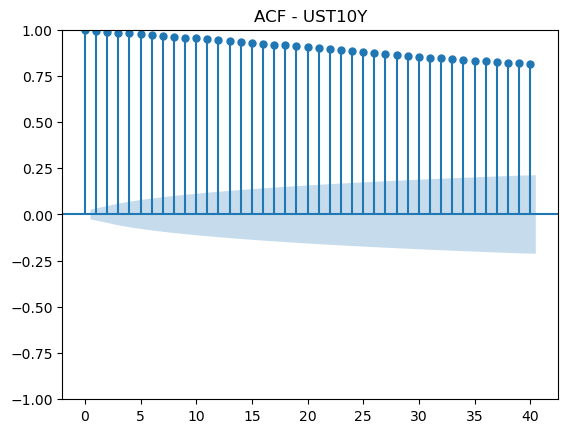

c:\Users\lawor\anaconda3v0\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


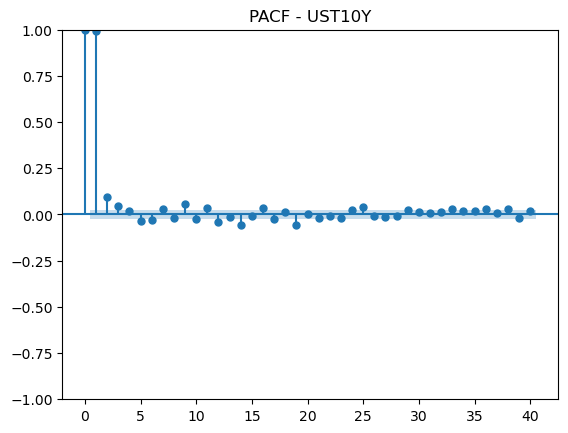

=== HYOAS ===


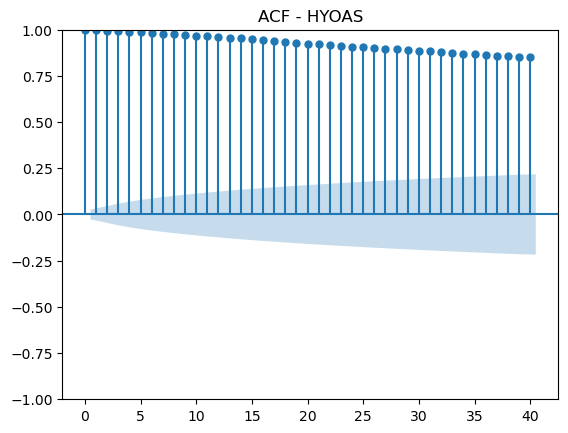

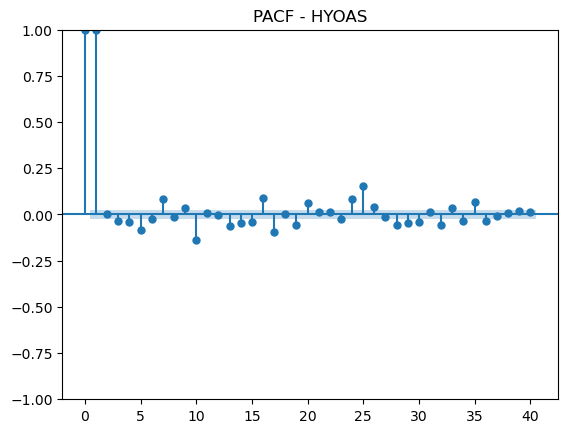

=== TermSpread_10Y_2Y ===


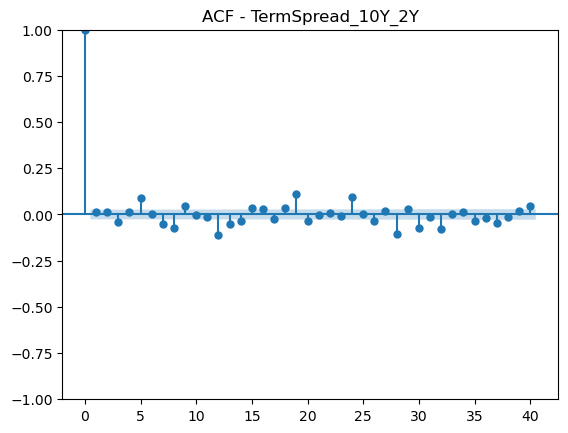

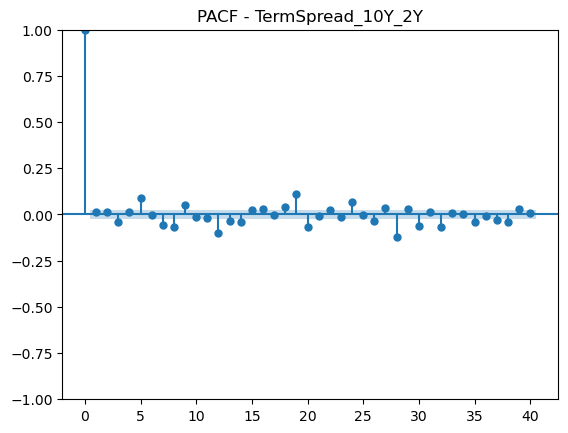

=== VIX ===


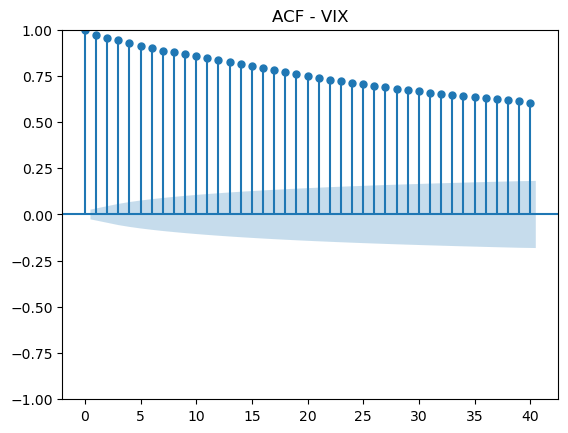

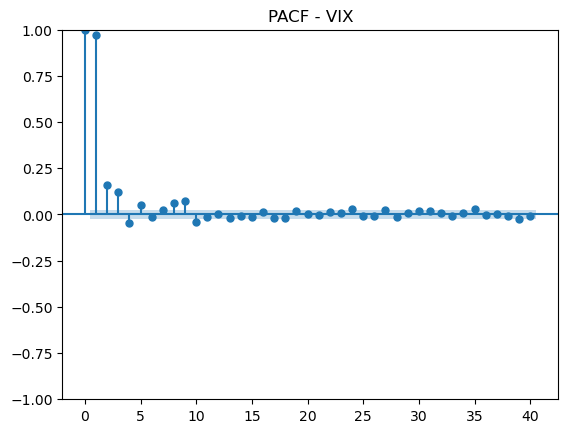

=== Breakeven10Y ===


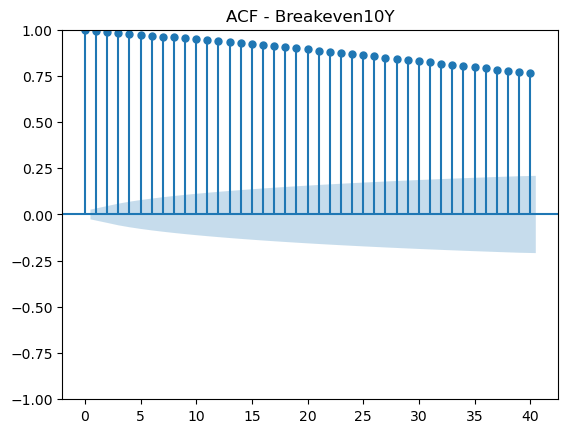

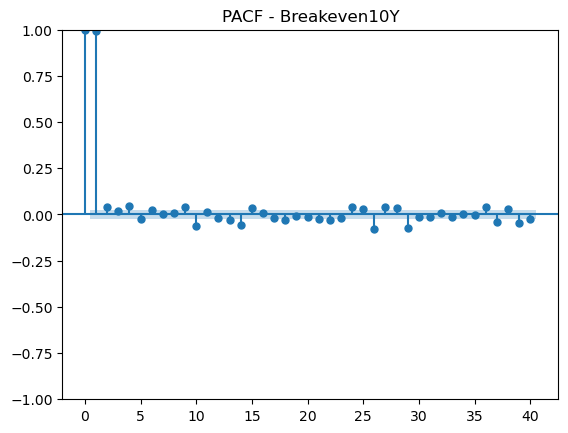

In [56]:
# Plot ACF and PACF for each log-vol estimator
for col in exo_std_harx_r1.columns:
    print(f"=== {col} ===")
    vol_check.plot_acf(exo_std_harx_r1[col], nlags=40, title=f"ACF - {col}")
    vol_check.plot_pacf(exo_std_harx_r1[col], nlags=40, title=f"PACF - {col}")

## Adjust exogeneous variables
- After the first differencing done on TermSpread_10Y_2Y, all the exogeneous variables passed the ADF test.
- TermSpread_10Y_2Y passed the KPSS test.

## Proceed to run through the HARX modelling

In [57]:
y_true_log_harx = y_true_log.loc[common_idx]
y_true_log_harx

Date
2003-01-09   -6.394209
2003-01-10   -7.302409
2003-01-13   -5.783231
2003-01-14   -5.118685
2003-01-15   -7.630543
                ...   
2024-12-20   -3.844518
2024-12-23   -5.406559
2024-12-24   -9.413061
2024-12-26   -4.069927
2024-12-27   -4.126031
Name: Close, Length: 5530, dtype: float64

In [58]:
# vol_adj_harx
# exo_std_harx_r1
# y_true_log_harx

In [59]:
n_total = len(vol_adj_harx)
split_point = int(0.7 * n_total)
#x_variables
train_x = vol_adj_harx.iloc[:split_point]
test_x = vol_adj_harx.iloc[split_point:]

exo_harx_train = exo_std_harx_r1.iloc[:split_point]
exo_harx_test = exo_std_harx_r1.iloc[split_point:]

#y_variables
train_y = y_true_log_harx.iloc[:split_point]
test_y = y_true_log_harx.iloc[split_point:]

print("Train X shape:", train_x.shape)
print("Test  X shape:", test_x.shape)
print("Train y shape:", train_y.shape)
print("Test  y shape:", test_y.shape)
print('Train Exo shape:' , exo_harx_train.shape)
print('Test Exo shape:' , exo_harx_test.shape)

Train X shape: (3870, 4)
Test  X shape: (1660, 4)
Train y shape: (3870,)
Test  y shape: (1660,)
Train Exo shape: (3870, 5)
Test Exo shape: (1660, 5)


In [60]:
window = [252, 504, 756, 1008, 1260]
estimators = ['square_est_log', 'parkinson_est_log', 'gk_est_log', 'rs_est_log']
per_est = {w: {} for w in window}
per_pred = {w: {} for w in window}
per_residual = {w: {} for w in window}
pred_raw_residual = {w: {} for w in window}

df_pred = {}
df_pred_adj = {}
df_residual = {}
df_residual_adj = {}
qlike_loss_df = {}
mspe_loss_df = {}
yhat_var = {}
summary_df = {}
ljung_box_df = {}

exo_cols = ['UST10Y', 'HYOAS', 'TermSpread_10Y_2Y', 'VIX', 'Breakeven10Y']

for w in window:

  for est in estimators:
    df_in = pd.concat([train_x[[est]], exo_std_harx_r1[exo_cols]], axis=1)
    har = HAR_Model(y_log_col=est, exo_col=exo_cols, lags=[1,5,22])
    x_est = har.features(df_in)
    y_adj = train_y.loc[x_est.index]
    per_est[w][est] = x_est

    y_pred, resid_pred, residual_raw = har.fit_predict(x_est ,y_adj, window=w)

    per_pred[w][est] = y_pred
    per_residual[w][est] = resid_pred
    pred_raw_residual[w][est] = residual_raw

  df_pred[w] = pd.DataFrame(per_pred[w])
  df_pred_adj[w] = df_pred[w].dropna()
  df_residual[w] = pd.DataFrame(pred_raw_residual[w])
  df_residual_adj[w] = df_residual[w].dropna()
  residual_input = df_residual_adj[w]

  #variance scale
  yhat_var[w] = np.exp(df_pred_adj[w])
  ytrue_var = np.exp(train_y)
  common_idx = yhat_var[w].index.intersection(ytrue_var.index)
  yhat = yhat_var[w].loc[common_idx]
  ytrue = ytrue_var.loc[common_idx]

  qlike_loss_df[w] = pd.DataFrame({col: Metric_Evaluation.qlike(ytrue, yhat[col])
                                for col in yhat.columns})
  mspe_loss_df[w]  = pd.DataFrame({col: Metric_Evaluation.mspe(ytrue, yhat[col])
                                for col in yhat.columns})
  summary_df[w] = pd.DataFrame({
    'QLIKE_mean': qlike_loss_df[w].mean(),
    'QLIKE_std':  qlike_loss_df[w].std(),
    'MSPE_mean':  mspe_loss_df[w].mean(),
    'MSPE_std':   mspe_loss_df[w].std()
  }).round(4)

  vol_check = Vol_Est_Check(
      alpha=0.05,
      lb_lags=(10, 20),
      kpss_reg='c',
      kpss_nlags='auto',
      acf_pacf_nlags=40
  )
  ljung_box_df[w] = pd.DataFrame({col: vol_check.ljung_box(residual_input[col])
                              for col in residual_input.columns})

In [61]:
final_summary = pd.concat(summary_df, axis=0)
final_summary.index.name = 'Window'

ljung_box_summary = pd.concat(ljung_box_df, axis=0)
ljung_box_summary.index.name = 'Window'

print(final_summary)
print(ljung_box_summary)

                        QLIKE_mean  QLIKE_std     MSPE_mean      MSPE_std
252  square_est_log        -1.1495     8.9981  3.486775e+17  8.850751e+18
     parkinson_est_log     -1.1853     8.5060  3.408901e+17  9.227402e+18
     gk_est_log            -1.1568     8.7992  3.123817e+17  8.132518e+18
     rs_est_log            -0.8303    24.8750  2.920286e+17  6.664310e+18
504  square_est_log        -1.4509     7.0508  2.411729e+17  5.714195e+18
     parkinson_est_log     -1.3701     7.1552  2.034244e+17  4.546591e+18
     gk_est_log            -1.3553     7.1563  1.880501e+17  4.059709e+18
     rs_est_log            -0.8450    29.2716  2.023621e+17  4.724998e+18
756  square_est_log        -1.4273     6.7952  2.160420e+17  5.320854e+18
     parkinson_est_log     -1.3994     6.8120  1.717865e+17  3.806855e+18
     gk_est_log            -1.3987     6.7366  1.735054e+17  3.942346e+18
     rs_est_log             0.6883   115.2717  1.975801e+17  5.075450e+18
1008 square_est_log        -1.2827    

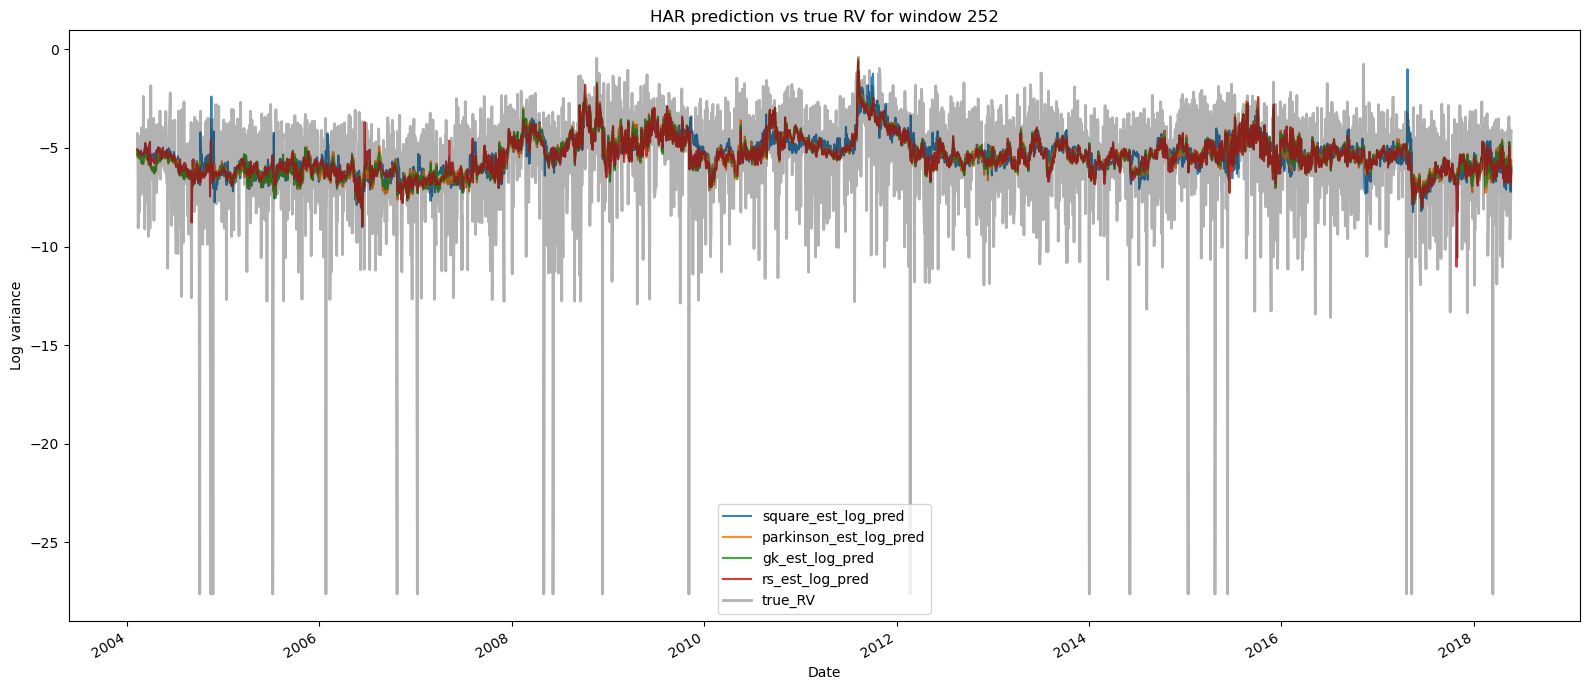

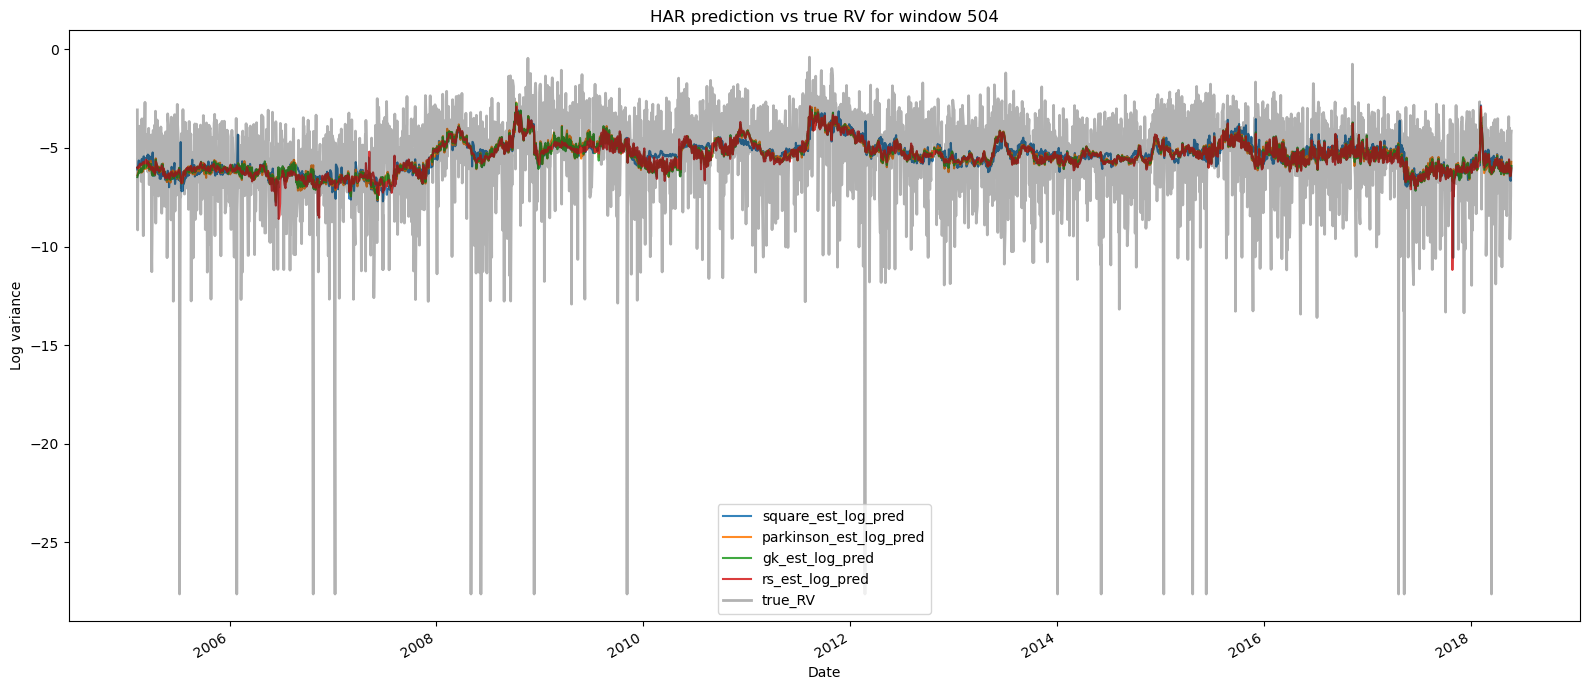

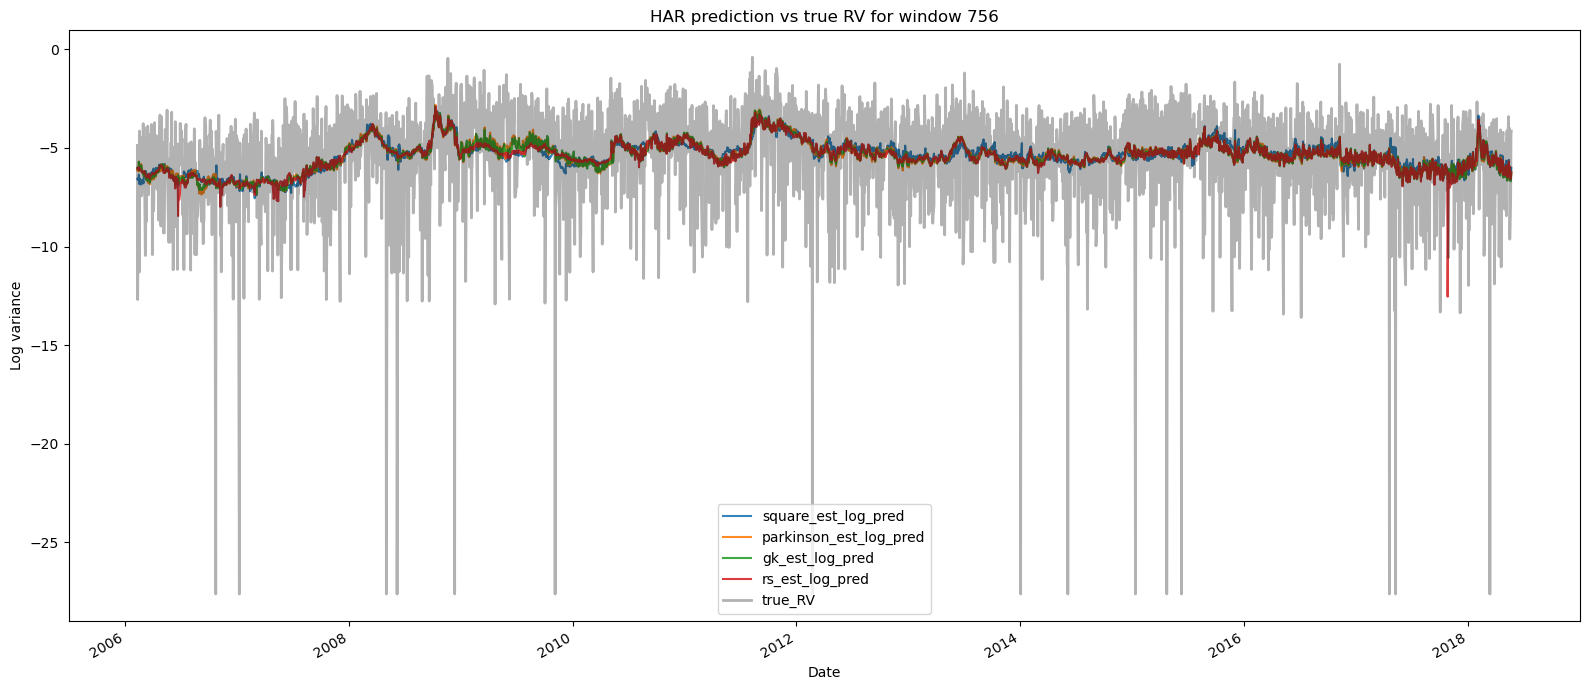

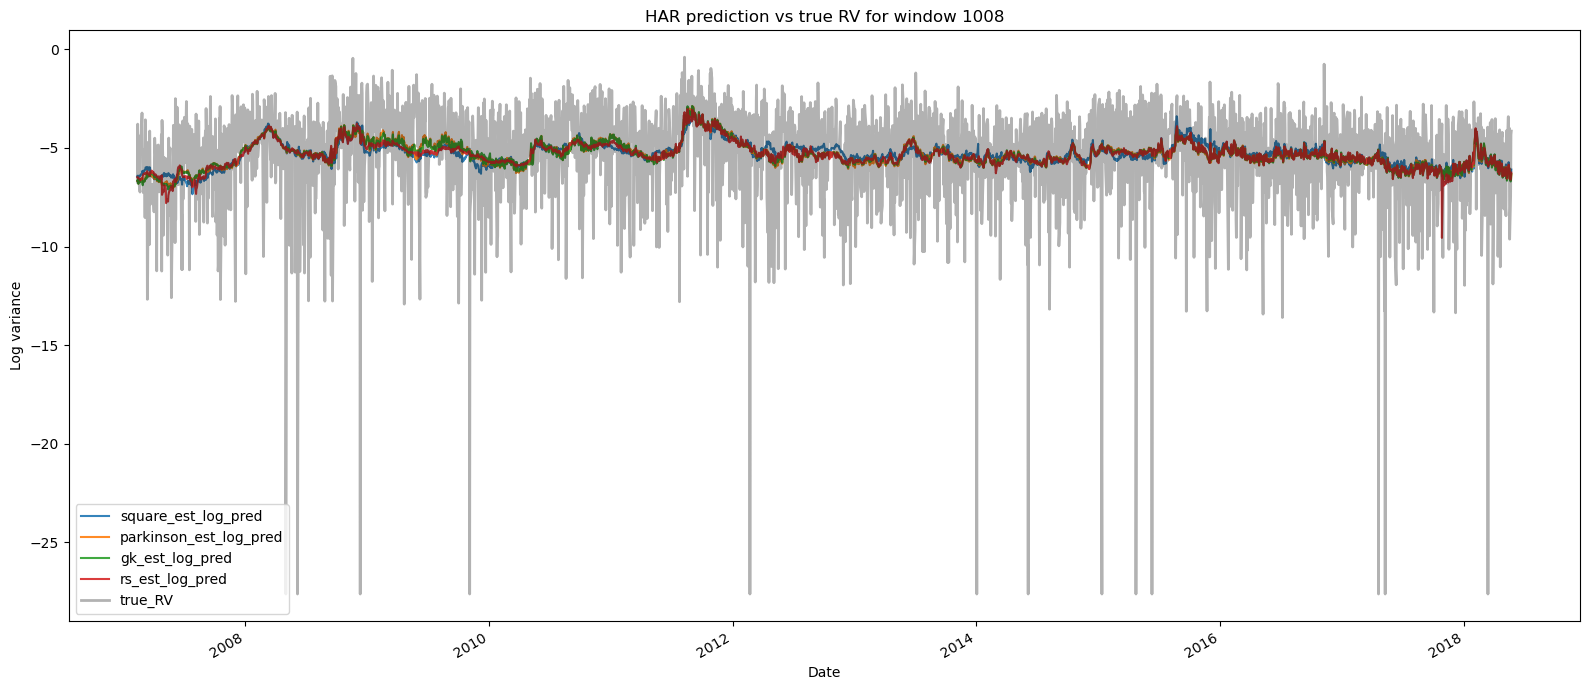

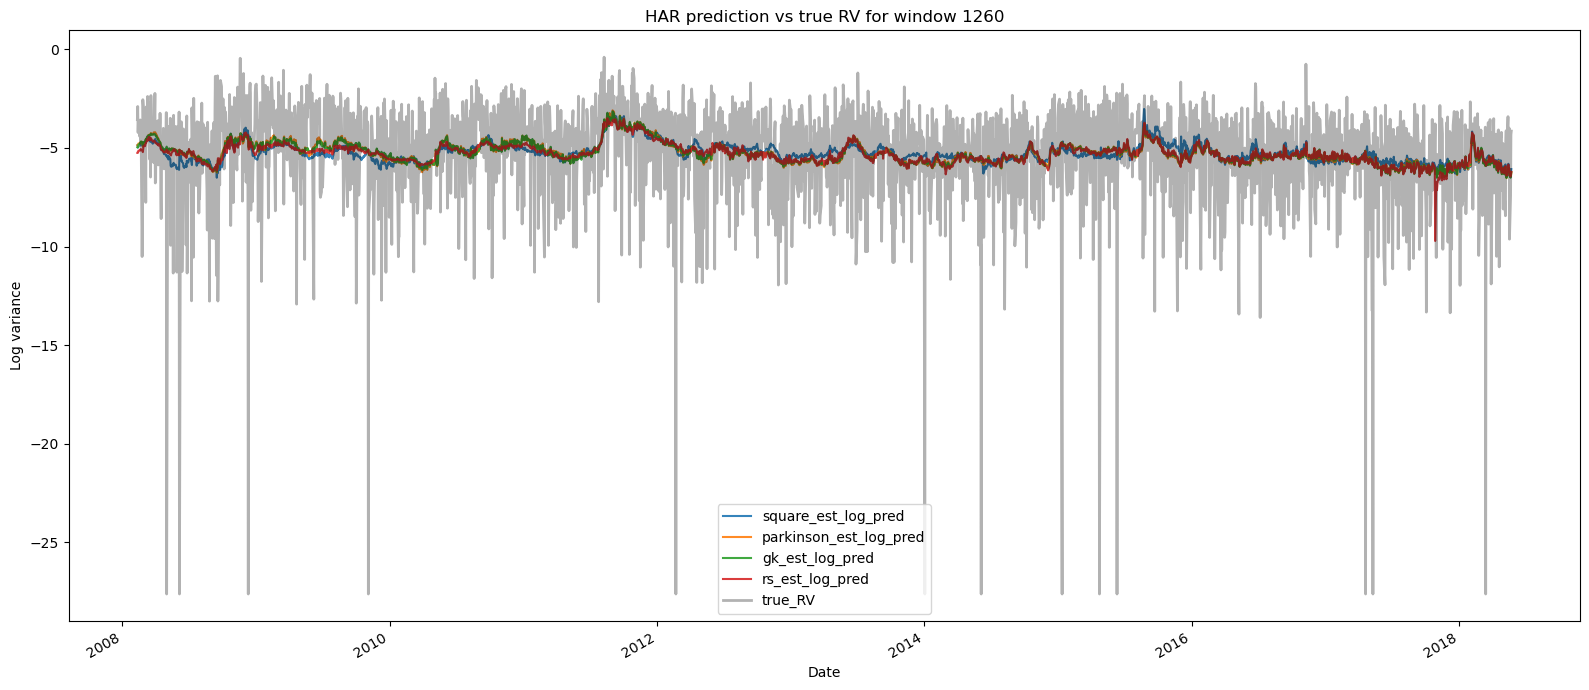

In [62]:
# plot log variance scale
window = [252, 504, 756, 1008, 1260]

for w in window:
  common_idx = df_pred_adj[w].index.intersection( y_adj.index)
  yhat_plot = df_pred_adj[w].loc[common_idx]
  yhat_plot.columns = [f"{col}_pred" for col in yhat_plot.columns]

  ytrue_plot = y_adj.loc[common_idx].to_frame(name = 'true_RV')

  plt.figure(figsize=[16,7])
  yhat_plot.plot(ax=plt.gca(), alpha=0.9)
  ytrue_plot.plot(ax=plt.gca(), color='black', linewidth=2, alpha=0.3, label='True RV')
  plt.xlabel("Date")
  plt.ylabel("Log variance")
  plt.legend()
  plt.title(f"HAR prediction vs true RV for window {w}")
  plt.tight_layout()
  plt.show()


<Figure size 1600x700 with 0 Axes>

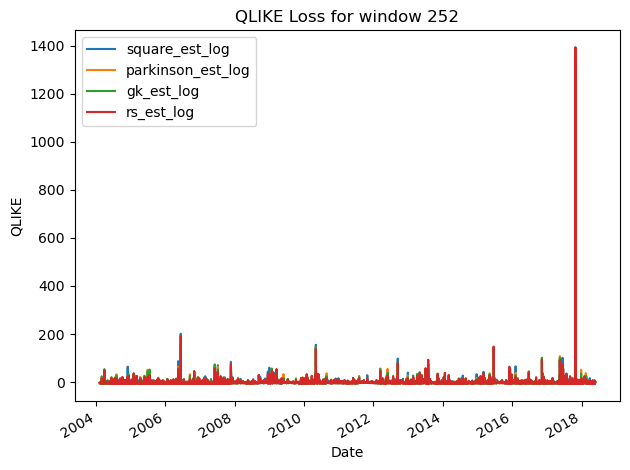

<Figure size 1600x700 with 0 Axes>

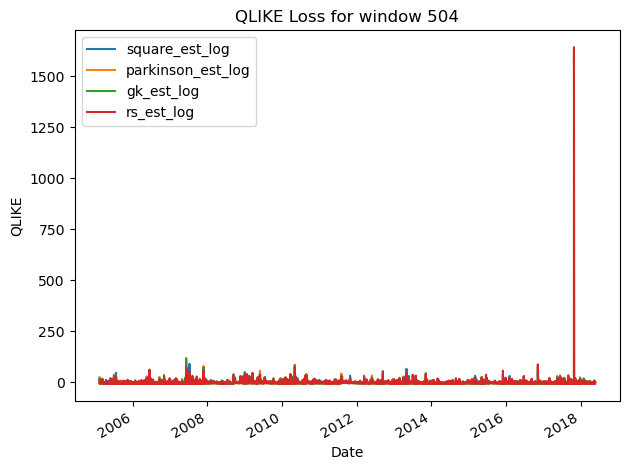

<Figure size 1600x700 with 0 Axes>

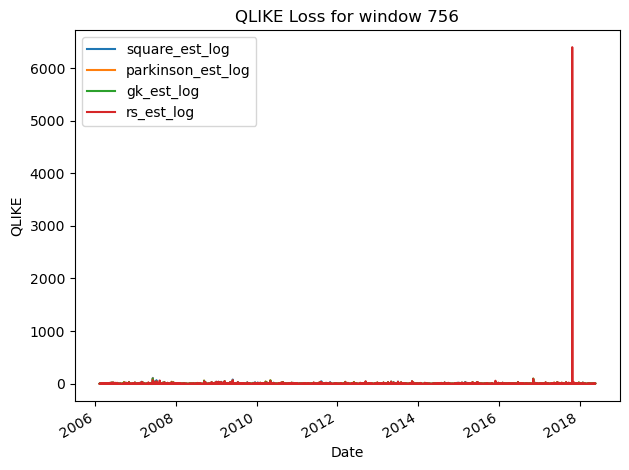

<Figure size 1600x700 with 0 Axes>

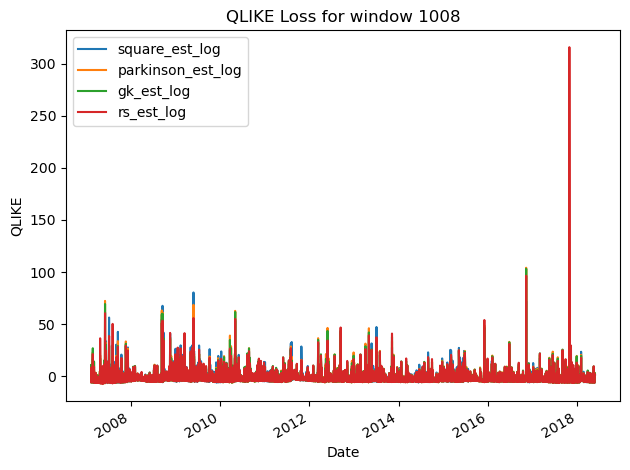

<Figure size 1600x700 with 0 Axes>

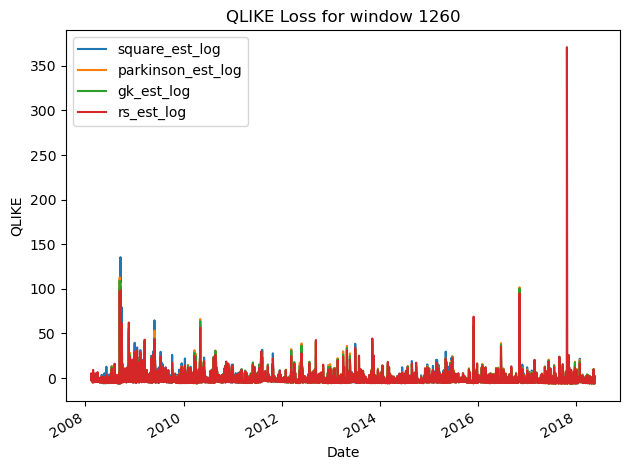

In [63]:
# IN variance scale
for w in window:
  plt.figure(figsize=[16,7])
  qlike_loss_df[w][['square_est_log', 'parkinson_est_log', 'gk_est_log', 'rs_est_log']].plot()
  plt.xlabel("Date")
  plt.ylabel("QLIKE")
  plt.legend()
  plt.title(f"QLIKE Loss for window {w}")
  plt.tight_layout()
  plt.show()

<Figure size 1600x700 with 0 Axes>

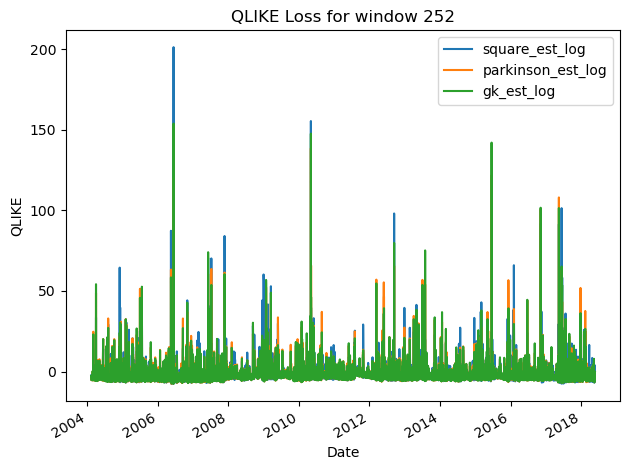

<Figure size 1600x700 with 0 Axes>

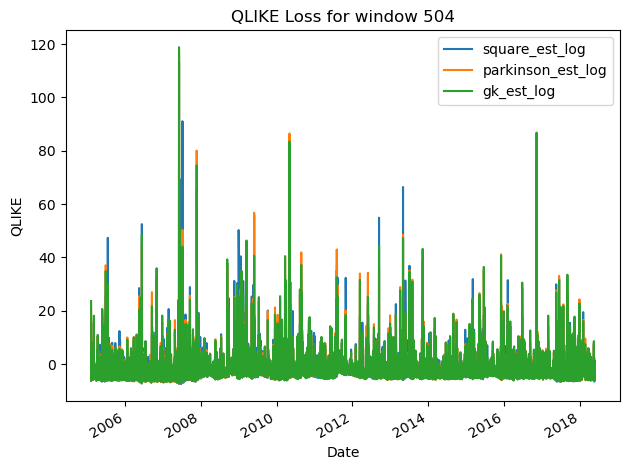

<Figure size 1600x700 with 0 Axes>

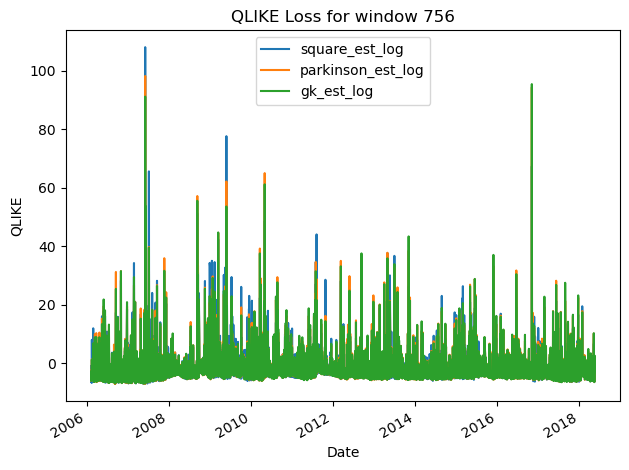

<Figure size 1600x700 with 0 Axes>

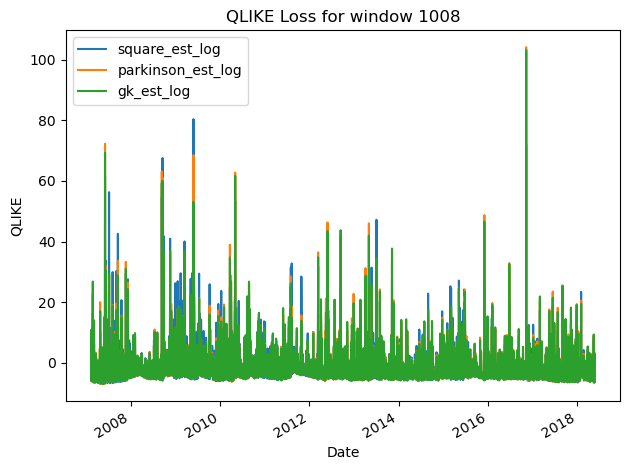

<Figure size 1600x700 with 0 Axes>

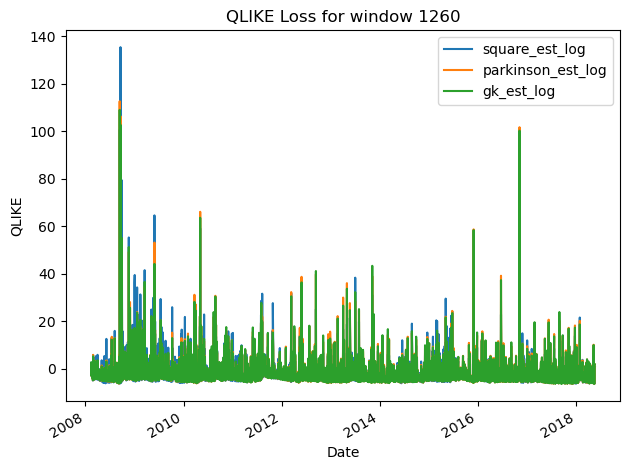

In [64]:
# IN variance scale
for w in window:
  plt.figure(figsize=[16,7])
  qlike_loss_df[w][['square_est_log', 'parkinson_est_log', 'gk_est_log']].plot()
  plt.xlabel("Date")
  plt.ylabel("QLIKE")
  plt.legend()
  plt.title(f"QLIKE Loss for window {w}")
  plt.tight_layout()
  plt.show()

## Creating ensemble model for HARX model

In [65]:
# creating ensemble model for all 5 windows
window = [252, 504, 756, 1008, 1260]

qlike_ensemble = {}
wts = {}
weight_ensemble = {}
yhat_ensemble = {}
yhat_enfinal = {}
log_yhat_enfinal = {}
log_yhat_ensemble = {}
residual_ensemble = {}
qlike_loss_ensemble = {}
mspe_loss_ensemble = {}
summary_ensemble = {}
ljung_box_ensemble = {}

for w in window:

  #compute weightage
  ensemble_model = EnsembleModel(estimators=None)
  qlike_ensemble[w] = summary_df[w]['QLIKE_mean']
  weight_ensemble[w] = ensemble_model.compute_weightage(qlike_ensemble[w])
  yhat_ensemble[w] = (np.exp(df_pred_adj[w]))

  wts[w] = pd.Series(weight_ensemble[w], index=yhat_ensemble[w].columns, dtype=float)

  yhat_enfinal[w] = yhat_ensemble[w].dot(wts[w])
  log_yhat_enfinal[w] = np.log(  yhat_enfinal[w])

  common_idx = log_yhat_enfinal[w].index.intersection(y_adj.index)
  log_yhat_ensemble[w] = log_yhat_enfinal[w].loc[common_idx] #log-variance
  log_ytrue_ensemble = y_adj.loc[common_idx] #log-variance
  ytrue_ensemble = ytrue_var.loc[common_idx] # variance

  residual_ensemble[w] = log_yhat_ensemble[w] - log_ytrue_ensemble

  qlike_loss_ensemble[w] = pd.DataFrame(Metric_Evaluation.qlike(ytrue_ensemble, yhat_enfinal[w]))
  mspe_loss_ensemble[w]  = pd.DataFrame(Metric_Evaluation.mspe(ytrue_ensemble, yhat_enfinal[w]))

  summary_ensemble[w] = pd.DataFrame({
    'QLIKE_mean': qlike_loss_ensemble[w].mean(),
    'QLIKE_std':  qlike_loss_ensemble[w].std(),
    'MSPE_mean':  mspe_loss_ensemble[w].mean(),
    'MSPE_std':   mspe_loss_ensemble[w].std()
  }).round(4)

  vol_check = Vol_Est_Check(
      alpha=0.05,
      lb_lags=(10, 20),
      kpss_reg='c',
      kpss_nlags='auto',
      acf_pacf_nlags=40
  )
  ljung_box_ensemble[w] = pd.DataFrame(vol_check.ljung_box(residual_ensemble[w]))

In [66]:
for w in window:
    print(w, wts[w].round(4))

252 square_est_log       0.25
parkinson_est_log    0.25
gk_est_log           0.25
rs_est_log           0.25
dtype: float64
504 square_est_log       0.25
parkinson_est_log    0.25
gk_est_log           0.25
rs_est_log           0.25
dtype: float64
756 square_est_log       0.3333
parkinson_est_log    0.3333
gk_est_log           0.3333
rs_est_log           0.0000
dtype: float64
1008 square_est_log       0.25
parkinson_est_log    0.25
gk_est_log           0.25
rs_est_log           0.25
dtype: float64
1260 square_est_log       0.25
parkinson_est_log    0.25
gk_est_log           0.25
rs_est_log           0.25
dtype: float64


In [67]:
final_summary_ensemble = pd.concat(summary_ensemble, axis=0)
final_summary_ensemble.index.name = 'Window'

lb_ensemble_final = pd.concat(ljung_box_ensemble, axis=0)
lb_ensemble_final.index.name = 'Window'

print(final_summary_ensemble)
print(lb_ensemble_final)

        QLIKE_mean  QLIKE_std     MSPE_mean      MSPE_std
252  0     -1.3714     8.0776  3.161381e+17  8.052909e+18
504  0     -1.4655     6.8023  2.057173e+17  4.643093e+18
756  0     -1.4654     6.6114  1.847055e+17  4.290945e+18
1008 0     -1.3650     6.5528  2.119262e+17  5.167539e+18
1260 0     -1.3047     6.9516  1.965940e+17  3.697374e+18
        lb_stat_10   lb_p_10  lb_stat_20   lb_p_20  white_noise_flag  \
252  0    9.236856  0.509782   17.635115  0.611431              True   
     1    9.236856  0.509782   17.635115  0.611431              True   
504  0    6.685223  0.754790   14.880769  0.783189              True   
     1    6.685223  0.754790   14.880769  0.783189              True   
756  0    8.511086  0.579044   14.896051  0.782324              True   
     1    8.511086  0.579044   14.896051  0.782324              True   
1008 0    9.073531  0.525140   13.630540  0.848724              True   
     1    9.073531  0.525140   13.630540  0.848724              True   
1260

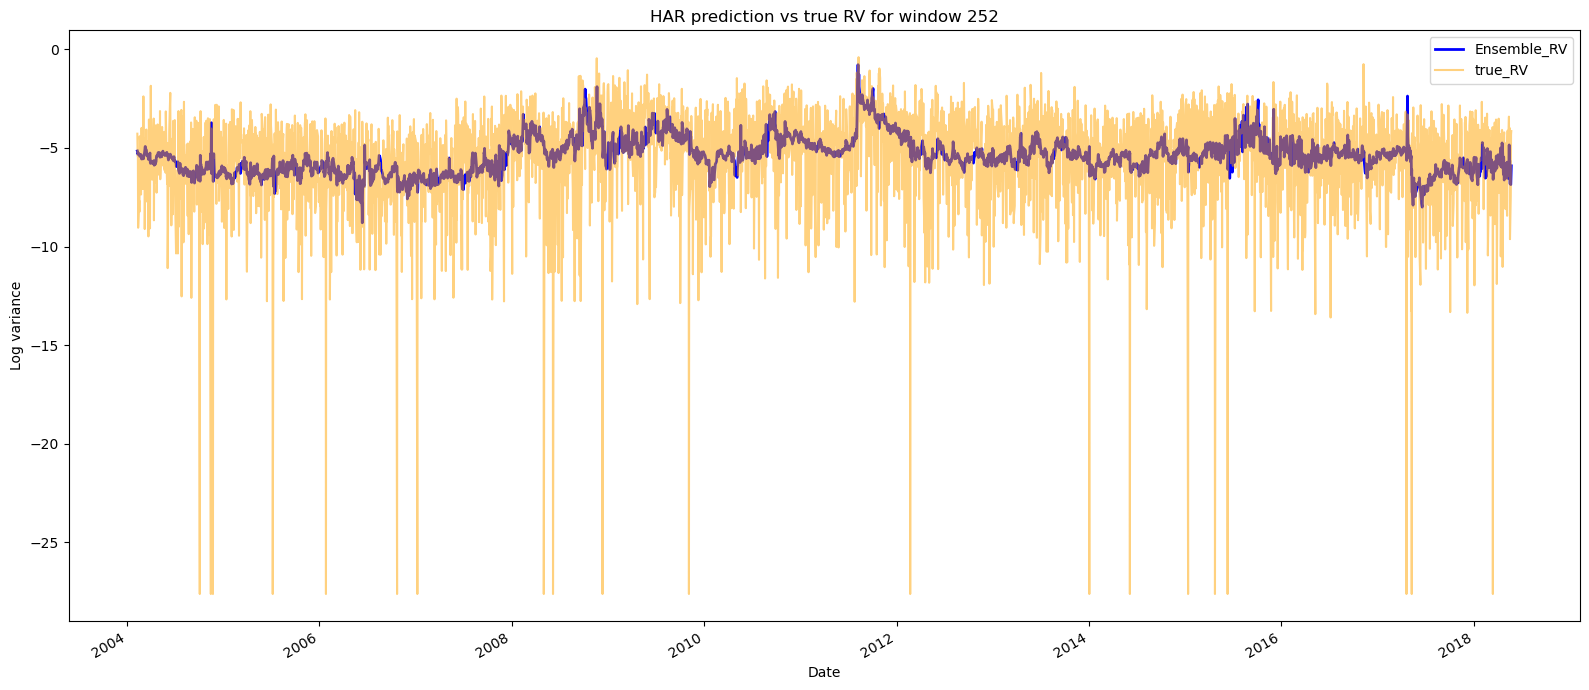

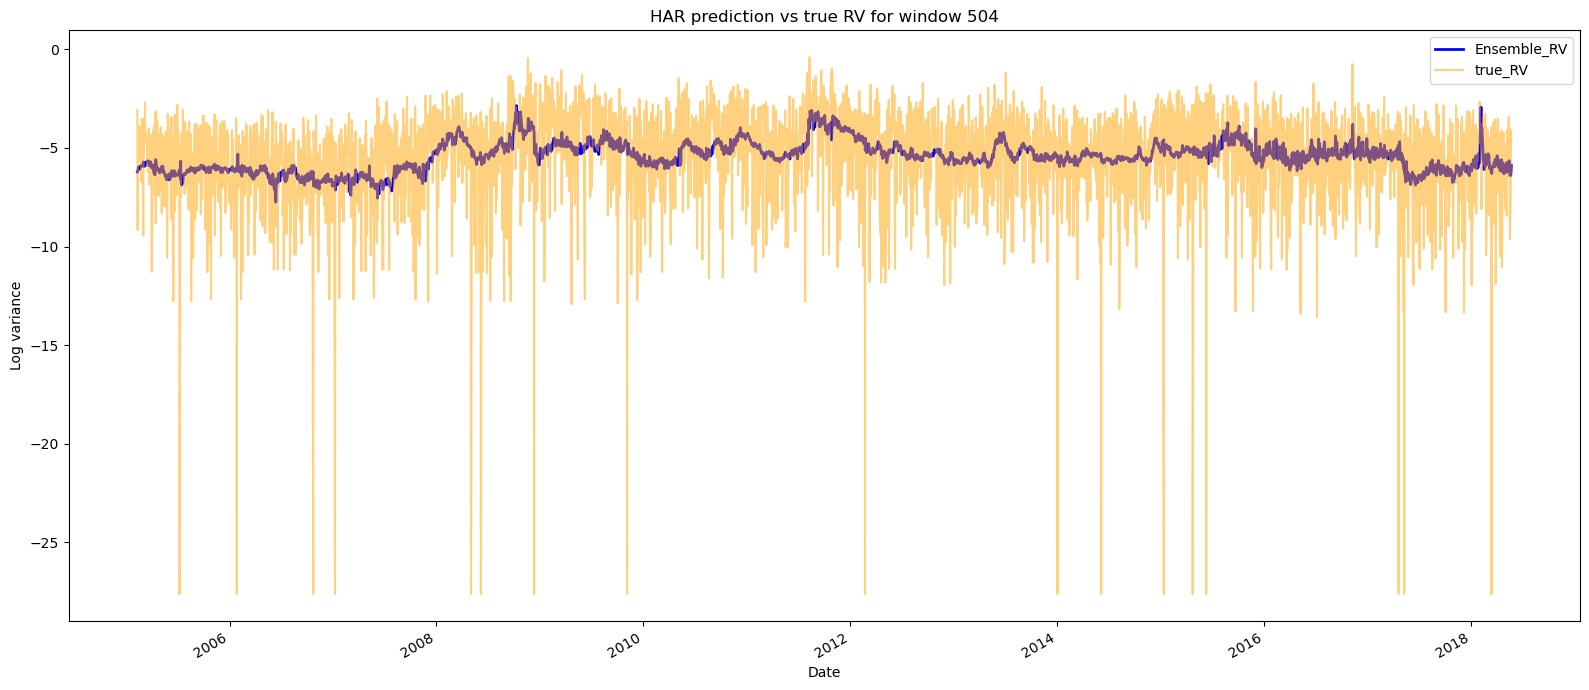

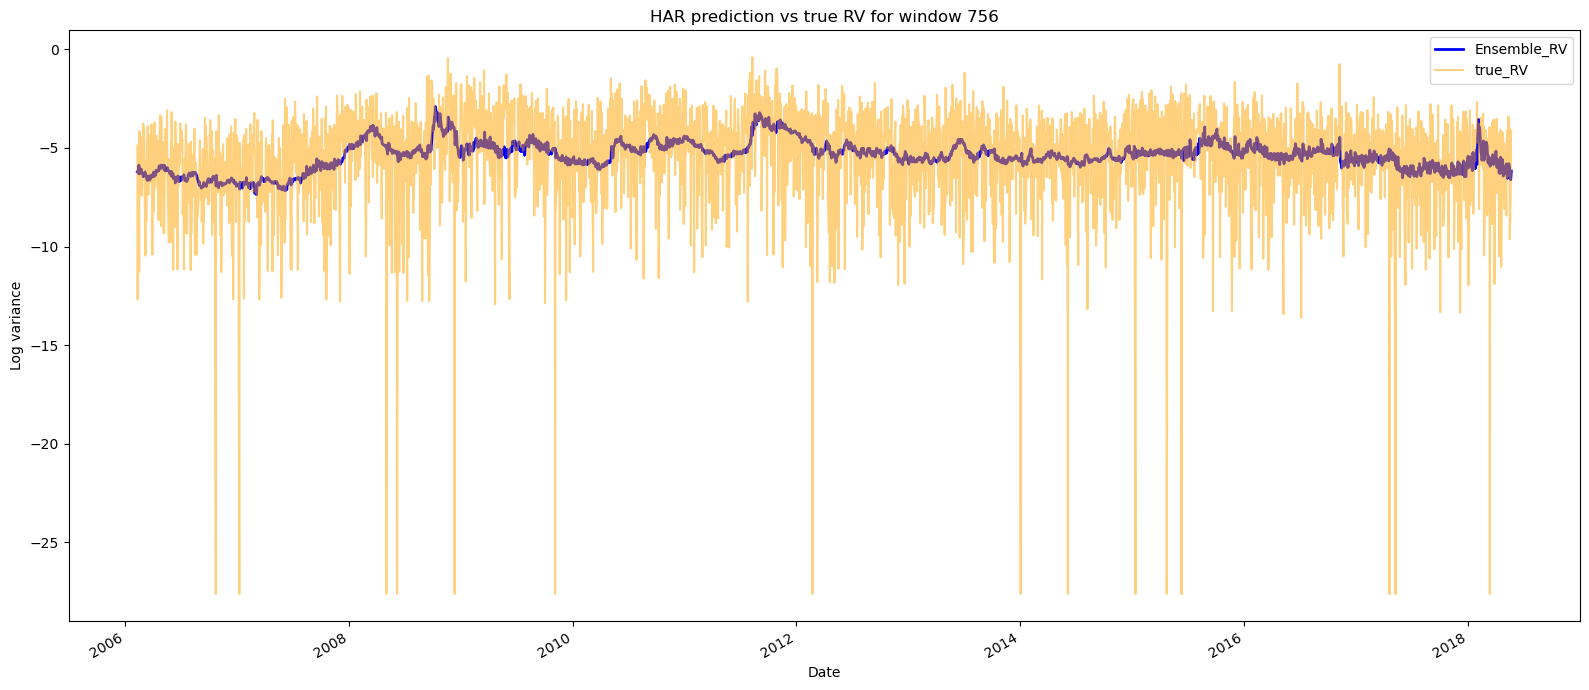

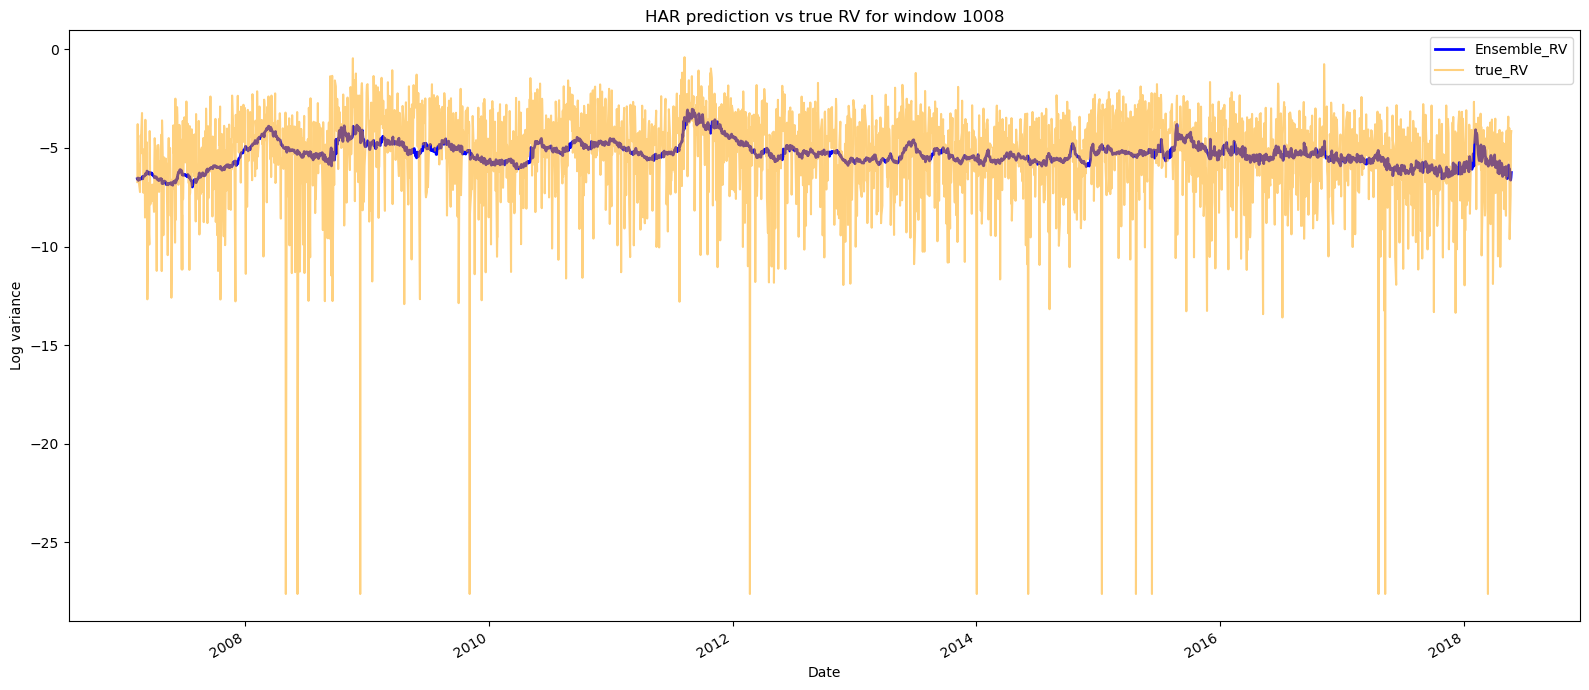

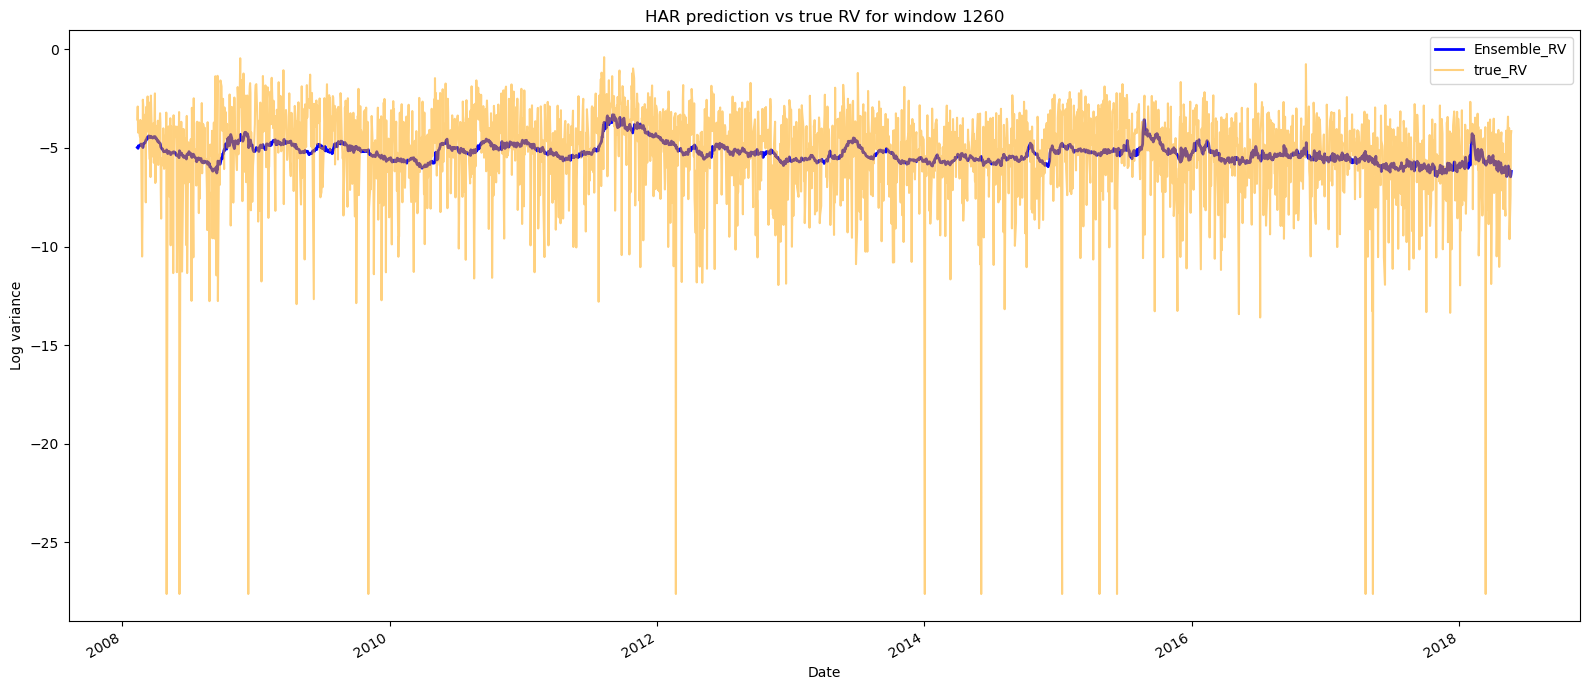

In [68]:
# plot log variance scale
window = [252, 504, 756, 1008, 1260]
for w in window:
  common_idx = log_yhat_enfinal[w].index.intersection(y_adj.index)
  yhat_plot = log_yhat_enfinal[w].loc[common_idx].to_frame(name = 'Ensemble_RV') #log-variance
  ytrue_plot = y_adj.loc[common_idx].to_frame(name = 'true_RV') #log-variance

  y_plot = pd.concat([yhat_plot, ytrue_plot], axis = 1)

  fig, ax = plt.subplots(figsize=(16, 7))
  yhat_plot.plot(ax=ax, color='blue', linewidth=2, label='Ensemble_RV')
  ytrue_plot.plot(ax=ax, color='orange', linewidth=1.5, alpha=0.5, label='true_RV')
  plt.xlabel("Date")
  plt.ylabel("Log variance")
  plt.legend()
  plt.title(f"HAR prediction vs true RV for window {w}")
  plt.tight_layout()
  plt.show()

<Figure size 1600x700 with 0 Axes>

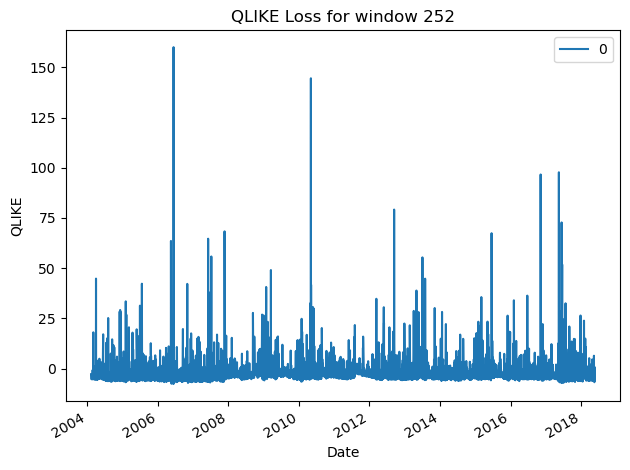

<Figure size 1600x700 with 0 Axes>

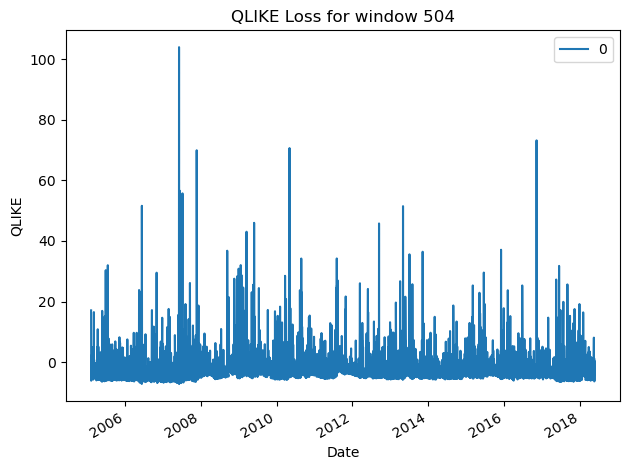

<Figure size 1600x700 with 0 Axes>

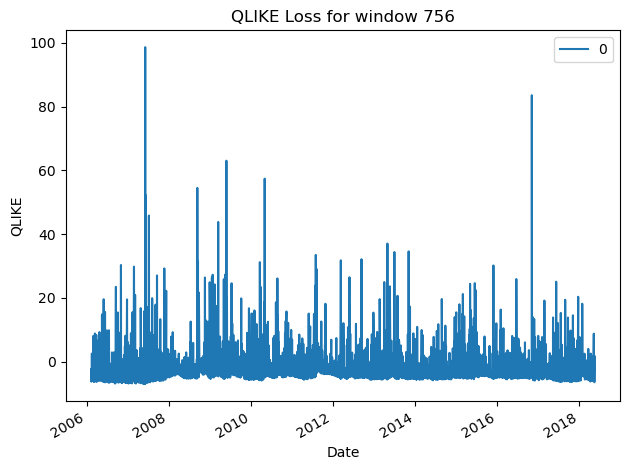

<Figure size 1600x700 with 0 Axes>

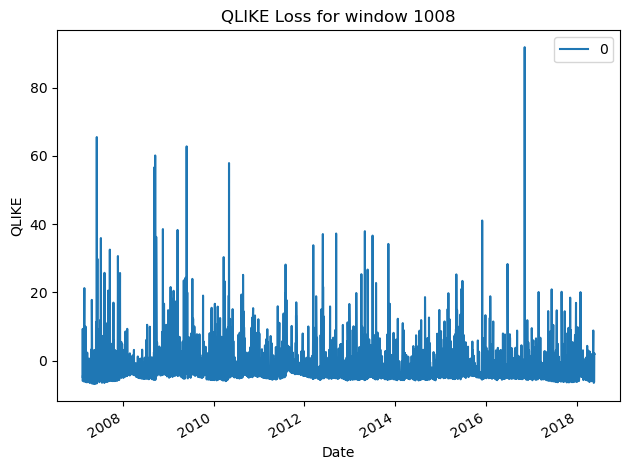

<Figure size 1600x700 with 0 Axes>

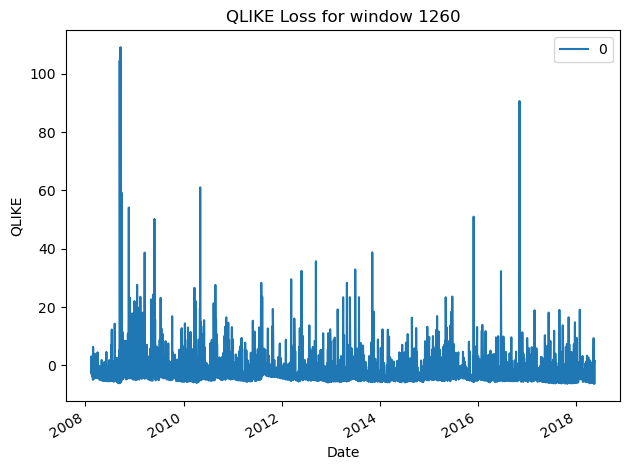

In [69]:
# IN variance scale
for w in window:
  plt.figure(figsize=[16,7])
  qlike_loss_ensemble[w].plot()
  plt.xlabel("Date")
  plt.ylabel("QLIKE")
  plt.title(f"QLIKE Loss for window {w}")
  plt.tight_layout()
  plt.show()

<Figure size 1600x700 with 0 Axes>

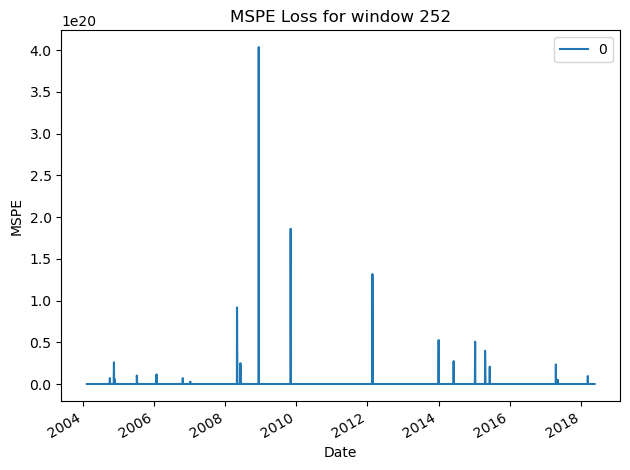

<Figure size 1600x700 with 0 Axes>

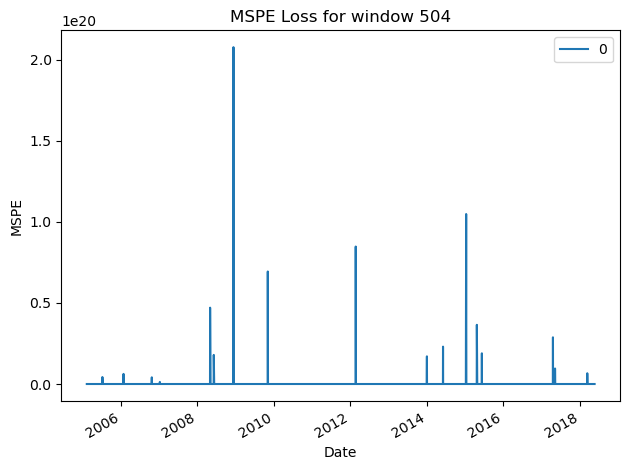

<Figure size 1600x700 with 0 Axes>

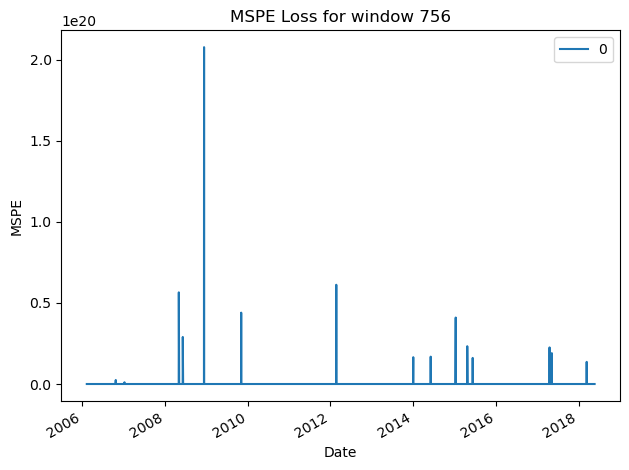

<Figure size 1600x700 with 0 Axes>

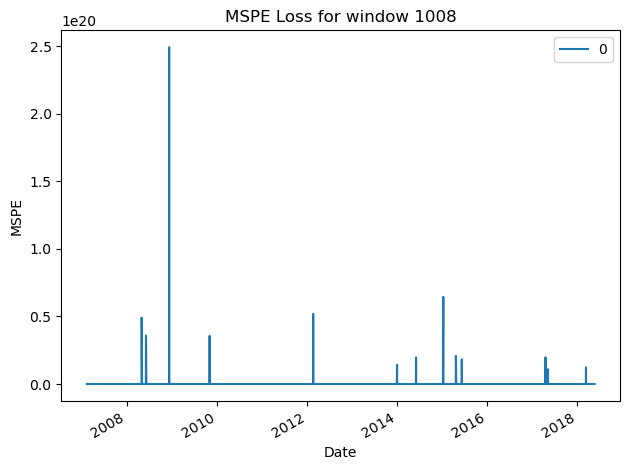

<Figure size 1600x700 with 0 Axes>

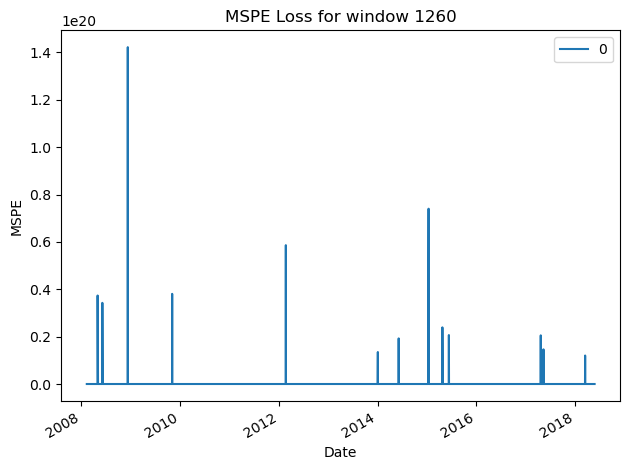

In [70]:
#in variance scale
for w in window:
  plt.figure(figsize=[16,7])
  mspe_loss_ensemble[w].plot()
  plt.xlabel("Date")
  plt.ylabel("MSPE")
  plt.legend()
  plt.title(f"MSPE Loss for window {w}")
  plt.tight_layout()
  plt.show()

=== 252 ===


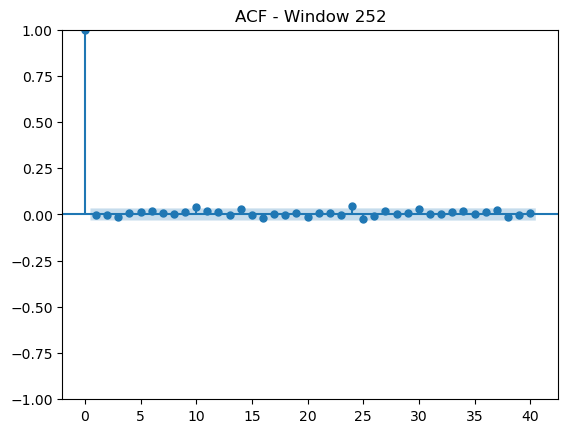

c:\Users\lawor\anaconda3v0\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


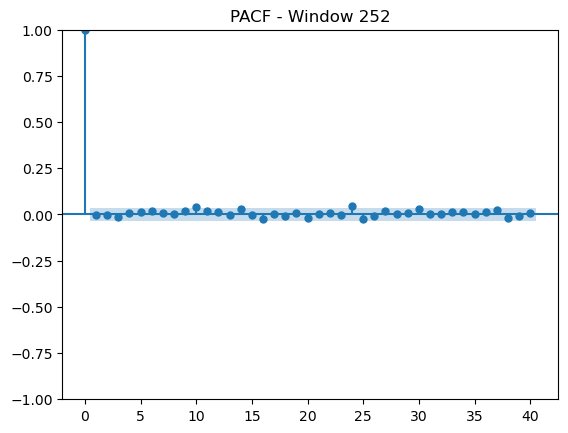

=== 504 ===


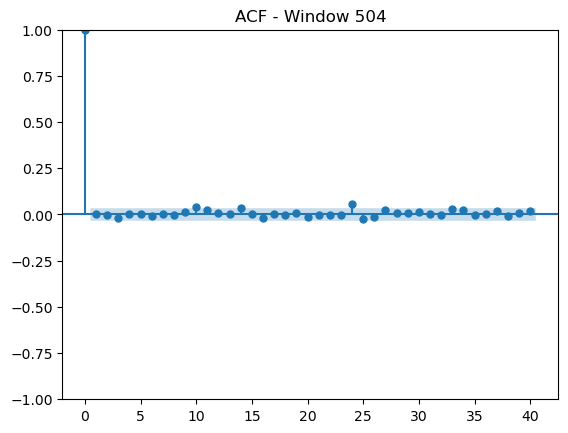

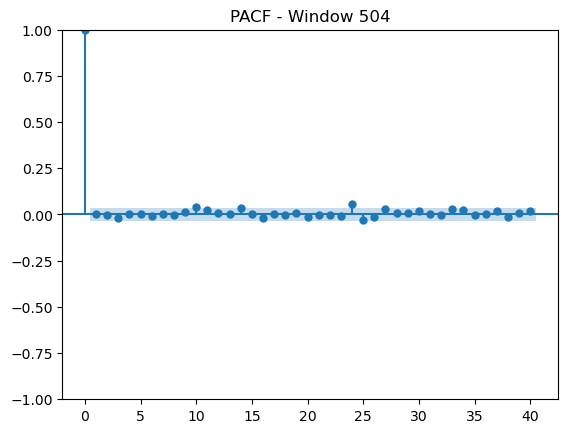

=== 756 ===


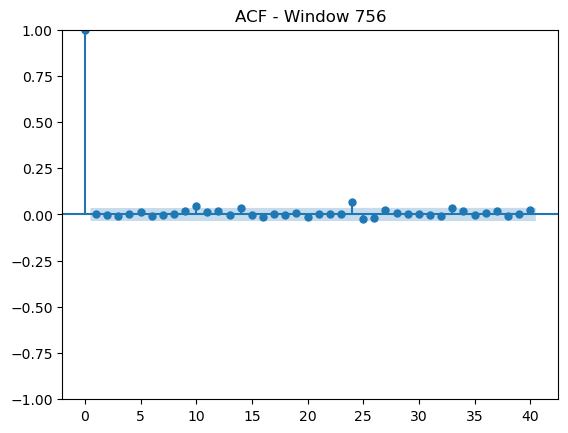

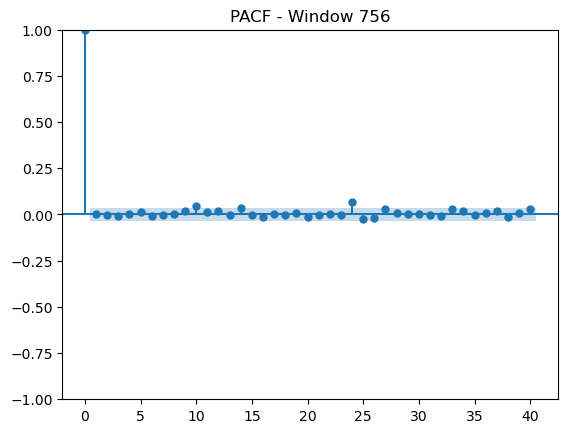

=== 1008 ===


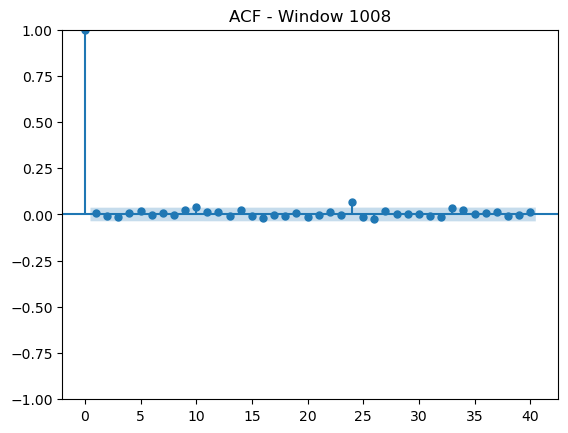

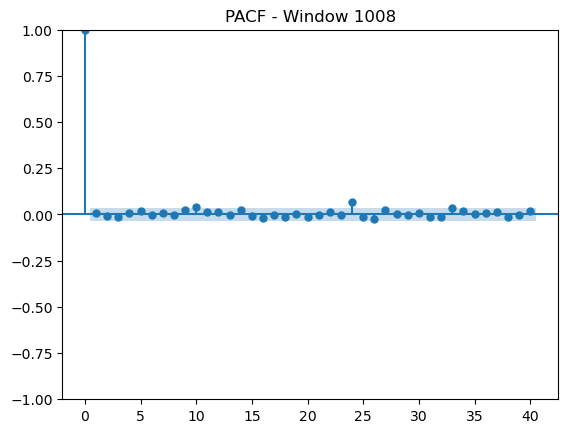

=== 1260 ===


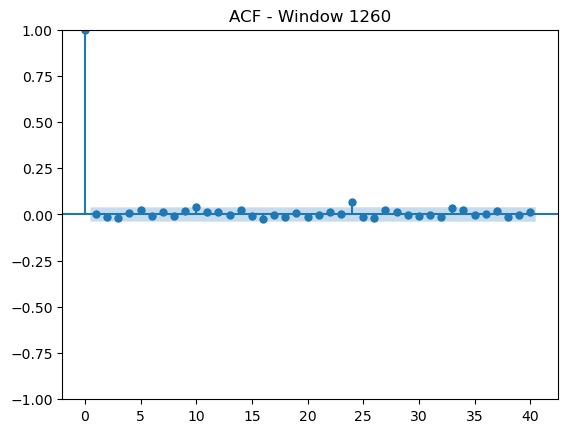

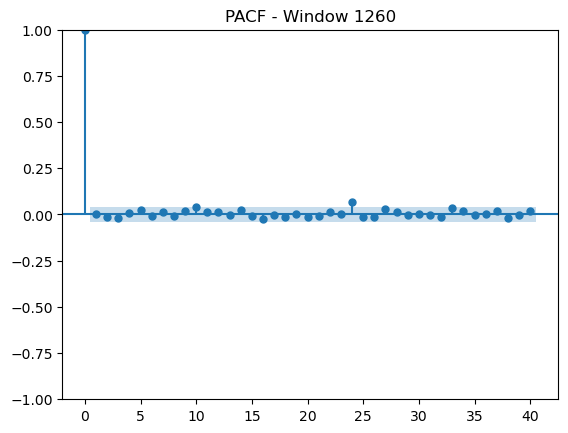

In [71]:
# plot acf and pacf
for w in window:
    print(f"=== {w} ===")
    vol_check.plot_acf(residual_ensemble[w], nlags=40, title=f"ACF - Window {w}")
    vol_check.plot_pacf(residual_ensemble[w], nlags=40, title=f"PACF - Window {w}")

In [72]:
#window = [504, 756]
loss1 = qlike_loss_ensemble[504]
loss2 = qlike_loss_ensemble[756]
common_idx = loss2.index.intersection( loss1.index)
loss2_adj = loss2.loc[common_idx]
loss1_adj = loss1.loc[common_idx]

DM_test_results = Metric_Evaluation.DM_test(loss1_adj,
                                            loss2_adj,
                                            model1_name='Window_504',
                                            model2_name='Window_756'
                                            )

print(DM_test_results)


(0.8862064351143455, 0.3755062966256173, {'Better model': 'None (No significant difference)', 'Significant': False, 'Alpha': 0.05, 'Observations': 3093})


## Comparison of HAR and HARX model results
- HARX model shows a tighter range of QLIKE_mean values across different window lengths (252 → 1260).
- This indicates that HARX performance is more consistent and less sensitive to the choice of rolling window size. HARX’s use of exogenous variables helps stabilize the model fit across different horizons.
- Their absolute QLIKE_mean levels are quite similar (differences ~0.05–0.15). 
Comparable overall explanatory power — neither dominates strongly across all horizons.
- At window = 756, HARX perform slightly better than HAR, suggesting window is large enough to capture long-memory volatility effects, but not so wide that exogenous signals lose relevance.

## Test Set Evaluation with HARX Model of window = 756

In [73]:
#HAR-504 
#HARX-756

In [130]:
# HARX: ensemble model with window = 756
n_total = len(vol_adj_harx)
split_point = int(0.7 * n_total)
#x_variables
train_x = vol_adj_harx.iloc[:split_point]
test_x = vol_adj_harx.iloc[split_point:]

exo_harx_train = exo_std_harx_r1.iloc[:split_point]
exo_harx_test = exo_std_harx_r1.iloc[split_point:]

#y_variables
train_y = y_true_log_harx.iloc[:split_point]
test_y = y_true_log_harx.iloc[split_point:]


In [131]:
test_y

Date
2018-05-24   -4.635204
2018-05-25   -2.134572
2018-05-29   -4.472719
2018-05-30   -7.286340
2018-05-31   -4.224939
                ...   
2024-12-20   -3.844518
2024-12-23   -5.406559
2024-12-24   -9.413061
2024-12-26   -4.069927
2024-12-27   -4.126031
Name: Close, Length: 1660, dtype: float64

In [132]:
w_HARX = 756

test_x_aug = pd.concat([train_x.tail(w_HARX),
                       test_x]). sort_index()

test_exo_aug = pd.concat([exo_harx_train[-w_HARX:],
                          exo_harx_test]).sort_index()

test_y_aug = pd.concat([train_y[-w_HARX:],
                        test_y]).sort_index()
print(test_x_aug)
print(test_exo_aug)
print(test_y_aug)

            square_est_log  parkinson_est_log  gk_est_log  rs_est_log
Date                                                                 
2015-05-26      -10.043137          -5.172497   -4.900616   -4.655734
2015-05-27       -2.623789          -3.905870   -4.543783   -5.193494
2015-05-28       -6.634364          -4.655939   -4.497118   -4.400939
2015-05-29       -6.496237          -5.530055   -5.207679   -5.072481
2015-06-01       -6.706708          -4.998826   -4.878160   -4.925675
...                    ...                ...         ...         ...
2024-12-20       -2.835980          -4.699546   -4.442752   -4.463816
2024-12-23       -4.812897          -5.414671   -5.190815   -4.897708
2024-12-24       -3.844518          -4.912701   -5.361084   -5.783078
2024-12-26       -5.406559          -4.620756   -5.322553   -6.063504
2024-12-27       -9.413061          -4.984313   -5.347732   -5.615191

[2416 rows x 4 columns]
              UST10Y     HYOAS  TermSpread_10Y_2Y       VIX  Brea

In [133]:
test_x_aug.columns

Index(['square_est_log', 'parkinson_est_log', 'gk_est_log', 'rs_est_log'], dtype='object')

In [134]:
estimators = ['square_est_log', 'parkinson_est_log', 'gk_est_log', 'rs_est_log']
exo_cols = ['UST10Y', 'HYOAS', 'TermSpread_10Y_2Y', 'VIX', 'Breakeven10Y']

per_pred = {}
per_residual = {}
pred_raw_residual = {}
qlike_df = {}
w_HARX = 756

X_all = {}
Y_all = {}

yhat_est = {est: [] for est in estimators}

# first step to get all the features out from test set
for est in estimators:
  df_in = pd.concat([test_x_aug[[est]], test_exo_aug[exo_cols]], axis =1)
  har = HAR_Model(y_log_col=est, exo_col=exo_cols, lags=[1,5,22])

  x_est = har.features(df_in) #lags + exo

  #to align the index
  common_idx = test_y_aug.index.intersection(x_est.index)
  x_est = x_est.loc[common_idx]
  y_true = test_y_aug.loc[common_idx] # log variance

  X_all[est] = x_est
  Y_all = y_true
  Y_all_var = np.exp(y_true) # variance




In [135]:
print(X_all)
print(Y_all)

{'square_est_log':                 rv_d      rv_w      rv_m  x_UST10Y   x_HYOAS  \
Date                                                           
2015-06-24 -4.696248 -3.882251 -5.670221 -1.023163 -0.350686   
2015-06-25 -3.985483 -3.841546 -5.394873 -1.003041 -0.347402   
2015-06-26 -5.773769 -3.976498 -5.538054 -0.913675 -0.353783   
2015-06-29 -3.435696 -4.024998 -5.392660 -1.071716 -0.269947   
2015-06-30 -1.760332 -3.930305 -5.177391 -1.051562 -0.240898   
...              ...       ...       ...       ...       ...   
2024-12-20 -2.835980 -4.350827 -5.116884  1.327623 -0.885474   
2024-12-23 -4.812897 -4.587620 -5.106849  1.389117 -0.889224   
2024-12-24 -3.844518 -4.137483 -5.010769  1.388749 -0.885187   
2024-12-26 -5.406559 -3.916759 -4.856667  1.379551 -0.885045   
2024-12-27 -9.413061 -5.262603 -4.854095  1.414509 -0.892687   

            x_TermSpread_10Y_2Y     x_VIX  x_Breakeven10Y  
Date                                                       
2015-06-24            -0.022

In [136]:
yhat_est = {est: [] for est in estimators}
yhat_est_var = {est: [] for est in estimators}
yhat_ensemble = []
yhat_var_df = []

residual_est = {est: [] for est in estimators}
residual_ensemble = []

q_loss_est = {}

qlike_loss_ensemble = []
mspe_loss_ensemble = []
rmse_loss_ensemble = []

weight_est = []
weight_path = {est: [] for est in estimators}

log_yhat_final = []

predict_idx = X_all[estimators[0]].index

Y_all_var = np.exp(y_true)

#to get rolling window prediction
for t in range(w_HARX, len(predict_idx)):
  ts = predict_idx[t]
  win_start = t-w_HARX
  win_end = t

  yhat_t = {}
  y_pred_t = {}
  yhat_var_t = {}
  residual_t = {}
  raw_residual_t = {}
  pred_raw_residual_t = {}
  yhat_var = {}
  pred_residual_t = {}
  pred_raw_residual_t = {}

  for est in estimators:
    x_window = X_all[est].iloc[win_start:win_end +1]
    y_window = Y_all.iloc[win_start:win_end +1]

    har = HAR_Model(y_log_col=est, exo_col=exo_cols, lags=[1,5,22])
    y_pred, resid_pred, residual_raw = har.fit_predict(x_window,
                                                       y_window,
                                                       window=w_HARX)

    #extraction prediction results at time t
    y_pred_t[est] = y_pred.iloc[-1]
    residual_t[est] = resid_pred.iloc[-1]
    raw_residual_t[est] = residual_raw.iloc[-1]

    #store results
    yhat_est[est].append((ts, y_pred_t)) #log variance
    residual_est[est].append((ts,raw_residual_t)) #residual computed by log variance

  y_true_t = Y_all_var.loc[ts] #variance

  # nested dict to covert to dataframe
  rows = []
  for est, tuples in  yhat_est.items():
      for ts, inner_dict in tuples:
          row = {'Date': ts}
          row.update(inner_dict)  # add all estimator predictions
          rows.append(row)
  yhat_est_df = pd.DataFrame(rows).drop_duplicates(subset=['Date']).set_index('Date')

  yhat_var_row = pd.DataFrame(np.exp(yhat_est_df.loc[ts]))

  qlike_loss_df = pd.DataFrame({col: Metric_Evaluation.qlike(y_true_t, yhat_var_row[col])
                                for col in yhat_var_row.columns}) # use variance to compute
  mspe_loss_df  = pd.DataFrame({col: Metric_Evaluation.mspe(y_true_t, yhat_var_row[col])
                                for col in yhat_var_row.columns})  # use variance to compute

  qlike_loss_T = qlike_loss_df.T
  ensemble_model = EnsembleModel(estimators=list(yhat_var_row.columns))
  weight_path[ts] = ensemble_model.compute_weightage(qlike_loss_T.loc[ts]) #get weights for 4 estimators
  weight_est.append((ts,weight_path[ts]))
  q_loss_est[ts] = qlike_loss_T.loc[ts]



In [137]:
print(weight_est) #weightage
print(yhat_est) # log-variance

[(Timestamp('2018-06-25 00:00:00'), {'square_est_log': 0.25, 'parkinson_est_log': 0.25, 'gk_est_log': 0.25, 'rs_est_log': 0.25}), (Timestamp('2018-06-26 00:00:00'), {'square_est_log': 0.46172435593827127, 'parkinson_est_log': 0.1994110956427093, 'gk_est_log': 0.16686125694529233, 'rs_est_log': 0.17200329147372714}), (Timestamp('2018-06-27 00:00:00'), {'square_est_log': 0.25, 'parkinson_est_log': 0.25, 'gk_est_log': 0.25, 'rs_est_log': 0.25}), (Timestamp('2018-06-28 00:00:00'), {'square_est_log': 0.25, 'parkinson_est_log': 0.25, 'gk_est_log': 0.25, 'rs_est_log': 0.25}), (Timestamp('2018-06-29 00:00:00'), {'square_est_log': 0.25, 'parkinson_est_log': 0.25, 'gk_est_log': 0.25, 'rs_est_log': 0.25}), (Timestamp('2018-07-02 00:00:00'), {'square_est_log': 0.25, 'parkinson_est_log': 0.25, 'gk_est_log': 0.25, 'rs_est_log': 0.25}), (Timestamp('2018-07-03 00:00:00'), {'square_est_log': 0.25, 'parkinson_est_log': 0.25, 'gk_est_log': 0.25, 'rs_est_log': 0.25}), (Timestamp('2018-07-05 00:00:00'), {'

In [138]:
#weight
rows = []
for ts, inner_dict in weight_est:   # directly unpack
    row = {'Date': ts}
    row.update(inner_dict)          # add weight values for all estimators
    rows.append(row)

weight_HARX = pd.DataFrame(rows).drop_duplicates(subset=['Date']).set_index('Date')
print(weight_HARX)

            square_est_log  parkinson_est_log  gk_est_log  rs_est_log
Date                                                                 
2018-06-25        0.250000           0.250000    0.250000    0.250000
2018-06-26        0.461724           0.199411    0.166861    0.172003
2018-06-27        0.250000           0.250000    0.250000    0.250000
2018-06-28        0.250000           0.250000    0.250000    0.250000
2018-06-29        0.250000           0.250000    0.250000    0.250000
...                    ...                ...         ...         ...
2024-12-20        0.250000           0.250000    0.250000    0.250000
2024-12-23        0.250000           0.250000    0.250000    0.250000
2024-12-24        0.250000           0.250000    0.250000    0.250000
2024-12-26        0.250000           0.250000    0.250000    0.250000
2024-12-27        0.250000           0.250000    0.250000    0.250000

[1639 rows x 4 columns]


In [139]:
#yhat
rows = []
# Iterate through the outer dict
for est_name, records in yhat_est.items():
    for ts, inner_dict in records:
        row = {'Date': ts}
        row.update(inner_dict)  # add all estimator values
        rows.append(row)

# Convert to DataFrame
yhat_log_harx = pd.DataFrame(rows)

# Drop duplicates so each timestamp appears only once
yhat_log_harx = yhat_log_harx.drop_duplicates(subset=['Date']).set_index('Date')

yhat_var_harx = np.exp(yhat_log_harx)

print(yhat_var_harx)
print(yhat_log_harx)

            square_est_log  parkinson_est_log  gk_est_log  rs_est_log
Date                                                                 
2018-06-25        0.003393           0.002374    0.002135    0.002294
2018-06-26        0.003322           0.002723    0.002567    0.002594
2018-06-27        0.002530           0.001971    0.001790    0.002013
2018-06-28        0.003070           0.002696    0.002504    0.002563
2018-06-29        0.003323           0.002384    0.002243    0.002480
...                    ...                ...         ...         ...
2024-12-20        0.006610           0.007795    0.008555    0.008567
2024-12-23        0.005744           0.005720    0.005744    0.006016
2024-12-24        0.005926           0.007038    0.006130    0.005218
2024-12-26        0.006560           0.007967    0.006424    0.005026
2024-12-27        0.007723           0.006762    0.005879    0.005580

[1639 rows x 4 columns]
            square_est_log  parkinson_est_log  gk_est_log  rs_est

In [140]:
#compute to get the final yhat - variance
weights_shifted = weight_HARX.shift(1)
weights_shifted.iloc[0] = 1 / len(estimators)

yhat_ensemble_HARX = (weights_shifted * yhat_var_harx).sum(axis=1) # variance
yhat_ensemble_HARX.name = 'yhat_ensemble_HARX'

yhat_ensemble_log_HARX = np.log(yhat_ensemble_HARX)

print(yhat_ensemble_HARX)
print(yhat_ensemble_log_HARX)

Date
2018-06-25    0.002549
2018-06-26    0.002801
2018-06-27    0.002206
2018-06-28    0.002708
2018-06-29    0.002608
                ...   
2024-12-20    0.007882
2024-12-23    0.005806
2024-12-24    0.006078
2024-12-26    0.006494
2024-12-27    0.006486
Name: yhat_ensemble_HARX, Length: 1639, dtype: float64
Date
2018-06-25   -5.972011
2018-06-26   -5.877604
2018-06-27   -6.116567
2018-06-28   -5.911448
2018-06-29   -5.949336
                ...   
2024-12-20   -4.843179
2024-12-23   -5.148875
2024-12-24   -5.103128
2024-12-26   -5.036812
2024-12-27   -5.038083
Name: yhat_ensemble_HARX, Length: 1639, dtype: float64


In [141]:
# both in log variance to plot later
common_idx = y_true_log.index.intersection(yhat_ensemble_log_HARX.index)
y_actual = y_true_log.loc[common_idx]
yhat_ensemble_HARX_f = yhat_ensemble_log_HARX.loc[common_idx]

print(y_actual)
print(yhat_ensemble_HARX_f)

Date
2018-06-25    -7.604185
2018-06-26    -3.808988
2018-06-27   -11.093858
2018-06-28    -5.812473
2018-06-29    -6.059464
                ...    
2024-12-20    -3.844518
2024-12-23    -5.406559
2024-12-24    -9.413061
2024-12-26    -4.069927
2024-12-27    -4.126031
Name: Close, Length: 1639, dtype: float64
Date
2018-06-25   -5.972011
2018-06-26   -5.877604
2018-06-27   -6.116567
2018-06-28   -5.911448
2018-06-29   -5.949336
                ...   
2024-12-20   -4.843179
2024-12-23   -5.148875
2024-12-24   -5.103128
2024-12-26   -5.036812
2024-12-27   -5.038083
Name: yhat_ensemble_HARX, Length: 1639, dtype: float64


Date
2018-06-25    0.000498
2018-06-26    0.022171
2018-06-27    0.000015
2018-06-28    0.002990
2018-06-29    0.002336
                ...   
2024-12-20    0.021397
2024-12-23    0.004487
2024-12-24    0.000082
2024-12-26    0.017079
2024-12-27    0.016147
Name: Close, Length: 1639, dtype: float64
Date
2018-06-25    0.002549
2018-06-26    0.002801
2018-06-27    0.002206
2018-06-28    0.002708
2018-06-29    0.002608
                ...   
2024-12-20    0.007882
2024-12-23    0.005806
2024-12-24    0.006078
2024-12-26    0.006494
2024-12-27    0.006486
Name: yhat_ensemble_HARX, Length: 1639, dtype: float64


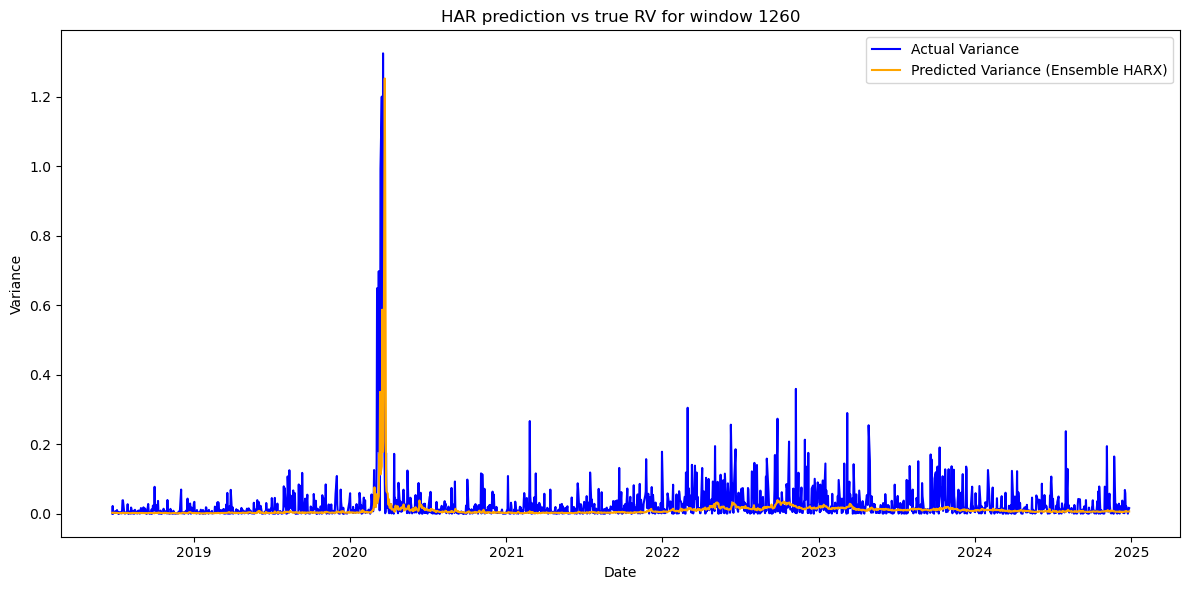

In [142]:
eps = 1e-12

y_true =\
(
    252
    *
    (np.log(tlt_data["Close"]
           .shift(-1)
            /
           tlt_data["Close"]))**2

)

y_actual_var =y_true.loc[common_idx]
yhat_ensemble_HARX_var = yhat_ensemble_HARX.loc[common_idx]
print(y_actual_var)
print(yhat_ensemble_HARX_var)


plt.figure(figsize=(12, 6))
plt.plot(y_actual_var, label='Actual Variance', color='blue')
plt.plot(yhat_ensemble_HARX_var, label='Predicted Variance (Ensemble HARX)', color='orange')
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.title(f"HAR prediction vs true RV for window {w}")
plt.tight_layout()
plt.show()


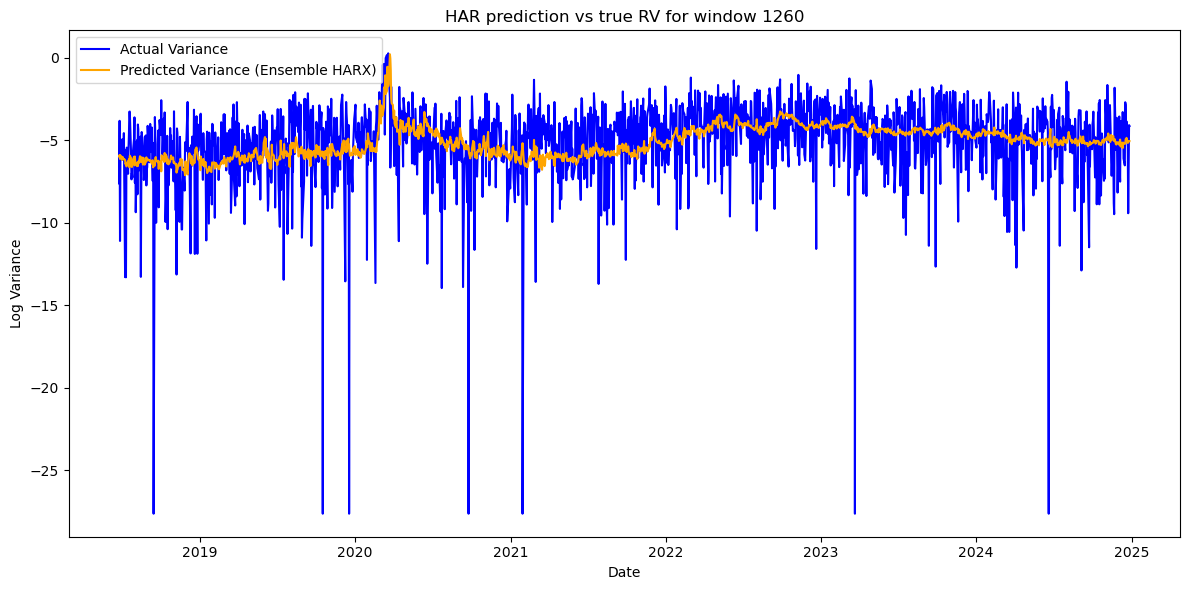

In [148]:
#lOG VARIANCE SCALE
eps = 1e-12

y_true_log = np.log(y_true.clip(lower=eps))
y_true_log =\
(
    y_true_log
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .iloc[1:]
)

y_actual_log =y_true_log.loc[common_idx]
yhat_ensemble_HARX_log = yhat_ensemble_HARX_f.loc[common_idx]

plt.figure(figsize=(12, 6))
plt.plot(y_actual_log, label='Actual Variance', color='blue')
plt.plot(yhat_ensemble_HARX_log, label='Predicted Variance (Ensemble HARX)', color='orange')
plt.xlabel("Date")
plt.ylabel("Log Variance")
plt.legend()
plt.title(f"HAR prediction vs true RV for window {w}")
plt.tight_layout()
plt.show()

            qlike_loss
Date                  
2018-06-25   -5.776507
2018-06-26    2.036263
2018-06-27   -6.109674
2018-06-28   -4.807409
2018-06-29   -5.053616
...                ...
2024-12-20   -2.128535
2024-12-23   -4.376036
2024-12-24   -5.089693
2024-12-26   -2.407072
2024-12-27   -2.548659

[1639 rows x 1 columns]
               mspe_loss
Date                    
2018-06-25     16.933094
2018-06-26      0.763246
2018-06-27  20759.298879
2018-06-28      0.008880
2018-06-29      0.013554
...                  ...
2024-12-20      0.398953
2024-12-23      0.086395
2024-12-24   5392.779415
2024-12-26      0.384071
2024-12-27      0.357964

[1639 rows x 1 columns]
            rmse_loss
Date                 
2003-01-02        NaN
2003-01-03        NaN
2003-01-06        NaN
2003-01-07        NaN
2003-01-08        NaN
...               ...
2024-12-23   0.039879
2024-12-24   0.039873
2024-12-26   0.021696
2024-12-27   0.021790
2024-12-30        NaN

[5536 rows x 1 columns]


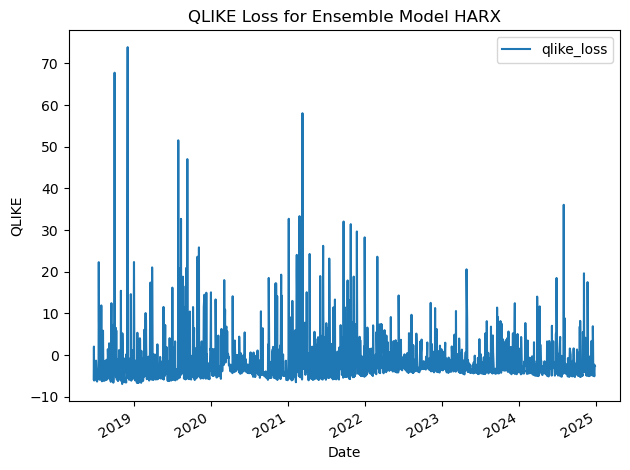

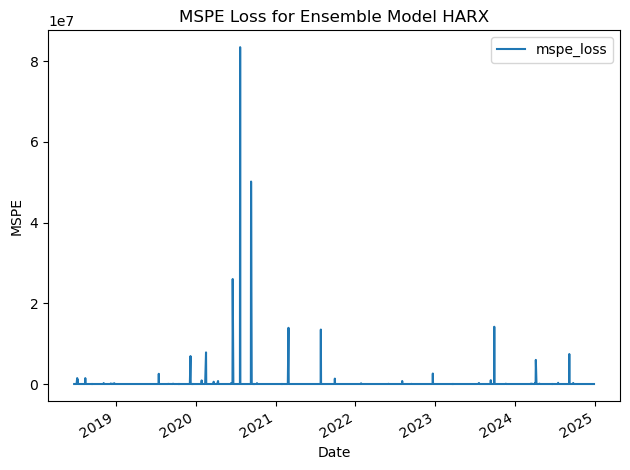

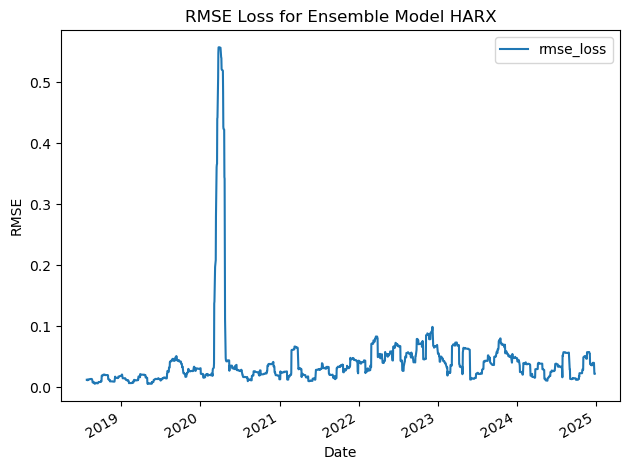

In [144]:
# model prediction performance
qlike_loss_df = pd.DataFrame(Metric_Evaluation.qlike(y_actual_var,yhat_ensemble_HARX_var), columns=['qlike_loss']) # use variance to compute
mspe_loss_df  = pd.DataFrame(Metric_Evaluation.mspe(y_actual_var,yhat_ensemble_HARX_var), columns=['mspe_loss'])
rmse_loss_df  = pd.DataFrame(Metric_Evaluation.rmse(y_actual_var,yhat_ensemble_HARX_var), columns =['rmse_loss'])

rmse_loss_df_adj = rmse_loss_df.dropna()
mspe_loss_df_adj = mspe_loss_df.dropna()

print(qlike_loss_df)
print(mspe_loss_df)
print(rmse_loss_df)

qlike_loss_df.plot()
plt.xlabel("Date")
plt.ylabel("QLIKE")
plt.legend()
plt.title(f"QLIKE Loss for Ensemble Model HARX")
plt.tight_layout()
plt.show()

mspe_loss_df.plot()
plt.xlabel("Date")
plt.ylabel("MSPE")
plt.legend()
plt.title(f"MSPE Loss for Ensemble Model HARX")
plt.tight_layout()
plt.show()

rmse_loss_df.plot()
plt.xlabel("Date")
plt.ylabel("RMSE")
plt.legend()
plt.title(f"RMSE Loss for Ensemble Model HARX")
plt.tight_layout()
plt.show()

In [145]:

test_qlike_mean = qlike_loss_df.mean()
test_qlike_std = qlike_loss_df.std()
test_mspe_mean = mspe_loss_df_adj.mean()
test_mspe_std = mspe_loss_df_adj.std()
rmse_loss_df_adj_mean = rmse_loss_df_adj.mean()
rmse_loss_df_adj_std = rmse_loss_df_adj.std()

print(f"Test QLIKE Mean: {test_qlike_mean.values[0]:.4f}, Std: {test_qlike_std.values[0]:.4f}")
print(f"Test MSPE  Mean: {test_mspe_mean.values[0]:.4f}, Std: {test_mspe_std.values[0]:.4f}")
print(f"Test RMSE  Mean: {rmse_loss_df_adj_mean.values[0]:.4f}, Std: {rmse_loss_df_adj_std.values[0]:.4f}")

Test QLIKE Mean: -1.2313, Std: 6.4891
Test MSPE  Mean: inf, Std: nan
Test RMSE  Mean: 0.0423, Std: 0.0627


c:\Users\lawor\anaconda3v0\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [146]:

yhat_ensemble_HARX_f.to_csv("C:/Users/lawor/OneDrive/Desktop/2025sem3/QF603/project/yhat_log_harx.csv", index=True)
yhat_ensemble_HARX_var.to_csv("C:/Users/lawor/OneDrive/Desktop/2025sem3/QF603/project/yhat_var_harx.csv", index=True)

## Test set to run - HAR model with window = 504

In [119]:
train_x

square_est_log  parkinson_est_log  gk_est_log  rs_est_log
Date                                                                 
2003-01-09       -5.085143          -6.464545   -6.212822   -6.215203
2003-01-10       -2.357159          -4.110049   -4.329164   -4.429030
2003-01-13       -6.394209          -4.834137   -4.698009   -4.456492
2003-01-14       -7.302409          -5.900576   -5.644996   -5.654848
2003-01-15       -5.783231          -6.680704   -6.357100   -5.849842
...                    ...                ...         ...         ...
2018-05-17       -5.592373          -5.619643   -6.075626   -6.446356
2018-05-18       -5.041687          -5.634768   -5.603700   -5.697056
2018-05-21       -3.989943          -5.509909   -6.157877   -6.770363
2018-05-22       -9.625920          -6.705455   -6.464212   -6.461310
2018-05-23       -7.427586          -6.402700   -6.207804   -6.106128

[3870 rows x 4 columns]

In [120]:
#HAR-504 
#HARX-756
w_HAR = 504

test_x_aug = pd.concat([train_x.tail(w_HAR),
                       test_x]). sort_index()

test_y_aug = pd.concat([train_y[-w_HAR:],
                        test_y]).sort_index()
print(test_x_aug)
print(test_y_aug)

            square_est_log  parkinson_est_log  gk_est_log  rs_est_log
Date                                                                 
2016-05-24       -6.685862          -5.651857   -5.332779   -5.300426
2016-05-25       -5.297391          -5.323616   -5.007362   -4.844120
2016-05-26       -5.626383          -5.345771   -5.224358   -5.118208
2016-05-27       -5.002052          -6.088924   -5.864355   -5.537252
2016-05-31       -7.526390          -6.384756   -6.185135   -6.219957
...                    ...                ...         ...         ...
2024-12-20       -2.835980          -4.699546   -4.442752   -4.463816
2024-12-23       -4.812897          -5.414671   -5.190815   -4.897708
2024-12-24       -3.844518          -4.912701   -5.361084   -5.783078
2024-12-26       -5.406559          -4.620756   -5.322553   -6.063504
2024-12-27       -9.413061          -4.984313   -5.347732   -5.615191

[2164 rows x 4 columns]
Date
2016-05-24   -5.626383
2016-05-25   -5.002052
2016-05-26   -

In [121]:
estimators = ['square_est_log', 'parkinson_est_log', 'gk_est_log', 'rs_est_log']

per_pred = {}
per_residual = {}
pred_raw_residual = {}
qlike_df = {}
X_all = {}
Y_all = {}

yhat_est = {est: [] for est in estimators}

# first step to get all the features out from test set
for est in estimators:
  har = HAR_Model(y_log_col=est, exo_col=None, lags=[1,5,22])

  x_est = har.features(test_x_aug) #lags 

  #to align the index
  common_idx = test_y_aug.index.intersection(x_est.index)
  x_est = x_est.loc[common_idx]
  y_true = test_y_aug.loc[common_idx] # log variance

  X_all[est] = x_est
  Y_all = y_true
  Y_all_var = np.exp(y_true) # variance


In [122]:
yhat_est = {est: [] for est in estimators}
yhat_est_var = {est: [] for est in estimators}
yhat_ensemble = []
yhat_var_df = []

residual_est = {est: [] for est in estimators}
residual_ensemble = []

q_loss_est = {}

qlike_loss_ensemble = []
mspe_loss_ensemble = []
rmse_loss_ensemble = []

weight_est = []
weight_path = {est: [] for est in estimators}

log_yhat_final = []

predict_idx = X_all[estimators[0]].index

Y_all_var = np.exp(y_true)

#to get rolling window prediction
for t in range(w_HAR, len(predict_idx)):
  ts = predict_idx[t]
  win_start = t-w_HAR
  win_end = t

  yhat_t = {}
  y_pred_t = {}
  yhat_var_t = {}
  residual_t = {}
  raw_residual_t = {}
  pred_raw_residual_t = {}
  yhat_var = {}
  pred_residual_t = {}
  pred_raw_residual_t = {}

  for est in estimators:
    x_window = X_all[est].iloc[win_start:win_end +1]
    y_window = Y_all.iloc[win_start:win_end +1]

    y_pred, resid_pred, residual_raw = har.fit_predict(x_window,
                                                       y_window,
                                                       window=w_HAR)

    #extraction prediction results at time t
    y_pred_t[est] = y_pred.iloc[-1]
    residual_t[est] = resid_pred.iloc[-1]
    raw_residual_t[est] = residual_raw.iloc[-1]

    #store results
    yhat_est[est].append((ts, y_pred_t)) #log variance
    residual_est[est].append((ts,raw_residual_t)) #residual computed by log variance

  y_true_t = Y_all_var.loc[ts] #variance

  # nested dict to covert to dataframe
  rows = []
  for est, tuples in  yhat_est.items():
      for ts, inner_dict in tuples:
          row = {'Date': ts}
          row.update(inner_dict)  # add all estimator predictions
          rows.append(row)
  yhat_est_df = pd.DataFrame(rows).drop_duplicates(subset=['Date']).set_index('Date')

  yhat_var_row = pd.DataFrame(np.exp(yhat_est_df.loc[ts]))

  qlike_loss_df = pd.DataFrame({col: Metric_Evaluation.qlike(y_true_t, yhat_var_row[col])
                                for col in yhat_var_row.columns}) # use variance to compute
  mspe_loss_df  = pd.DataFrame({col: Metric_Evaluation.mspe(y_true_t, yhat_var_row[col])
                                for col in yhat_var_row.columns})  # use variance to compute

  qlike_loss_T = qlike_loss_df.T
  ensemble_model = EnsembleModel(estimators=list(yhat_var_row.columns))
  weight_path[ts] = ensemble_model.compute_weightage(qlike_loss_T.loc[ts]) #get weights for 4 estimators
  weight_est.append((ts,weight_path[ts]))
  q_loss_est[ts] = qlike_loss_T.loc[ts]

In [123]:
#weight
rows = []
for ts, inner_dict in weight_est:   # directly unpack
    row = {'Date': ts}
    row.update(inner_dict)          # add weight values for all estimators
    rows.append(row)

weight_HAR = pd.DataFrame(rows).drop_duplicates(subset=['Date']).set_index('Date')


#yhat
rows = []
# Iterate through the outer dict
for est_name, records in yhat_est.items():
    for ts, inner_dict in records:
        row = {'Date': ts}
        row.update(inner_dict)  # add all estimator values
        rows.append(row)

# Convert to DataFrame
yhat_log_har = pd.DataFrame(rows)

# Drop duplicates so each timestamp appears only once
yhat_log_har = yhat_log_har.drop_duplicates(subset=['Date']).set_index('Date')

yhat_var_har = np.exp(yhat_log_har)

#compute to get the final yhat - variance
weights_shifted = weight_HAR.shift(1)
weights_shifted.iloc[0] = 1 / len(estimators)

yhat_ensemble_HAR = (weights_shifted * yhat_var_har).sum(axis=1) # variance
yhat_ensemble_HAR.name = 'yhat_ensemble_HAR'

yhat_ensemble_log_HAR = np.log(yhat_ensemble_HAR)

print(weight_HAR)
print(yhat_var_har)
print(yhat_log_har)
print(yhat_ensemble_HAR)
print(yhat_ensemble_log_HAR)


            square_est_log  parkinson_est_log  gk_est_log  rs_est_log
Date                                                                 
2018-06-25        0.250000           0.250000    0.250000    0.250000
2018-06-26        0.437508           0.205813    0.168302    0.188377
2018-06-27        0.250000           0.250000    0.250000    0.250000
2018-06-28        0.250000           0.250000    0.250000    0.250000
2018-06-29        0.250000           0.250000    0.250000    0.250000
...                    ...                ...         ...         ...
2024-12-20        0.250000           0.250000    0.250000    0.250000
2024-12-23        0.250000           0.250000    0.250000    0.250000
2024-12-24        0.250000           0.250000    0.250000    0.250000
2024-12-26        0.250000           0.250000    0.250000    0.250000
2024-12-27        0.250000           0.250000    0.250000    0.250000

[1639 rows x 4 columns]
            square_est_log  parkinson_est_log  gk_est_log  rs_est

In [124]:
# both in log variance to plot later
common_idx = y_true_log.index.intersection(yhat_ensemble_log_HAR.index)
y_actual = y_true_log.loc[common_idx]
yhat_ensemble_HAR_f = yhat_ensemble_log_HAR.loc[common_idx]

eps = 1e-12

y_true =\
(
    252
    *
    (np.log(tlt_data["Close"]
           .shift(-1)
            /
           tlt_data["Close"]))**2

)

y_actual_var =y_true.loc[common_idx]
yhat_ensemble_HAR_var = yhat_ensemble_HAR.loc[common_idx]

print(y_actual)
print(yhat_ensemble_HAR_f)
print(y_actual_var)
print(yhat_ensemble_HAR_var)


Date
2018-06-25    -7.604185
2018-06-26    -3.808988
2018-06-27   -11.093858
2018-06-28    -5.812473
2018-06-29    -6.059464
                ...    
2024-12-20    -3.844518
2024-12-23    -5.406559
2024-12-24    -9.413061
2024-12-26    -4.069927
2024-12-27    -4.126031
Name: Close, Length: 1639, dtype: float64
Date
2018-06-25   -6.087394
2018-06-26   -6.159489
2018-06-27   -6.113448
2018-06-28   -6.224951
2018-06-29   -6.259188
                ...   
2024-12-20   -4.889065
2024-12-23   -4.991813
2024-12-24   -5.044285
2024-12-26   -5.022244
2024-12-27   -4.988722
Name: yhat_ensemble_HAR, Length: 1639, dtype: float64
Date
2018-06-25    0.000498
2018-06-26    0.022171
2018-06-27    0.000015
2018-06-28    0.002990
2018-06-29    0.002336
                ...   
2024-12-20    0.021397
2024-12-23    0.004487
2024-12-24    0.000082
2024-12-26    0.017079
2024-12-27    0.016147
Name: Close, Length: 1639, dtype: float64
Date
2018-06-25    0.002271
2018-06-26    0.002113
2018-06-27    0.002213
201

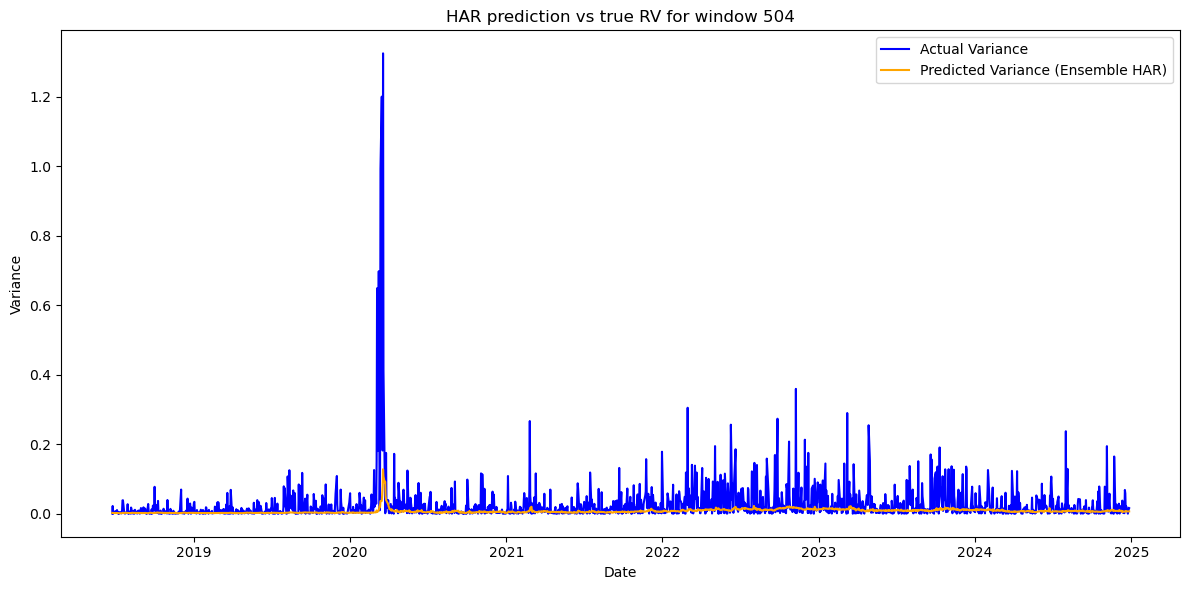

In [125]:
# VARIANCE SCALE PLOT
plt.figure(figsize=(12, 6))
plt.plot(y_actual_var, label='Actual Variance', color='blue')
plt.plot(yhat_ensemble_HAR_var, label='Predicted Variance (Ensemble HAR)', color='orange')
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.title(f"HAR prediction vs true RV for window {w_HAR}")
plt.tight_layout()
plt.show()


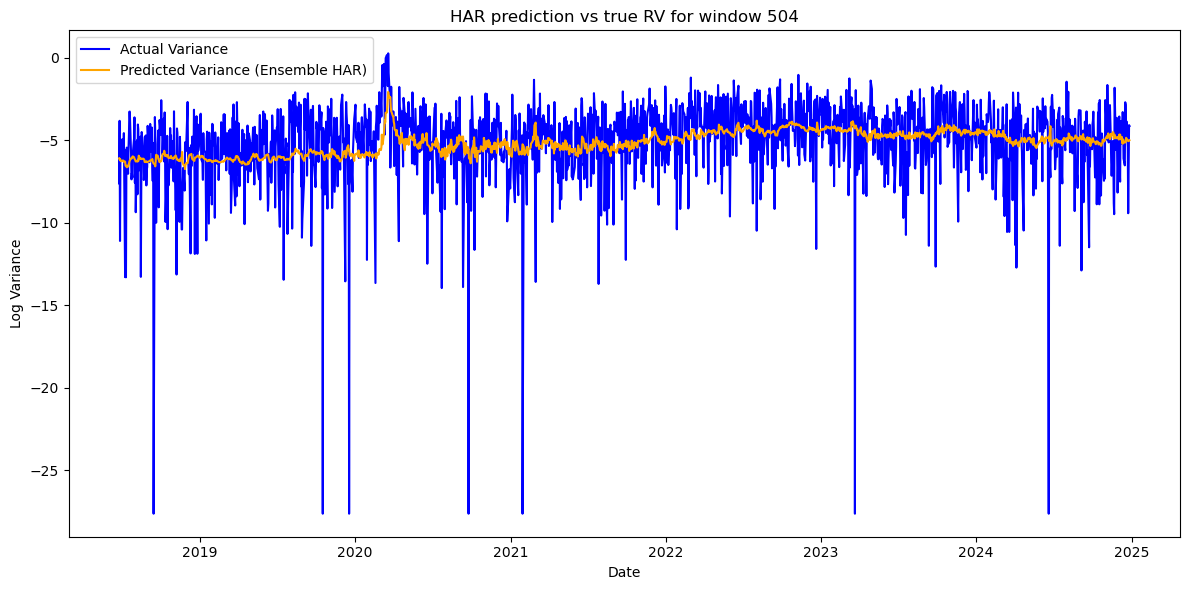

In [126]:
# LOG VARIANCE SCALE PLOT

plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual Variance', color='blue')
plt.plot(yhat_ensemble_log_HAR, label='Predicted Variance (Ensemble HAR)', color='orange')
plt.xlabel("Date")
plt.ylabel("Log Variance")
plt.legend()
plt.title(f"HAR prediction vs true RV for window {w_HAR}")
plt.tight_layout()
plt.show()


            qlike_loss
Date                  
2018-06-25   -5.867979
2018-06-26    4.331341
2018-06-27   -6.106576
2018-06-28   -4.714395
2018-06-29   -5.038122
...                ...
2024-12-20   -2.046954
2024-12-23   -4.331305
2024-12-24   -5.031618
2024-12-26   -2.430538
2024-12-27   -2.619194

[1639 rows x 1 columns]
               mspe_loss
Date                    
2018-06-25     12.656372
2018-06-26      0.818443
2018-06-27  20890.119069
2018-06-28      0.114239
2018-06-29      0.032777
...                  ...
2024-12-20      0.420097
2024-12-23      0.264182
2024-12-24   6075.729466
2024-12-26      0.377185
2024-12-27      0.334055

[1639 rows x 1 columns]
            rmse_loss
Date                 
2003-01-02        NaN
2003-01-03        NaN
2003-01-06        NaN
2003-01-07        NaN
2003-01-08        NaN
...               ...
2024-12-23   0.039289
2024-12-24   0.039268
2024-12-26   0.021315
2024-12-27   0.021392
2024-12-30        NaN

[5536 rows x 1 columns]


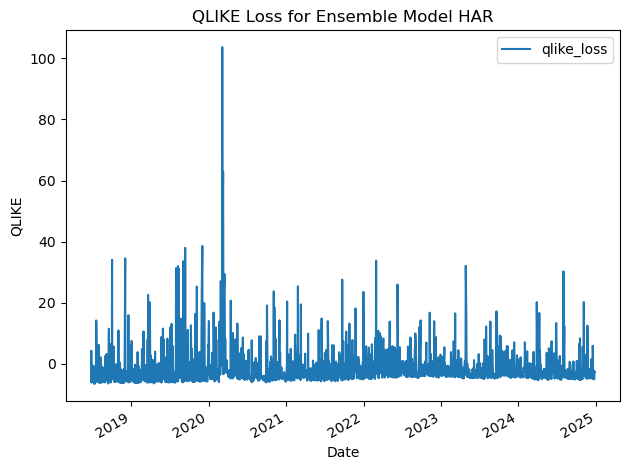

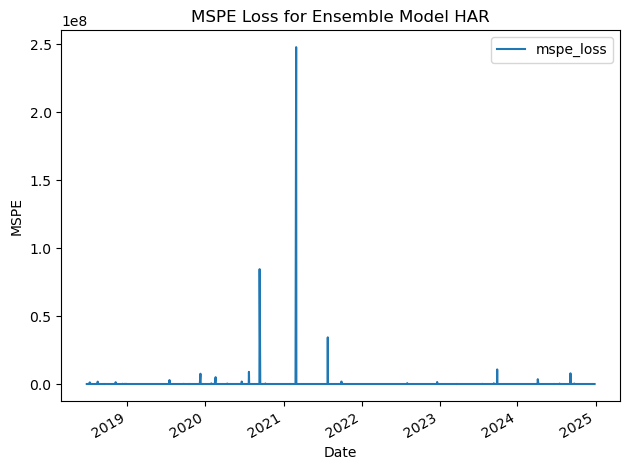

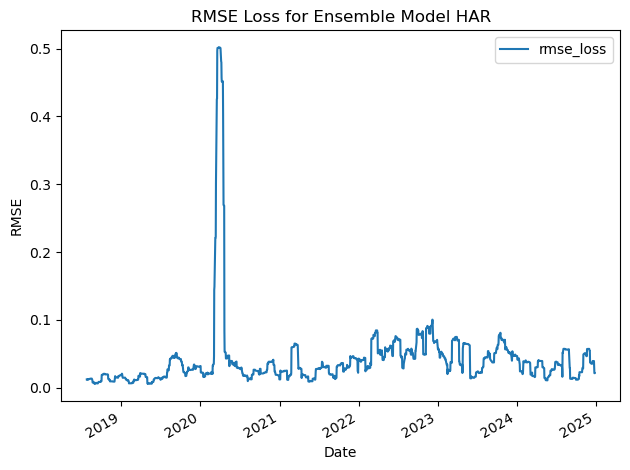

In [127]:
# model prediction performance
qlike_loss_df = pd.DataFrame(Metric_Evaluation.qlike(y_actual_var,yhat_ensemble_HAR_var), columns=['qlike_loss']) # use variance to compute
mspe_loss_df  = pd.DataFrame(Metric_Evaluation.mspe(y_actual_var,yhat_ensemble_HAR_var), columns=['mspe_loss'])
rmse_loss_df  = pd.DataFrame(Metric_Evaluation.rmse(y_actual_var,yhat_ensemble_HAR_var), columns =['rmse_loss'])

rmse_loss_df_adj = rmse_loss_df.dropna()
mspe_loss_df_adj = mspe_loss_df.dropna()

print(qlike_loss_df)
print(mspe_loss_df)
print(rmse_loss_df)

qlike_loss_df.plot()
plt.xlabel("Date")
plt.ylabel("QLIKE")
plt.legend()
plt.title(f"QLIKE Loss for Ensemble Model HAR")
plt.tight_layout()
plt.show()

mspe_loss_df.plot()
plt.xlabel("Date")
plt.ylabel("MSPE")
plt.legend()
plt.title(f"MSPE Loss for Ensemble Model HAR")
plt.tight_layout()
plt.show()

rmse_loss_df.plot()
plt.xlabel("Date")
plt.ylabel("RMSE")
plt.legend()
plt.title(f"RMSE Loss for Ensemble Model HAR")
plt.tight_layout()
plt.show()


In [128]:
test_qlike_mean = qlike_loss_df.mean()
test_qlike_std = qlike_loss_df.std()
test_mspe_mean = mspe_loss_df_adj.mean()
test_mspe_std = mspe_loss_df_adj.std()
rmse_loss_df_adj_mean = rmse_loss_df_adj.mean()
rmse_loss_df_adj_std = rmse_loss_df_adj.std()

print(f"Test QLIKE Mean: {test_qlike_mean.values[0]:.4f}, Std: {test_qlike_std.values[0]:.4f}")
print(f"Test MSPE  Mean: {test_mspe_mean.values[0]:.4f}, Std: {test_mspe_std.values[0]:.4f}")
print(f"Test RMSE  Mean: {rmse_loss_df_adj_mean.values[0]:.4f}, Std: {rmse_loss_df_adj_std.values[0]:.4f}")

Test QLIKE Mean: -1.1518, Std: 6.6956
Test MSPE  Mean: inf, Std: nan
Test RMSE  Mean: 0.0417, Std: 0.0570


c:\Users\lawor\anaconda3v0\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


## Preliminary Evaluation
- HARX only provide slight improvement as compared to HAR model
- HARX offers a more stable, better-calibrated prediction with near-equivalent RMSE and smoother QLIKE/MSPE behavior, especially evident around the 756-day horizon.
- The marginal contribution of exogenous variables (HARX) is expected to be small unless those variables provide substantial new information orthogonal to past volatility.

In [129]:
yhat_ensemble_log_HAR.to_csv("C:/Users/lawor/OneDrive/Desktop/2025sem3/QF603/project/yhat_log_har.csv", index=True)
yhat_ensemble_HAR_var.to_csv("C:/Users/lawor/OneDrive/Desktop/2025sem3/QF603/project/yhat_var_har.csv", index=True)